# Data Challenge report: Large Scale Machine Learning

### Authors: 
#### Arnaud Sangouard

# Image Classification:

Image classification is the task of assigning to an image a label from a predefined set of
categories. A CNN [1] is intended to identify visual forms from images with least computation [2]. In the last few years, we saw a rapid progress in visual image processing systems, mostly due to advances of deep convolutional neural networks.



1. Y. LeCun, L. Bottu, Y. Bengio, Gradient-based learning applied to document recognition, Proceedings of the
IEEE 86 (11) (1998) 2278–2324, https://doi.org/10.1109/5.726791.
2. Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton, Imagenet classification with deep convolutional neural net-works, in: NIPS’12 Proceedings of the 25th InternationalConference on Neural Information ProcessingSystem,
vol. 1, 2012, pp. 1097–1105, arXiv:1311.2901.

# Présentation des approches suivies:

Afin de tenter de résoudre la problématique proposée par le data challenge j'ai developpé plusieurs modèles basés sur des stratégies diverses:

***Approche 1*** - classifieur sommaire

***Approche 2*** - lutte contre l'overfit

***Approche 3*** - Tentative avec un modèle plus complexe et une architecture Resnet

***Approche 4*** - Approche basé sur deux classifieurs et le Gradient Reversal Layer

***Approche 5*** - Classifieur par genre 

***Approche 6*** - Transfer learning depuis Xception

***Approche 7*** - Approche hybride et fine tuning depuis Facenet

***Approche 8*** - Annexe - Triplet approach

# Résultats et discussion

### Import

In [9]:
import glob, os, re
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [10]:
# pour éviter les warnings
import warnings
warnings.filterwarnings('ignore')

### Investigate the data

In [11]:
os.chdir("C://Users//ArnaudA//Documents//Développement personnel//MASTERE IA//MDI341 Machine Learning avancé//Data challenge//Data")
main_path=os.getcwd()
main_path

'C:\\Users\\ArnaudA\\Documents\\Développement personnel\\MASTERE IA\\MDI341 Machine Learning avancé\\Data challenge\\Data'

In [12]:
print('total training images:', len(os.listdir("train")))
print('total validation images:', len(os.listdir("validation")))
print('total test images:', len(os.listdir("test")))

total training images: 149983
total validation images: 24996
total test images: 27596


shape of the image (80, 80, 3)
Value of the pixel [ 77 101 159]


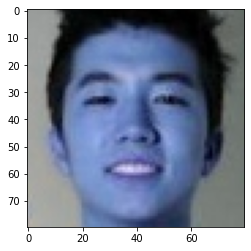

In [13]:
img = cv.imread('train/102540.jpg')
print('shape of the image {}'.format(img.shape))
print('Value of the pixel {}'.format(img[40,40]))
plt.imshow(img,cmap="binary")


### Data Preparation

In [121]:
train_labels = pd.read_csv('label_train.txt', sep = ' ', header = None, names = ['label', 'genre'], dtype=int)
filenames = os.listdir('train')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
print(filenames[:10])
print(len(filenames))
train_filenames = pd.DataFrame(filenames, columns = ['filenames'])
train_df = pd.concat([train_filenames, train_labels], axis=1)

['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg']
149983


In [16]:
print(train_df['genre'].value_counts()/len(train_df))

0    0.582839
1    0.417161
Name: genre, dtype: float64


In [17]:
print(train_df['genre'].value_counts())

0    87416
1    62567
Name: genre, dtype: int64


In [122]:
val_labels = pd.read_csv('label_validation.txt', sep = ' ', header = None, names = ['label', 'genre'], dtype=int)
filenames = os.listdir('validation')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
print(filenames[:10])
print(len(filenames))
val_filenames = pd.DataFrame(filenames, columns = ['filenames'])
val_df = pd.concat([val_filenames, val_labels], axis=1)

['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg']
24996


In [13]:
print(val_df['genre'].value_counts()/len(val_df))

0    0.584654
1    0.415346
Name: genre, dtype: float64


### Preprocessing

In [20]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision import models
from torch import nn,optim
import torch.nn.functional as F
from torchvision.io import read_image

In [23]:
#Specific Class Custom Dataset to generate adequate dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, target_transform=None):
        self.img_labels = df['label']
        self.img_genres = df['genre']
        self.filenames = df['filenames']
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.labels = train_df['label'].unique()
        self.genres = train_df['genre'].unique()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        image = cv.imread(img_path) #read_image(img_path)
        label = torch.tensor(self.img_labels.iloc[idx], dtype=torch.long)
        genre = torch.tensor(self.img_genres.iloc[idx], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = (image,label,genre)
        return sample

In [101]:
#Caractéristics of image transformation 
image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

#Caractéristics of data augmenation 
data_augmentation_tr = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.RandomErasing(p=0.1),
])

#Caractéristics of data augmenation 
data_augmentation_tr2 = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.FiveCrop(50),
            transforms.Lambda(lambda crops: torch.stack([(crop) for crop in crops])),
            transforms.Resize(80),
    
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            #transforms.RandomErasing(p=0.1),
])

### Data exploration

In [102]:
data_augmentation = False
#Dataset and DataLoader
batch_size=128
#Training dataset
train_original = CustomImageDataset(train_df, "train", transform = image_transform)
train_augmentation = CustomImageDataset(train_df, "train", transform = data_augmentation_tr)
if data_augmentation == False:
    train_dataset = train_original
else:
    #train_dataset = torch.utils.data.TensorDataset(train_augmentation, train_original)
    train_dataset = torch.utils.data.ConcatDataset([train_augmentation,train_original])

#Validation dataset
val_dataset = CustomImageDataset(val_df, "validation", transform = image_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

print('Number of training samples: {}'.format(len(train_dataset)))
print('Number of validation samples: {}'.format(len(val_dataset)))
print('sample size: {}'.format(train_dataset[0][0].shape))
print('image rows: {}'.format(train_dataset[0][0].shape[1]))
print('image cols: {}'.format(train_dataset[0][0].shape[2]))
print('example of item :',val_dataset.__getitem__(10))

if data_augmentation == False:    
    print('Classes: {}'.format(np.unique(train_loader.dataset.labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.genres)))
else:
    print('Classes: {}'.format(np.unique(train_loader.dataset.datasets[0].labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.datasets[0].genres)))

Number of training samples: 149983
Number of validation samples: 24996
sample size: torch.Size([3, 80, 80])
image rows: 80
image cols: 80
example of item : (tensor([[[ 1.4269,  0.8961, -0.2171,  ..., -0.8507, -0.5767, -1.1247],
         [ 0.8789,  0.1083, -1.0048,  ..., -0.9534, -0.7308, -1.2445],
         [ 0.3138, -1.0904, -0.9705,  ..., -0.3198, -0.6965, -0.9877],
         ...,
         [-1.8782, -1.5357, -2.1179,  ..., -0.6281, -0.9877, -1.1247],
         [-1.4843, -1.6727, -1.5528,  ..., -0.5253, -0.7308, -1.0733],
         [-1.5185, -1.9295, -1.3815,  ...,  0.6563,  0.1426, -1.0390]],

        [[ 1.9209,  1.4307,  0.2927,  ..., -0.1450,  0.0476, -0.4951],
         [ 1.4307,  0.6429, -0.4601,  ..., -0.2675, -0.0749, -0.5826],
         [ 0.9405, -0.4601, -0.3550,  ...,  0.3803,  0.0476, -0.2500],
         ...,
         [-1.5455, -1.1954, -1.8782,  ..., -0.4426, -0.7227, -0.8277],
         [-1.0903, -1.3354, -1.3004,  ..., -0.3375, -0.4951, -0.8102],
         [-1.1253, -1.5980, -1.1

In [71]:
#Batch description
dataiter = iter(train_loader)
images, labels, _= dataiter.next()
print('size of batch of labels: {}'.format(labels.shape))
print('size of batch of images: {}'.format(images.shape))
print(labels)

size of batch of labels: torch.Size([128])
size of batch of images: torch.Size([128, 3, 80, 80])
tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1])


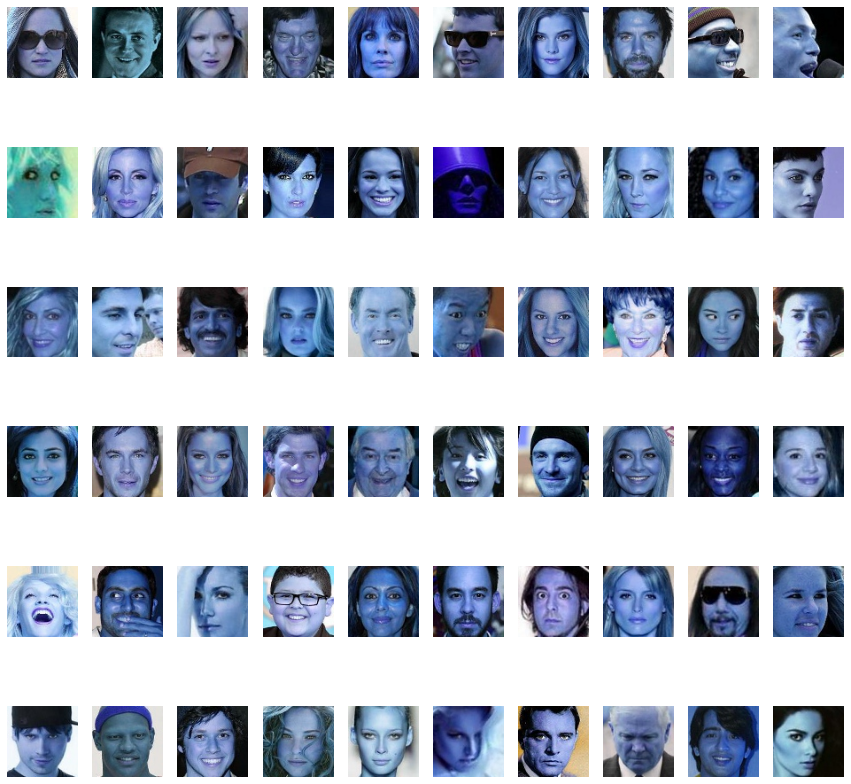

In [72]:
#plot images
figure = plt.figure(figsize=(15,15))
num_of_images = 61
filenames = os.listdir('train')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
samples = np.random.choice(filenames, size= num_of_images, replace=False)
for index in range(1, num_of_images):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(torch.from_numpy(cv.imread('train/'+samples[index])).numpy().squeeze(), cmap='gray_r')
    #print(train_df.set_index('filenames').loc[samples[index]])
#plot labels 


shape of the image (80, 80, 3)
Value of the pixel [114 147 216]


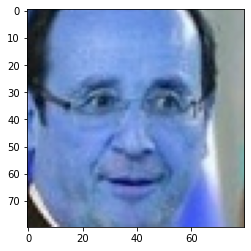

In [31]:
img = cv.imread('train/123675.jpg')
print('shape of the image {}'.format(img.shape))
print('Value of the pixel {}'.format(img[40,40]))
plt.imshow(img,cmap="binary")

shape of the image (80, 80, 3)
Value of the pixel [ 37 116 213]
label    0
genre    0
Name: 046582.jpg, dtype: int32


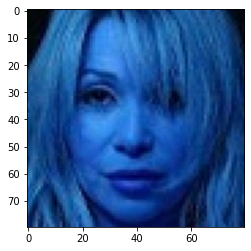

In [32]:
index =25
img = cv.imread('train/'+samples[index])
print('shape of the image {}'.format(img.shape))
print('Value of the pixel {}'.format(img[40,40]))
print(train_df.set_index('filenames').loc[samples[index]])
plt.imshow(img,cmap="binary")

### Helper functions

In [53]:
# Helper functions to plot losses and accuracies
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

In [54]:
#Generic train function for one model
def train(model, train_loader, optimizer, 
          epoch, log_interval=10, criterion = nn.CrossEntropyLoss()):
    ''' Generic train function for one model'''
    model.train()
    loss_epoch = 0.0
    acc_epoch = 0
    for batch_idx, data in enumerate(train_loader):

        # get the inputs; data is a list of [inputs, labels]
        images, labels, _ = data
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        #record losses and accuracies
        loss_epoch += loss.cpu().item()
        acc = accuracy(outputs, labels)
        acc_epoch += acc.item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, batch_idx * len(labels), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item(), acc.item()))
    #scheduler.step(loss_cpu / len(train_loader.dataset))
    #print(scheduler._last_lr)
    train_loss = loss_epoch/ len(train_loader)
    train_acc = acc_epoch/ len(train_loader)
    print('Train Epoch: {} \LOSS: {:.6f} \Accuracy: {:.6f}'.
          format(epoch, train_loss, train_acc))
    return train_loss, train_acc

In [55]:
def test(model, val_loader, epoch, criterion = nn.CrossEntropyLoss()):
    ''' Generic test function for one model'''
    model.eval()
    loss_epoch = 0.0
    acc_epoch = 0 
    acc_men = 0
    acc_women = 0
    nb_men = 0
    nb_women = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            images, labels, genres = data
            images = images.to(device)
            labels = labels.to(device)
            genres = genres.to(device)
            outputs  = model(images)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            loss_epoch +=loss.item()
            acc_epoch +=acc.item() 
            nb_men += torch.sum(genres == 1)
            nb_women += torch.sum(genres == 0)
    val_loss = loss_epoch/ len(val_loader)
    val_acc = acc_epoch/ len(val_loader)
    print('Test Epoch: {} \LOSS: {:.6f} \Accuracy: {:.6f}'.
          format(epoch, val_loss, val_acc))

    return val_loss, val_acc 

In [56]:
def accuracy(outputs, labels):
    ''' function to calculate accuracy'''
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)) 

In [57]:
def predict_dataset(model, dataset):
    ''' function to calculate prediction from a dataset'''
    model.eval()
    loader=torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=False)
    results= torch.zeros((len(loader),1), dtype=torch.int32)
    labels= torch.zeros((len(loader),1), dtype=torch.int32)
    genres= torch.zeros((len(loader),1), dtype=torch.int32)
    with torch.no_grad():
        for idx, (image,label,genre) in enumerate(loader):
            image = image.to(device)
            results[idx] = torch.argmax(model(image),axis=1)
            labels[idx] = label
            genres[idx] = genre
    
    print('Prediction complete')

    return results, labels, genres 

In [58]:
def predict_dataset_bimodel(GF, CL, dataset):
    ''' function to calculate predictions from a dataset with bimodel '''
    GF.eval()
    CL.eval()
    loader=torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=False)
    results= torch.zeros((len(loader),1), dtype=torch.int32)
    labels= torch.zeros((len(loader),1), dtype=torch.int32)
    genres= torch.zeros((len(loader),1), dtype=torch.int32)
    with torch.no_grad():
        for idx, (image,label,genre) in enumerate(loader):
            image = image.to(device)
            results[idx] = torch.argmax(CL(GF(image)),axis=1)
            labels[idx] = label
            genres[idx] = genre
    
    print('Prediction complete')

    return results, labels, genres 

In [59]:
def accuracy_dataset(results, labels, genres):
    ''' function to calculate accuracy from a batch of data'''
    acc_men = torch.sum(results[genres==1]==labels[genres==1])/torch.sum(genres==1)
    acc_women = torch.sum(results[genres==0]==labels[genres==0])/torch.sum(genres==0)
    acc = torch.sum(results==labels)/len(genres)
    return acc.item(), acc_men.item(), acc_women.item() 

In [60]:
def predict_test_dataset(model, dataset):
    ''' function to calculate predictions only '''
    model.eval()
    loader=torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=False)
    results= torch.zeros((len(loader),1), dtype=torch.int32)
    with torch.no_grad():
        for idx, (image) in enumerate(loader):
            image = image.to(device)
            results[idx] = torch.argmax(model(image),axis=1)
    
    print('Prediction complete')

    return results

In [61]:
def predict_dataset_threshold(model, dataset,threshold = 0.5):
    ''' function to calculate predictions with a threshold '''
    model.eval()
    loader=torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=False)
    results= torch.zeros((len(loader),1), dtype=torch.int32)
    labels= torch.zeros((len(loader),1), dtype=torch.int32)
    genres= torch.zeros((len(loader),1), dtype=torch.int32)
    with torch.no_grad():
        for idx, (image,label,genre) in enumerate(loader):
            image = image.to(device)
            results[idx] = nn.functional.softmax(model(image))[:,1]>threshold
            labels[idx] = label
            genres[idx] = genre
    
    print('Prediction complete')

    return results, labels, genres 

### Approche 1 - classifieur sommaire

En première approche j'ai tenté un classifieur très simple afin de me donner une baseline comme référence.
Conv_bn
Le classifieur est constitué de 4 couches de convolutions pour l'extraction de features et de deux fc pour la classification.
Le classifieur ne comprend pas de dropout.

#### Modèle

In [83]:
class Conv_bn(nn.Module):
    def __init__(self,num_classes, n_channels):
        super(Conv_bn,self).__init__()
        self.layer1=nn.Sequential(nn.Conv2d(n_channels, 32, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2=nn.Sequential(nn.Conv2d(32, 64, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3=nn.Sequential(nn.Conv2d(64, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4=nn.Sequential(nn.Conv2d(128, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.fc=nn.Linear(5*5*128,512)
        self.fc1=nn.Linear(512,num_classes)
                
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=out.reshape(out.size(0),-1)
        out=self.fc(out)
        out=F.relu(out)
        out=self.fc1(out)
        return out

#### Apprentissage

In [90]:
#All the parameters
batch_size = 128
optimizer_type = "SGD"
scheduler_type='plateau'
learning_rate = 1e-2
weight_decay = 5e-4
lr_decay_epochs = 5
lr_decay = 0.1
nb_epochs = 15
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
momentum = 0.9
n_channels = 3
num_classes = 2
save_model = True
save_epoch = 1

In [91]:
#Loss
criterion = nn.CrossEntropyLoss()
#Model
model= Conv_bn(num_classes, n_channels).to(device)
#Optimizer
if optimizer_type =='adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
if optimizer_type =='SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler
if scheduler_type=='step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs,gamma=lr_decay)
if scheduler_type=='plateau':   
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=lr_decay, patience=5, threshold=0.05,verbose=True)

Train Epoch: 0 [0/149983 (0%)]	Loss: 0.705247	Acc: 0.539062
Train Epoch: 0 [1280/149983 (1%)]	Loss: 0.709109	Acc: 0.546875
Train Epoch: 0 [2560/149983 (2%)]	Loss: 0.651144	Acc: 0.656250
Train Epoch: 0 [3840/149983 (3%)]	Loss: 0.671497	Acc: 0.554688
Train Epoch: 0 [5120/149983 (3%)]	Loss: 0.620135	Acc: 0.593750
Train Epoch: 0 [6400/149983 (4%)]	Loss: 0.596352	Acc: 0.656250
Train Epoch: 0 [7680/149983 (5%)]	Loss: 0.568818	Acc: 0.695312
Train Epoch: 0 [8960/149983 (6%)]	Loss: 0.610303	Acc: 0.640625
Train Epoch: 0 [10240/149983 (7%)]	Loss: 0.619987	Acc: 0.664062
Train Epoch: 0 [11520/149983 (8%)]	Loss: 0.603314	Acc: 0.648438
Train Epoch: 0 [12800/149983 (9%)]	Loss: 0.589266	Acc: 0.664062
Train Epoch: 0 [14080/149983 (9%)]	Loss: 0.588642	Acc: 0.695312
Train Epoch: 0 [15360/149983 (10%)]	Loss: 0.530883	Acc: 0.750000
Train Epoch: 0 [16640/149983 (11%)]	Loss: 0.512138	Acc: 0.734375
Train Epoch: 0 [17920/149983 (12%)]	Loss: 0.582895	Acc: 0.703125
Train Epoch: 0 [19200/149983 (13%)]	Loss: 0.5260

Train Epoch: 1 [8960/149983 (6%)]	Loss: 0.466886	Acc: 0.796875
Train Epoch: 1 [10240/149983 (7%)]	Loss: 0.472840	Acc: 0.750000
Train Epoch: 1 [11520/149983 (8%)]	Loss: 0.447865	Acc: 0.750000
Train Epoch: 1 [12800/149983 (9%)]	Loss: 0.534895	Acc: 0.781250
Train Epoch: 1 [14080/149983 (9%)]	Loss: 0.520583	Acc: 0.734375
Train Epoch: 1 [15360/149983 (10%)]	Loss: 0.494103	Acc: 0.750000
Train Epoch: 1 [16640/149983 (11%)]	Loss: 0.459422	Acc: 0.710938
Train Epoch: 1 [17920/149983 (12%)]	Loss: 0.442842	Acc: 0.742188
Train Epoch: 1 [19200/149983 (13%)]	Loss: 0.482334	Acc: 0.765625
Train Epoch: 1 [20480/149983 (14%)]	Loss: 0.517876	Acc: 0.710938
Train Epoch: 1 [21760/149983 (15%)]	Loss: 0.464812	Acc: 0.750000
Train Epoch: 1 [23040/149983 (15%)]	Loss: 0.498437	Acc: 0.750000
Train Epoch: 1 [24320/149983 (16%)]	Loss: 0.547906	Acc: 0.648438
Train Epoch: 1 [25600/149983 (17%)]	Loss: 0.504262	Acc: 0.742188
Train Epoch: 1 [26880/149983 (18%)]	Loss: 0.544846	Acc: 0.687500
Train Epoch: 1 [28160/149983 (1

Train Epoch: 2 [17920/149983 (12%)]	Loss: 0.412401	Acc: 0.804688
Train Epoch: 2 [19200/149983 (13%)]	Loss: 0.396306	Acc: 0.804688
Train Epoch: 2 [20480/149983 (14%)]	Loss: 0.506691	Acc: 0.726562
Train Epoch: 2 [21760/149983 (15%)]	Loss: 0.422116	Acc: 0.812500
Train Epoch: 2 [23040/149983 (15%)]	Loss: 0.399333	Acc: 0.828125
Train Epoch: 2 [24320/149983 (16%)]	Loss: 0.454328	Acc: 0.750000
Train Epoch: 2 [25600/149983 (17%)]	Loss: 0.418310	Acc: 0.812500
Train Epoch: 2 [26880/149983 (18%)]	Loss: 0.515765	Acc: 0.750000
Train Epoch: 2 [28160/149983 (19%)]	Loss: 0.448259	Acc: 0.796875
Train Epoch: 2 [29440/149983 (20%)]	Loss: 0.461964	Acc: 0.757812
Train Epoch: 2 [30720/149983 (20%)]	Loss: 0.508237	Acc: 0.750000
Train Epoch: 2 [32000/149983 (21%)]	Loss: 0.460290	Acc: 0.750000
Train Epoch: 2 [33280/149983 (22%)]	Loss: 0.408605	Acc: 0.812500
Train Epoch: 2 [34560/149983 (23%)]	Loss: 0.432615	Acc: 0.773438
Train Epoch: 2 [35840/149983 (24%)]	Loss: 0.407595	Acc: 0.781250
Train Epoch: 2 [37120/149

Train Epoch: 3 [26880/149983 (18%)]	Loss: 0.423948	Acc: 0.804688
Train Epoch: 3 [28160/149983 (19%)]	Loss: 0.404445	Acc: 0.820312
Train Epoch: 3 [29440/149983 (20%)]	Loss: 0.432180	Acc: 0.773438
Train Epoch: 3 [30720/149983 (20%)]	Loss: 0.424744	Acc: 0.796875
Train Epoch: 3 [32000/149983 (21%)]	Loss: 0.340539	Acc: 0.835938
Train Epoch: 3 [33280/149983 (22%)]	Loss: 0.432495	Acc: 0.804688
Train Epoch: 3 [34560/149983 (23%)]	Loss: 0.442786	Acc: 0.773438
Train Epoch: 3 [35840/149983 (24%)]	Loss: 0.479331	Acc: 0.734375
Train Epoch: 3 [37120/149983 (25%)]	Loss: 0.332474	Acc: 0.851562
Train Epoch: 3 [38400/149983 (26%)]	Loss: 0.445517	Acc: 0.765625
Train Epoch: 3 [39680/149983 (26%)]	Loss: 0.429648	Acc: 0.734375
Train Epoch: 3 [40960/149983 (27%)]	Loss: 0.421834	Acc: 0.789062
Train Epoch: 3 [42240/149983 (28%)]	Loss: 0.368197	Acc: 0.843750
Train Epoch: 3 [43520/149983 (29%)]	Loss: 0.436182	Acc: 0.789062
Train Epoch: 3 [44800/149983 (30%)]	Loss: 0.487772	Acc: 0.757812
Train Epoch: 3 [46080/149

Train Epoch: 4 [35840/149983 (24%)]	Loss: 0.296959	Acc: 0.867188
Train Epoch: 4 [37120/149983 (25%)]	Loss: 0.456855	Acc: 0.789062
Train Epoch: 4 [38400/149983 (26%)]	Loss: 0.351796	Acc: 0.882812
Train Epoch: 4 [39680/149983 (26%)]	Loss: 0.399383	Acc: 0.789062
Train Epoch: 4 [40960/149983 (27%)]	Loss: 0.429358	Acc: 0.765625
Train Epoch: 4 [42240/149983 (28%)]	Loss: 0.463455	Acc: 0.750000
Train Epoch: 4 [43520/149983 (29%)]	Loss: 0.411851	Acc: 0.851562
Train Epoch: 4 [44800/149983 (30%)]	Loss: 0.509481	Acc: 0.742188
Train Epoch: 4 [46080/149983 (31%)]	Loss: 0.420513	Acc: 0.835938
Train Epoch: 4 [47360/149983 (32%)]	Loss: 0.391353	Acc: 0.781250
Train Epoch: 4 [48640/149983 (32%)]	Loss: 0.392585	Acc: 0.820312
Train Epoch: 4 [49920/149983 (33%)]	Loss: 0.446555	Acc: 0.750000
Train Epoch: 4 [51200/149983 (34%)]	Loss: 0.393584	Acc: 0.859375
Train Epoch: 4 [52480/149983 (35%)]	Loss: 0.434874	Acc: 0.765625
Train Epoch: 4 [53760/149983 (36%)]	Loss: 0.450356	Acc: 0.734375
Train Epoch: 4 [55040/149

Train Epoch: 5 [44800/149983 (30%)]	Loss: 0.501280	Acc: 0.757812
Train Epoch: 5 [46080/149983 (31%)]	Loss: 0.390893	Acc: 0.796875
Train Epoch: 5 [47360/149983 (32%)]	Loss: 0.465260	Acc: 0.789062
Train Epoch: 5 [48640/149983 (32%)]	Loss: 0.342150	Acc: 0.843750
Train Epoch: 5 [49920/149983 (33%)]	Loss: 0.333169	Acc: 0.851562
Train Epoch: 5 [51200/149983 (34%)]	Loss: 0.430463	Acc: 0.835938
Train Epoch: 5 [52480/149983 (35%)]	Loss: 0.481116	Acc: 0.781250
Train Epoch: 5 [53760/149983 (36%)]	Loss: 0.381190	Acc: 0.820312
Train Epoch: 5 [55040/149983 (37%)]	Loss: 0.345908	Acc: 0.835938
Train Epoch: 5 [56320/149983 (38%)]	Loss: 0.374618	Acc: 0.820312
Train Epoch: 5 [57600/149983 (38%)]	Loss: 0.379560	Acc: 0.804688
Train Epoch: 5 [58880/149983 (39%)]	Loss: 0.416178	Acc: 0.812500
Train Epoch: 5 [60160/149983 (40%)]	Loss: 0.368301	Acc: 0.851562
Train Epoch: 5 [61440/149983 (41%)]	Loss: 0.544345	Acc: 0.765625
Train Epoch: 5 [62720/149983 (42%)]	Loss: 0.414969	Acc: 0.796875
Train Epoch: 5 [64000/149

Train Epoch: 6 [53760/149983 (36%)]	Loss: 0.300554	Acc: 0.859375
Train Epoch: 6 [55040/149983 (37%)]	Loss: 0.364206	Acc: 0.867188
Train Epoch: 6 [56320/149983 (38%)]	Loss: 0.350401	Acc: 0.843750
Train Epoch: 6 [57600/149983 (38%)]	Loss: 0.384436	Acc: 0.835938
Train Epoch: 6 [58880/149983 (39%)]	Loss: 0.404966	Acc: 0.796875
Train Epoch: 6 [60160/149983 (40%)]	Loss: 0.329987	Acc: 0.835938
Train Epoch: 6 [61440/149983 (41%)]	Loss: 0.440040	Acc: 0.789062
Train Epoch: 6 [62720/149983 (42%)]	Loss: 0.449114	Acc: 0.835938
Train Epoch: 6 [64000/149983 (43%)]	Loss: 0.367557	Acc: 0.835938
Train Epoch: 6 [65280/149983 (44%)]	Loss: 0.392661	Acc: 0.843750
Train Epoch: 6 [66560/149983 (44%)]	Loss: 0.462741	Acc: 0.773438
Train Epoch: 6 [67840/149983 (45%)]	Loss: 0.491035	Acc: 0.789062
Train Epoch: 6 [69120/149983 (46%)]	Loss: 0.370259	Acc: 0.796875
Train Epoch: 6 [70400/149983 (47%)]	Loss: 0.395398	Acc: 0.781250
Train Epoch: 6 [71680/149983 (48%)]	Loss: 0.374910	Acc: 0.812500
Train Epoch: 6 [72960/149

Train Epoch: 7 [61440/149983 (41%)]	Loss: 0.254614	Acc: 0.906250
Train Epoch: 7 [62720/149983 (42%)]	Loss: 0.259299	Acc: 0.898438
Train Epoch: 7 [64000/149983 (43%)]	Loss: 0.274547	Acc: 0.882812
Train Epoch: 7 [65280/149983 (44%)]	Loss: 0.483768	Acc: 0.726562
Train Epoch: 7 [66560/149983 (44%)]	Loss: 0.283299	Acc: 0.882812
Train Epoch: 7 [67840/149983 (45%)]	Loss: 0.337503	Acc: 0.820312
Train Epoch: 7 [69120/149983 (46%)]	Loss: 0.308096	Acc: 0.882812
Train Epoch: 7 [70400/149983 (47%)]	Loss: 0.330736	Acc: 0.851562
Train Epoch: 7 [71680/149983 (48%)]	Loss: 0.293973	Acc: 0.882812
Train Epoch: 7 [72960/149983 (49%)]	Loss: 0.277084	Acc: 0.882812
Train Epoch: 7 [74240/149983 (49%)]	Loss: 0.363084	Acc: 0.820312
Train Epoch: 7 [75520/149983 (50%)]	Loss: 0.293625	Acc: 0.867188
Train Epoch: 7 [76800/149983 (51%)]	Loss: 0.272428	Acc: 0.867188
Train Epoch: 7 [78080/149983 (52%)]	Loss: 0.263257	Acc: 0.921875
Train Epoch: 7 [79360/149983 (53%)]	Loss: 0.340022	Acc: 0.820312
Train Epoch: 7 [80640/149

Train Epoch: 8 [70400/149983 (47%)]	Loss: 0.203095	Acc: 0.929688
Train Epoch: 8 [71680/149983 (48%)]	Loss: 0.207700	Acc: 0.914062
Train Epoch: 8 [72960/149983 (49%)]	Loss: 0.303273	Acc: 0.882812
Train Epoch: 8 [74240/149983 (49%)]	Loss: 0.211212	Acc: 0.914062
Train Epoch: 8 [75520/149983 (50%)]	Loss: 0.239801	Acc: 0.906250
Train Epoch: 8 [76800/149983 (51%)]	Loss: 0.239765	Acc: 0.890625
Train Epoch: 8 [78080/149983 (52%)]	Loss: 0.272435	Acc: 0.875000
Train Epoch: 8 [79360/149983 (53%)]	Loss: 0.201516	Acc: 0.890625
Train Epoch: 8 [80640/149983 (54%)]	Loss: 0.216858	Acc: 0.898438
Train Epoch: 8 [81920/149983 (55%)]	Loss: 0.255903	Acc: 0.859375
Train Epoch: 8 [83200/149983 (55%)]	Loss: 0.243048	Acc: 0.890625
Train Epoch: 8 [84480/149983 (56%)]	Loss: 0.259418	Acc: 0.898438
Train Epoch: 8 [85760/149983 (57%)]	Loss: 0.184917	Acc: 0.937500
Train Epoch: 8 [87040/149983 (58%)]	Loss: 0.268924	Acc: 0.867188
Train Epoch: 8 [88320/149983 (59%)]	Loss: 0.229911	Acc: 0.906250
Train Epoch: 8 [89600/149

Train Epoch: 9 [79360/149983 (53%)]	Loss: 0.180758	Acc: 0.921875
Train Epoch: 9 [80640/149983 (54%)]	Loss: 0.183346	Acc: 0.929688
Train Epoch: 9 [81920/149983 (55%)]	Loss: 0.172243	Acc: 0.929688
Train Epoch: 9 [83200/149983 (55%)]	Loss: 0.210035	Acc: 0.890625
Train Epoch: 9 [84480/149983 (56%)]	Loss: 0.133171	Acc: 0.945312
Train Epoch: 9 [85760/149983 (57%)]	Loss: 0.208980	Acc: 0.914062
Train Epoch: 9 [87040/149983 (58%)]	Loss: 0.145529	Acc: 0.953125
Train Epoch: 9 [88320/149983 (59%)]	Loss: 0.207988	Acc: 0.906250
Train Epoch: 9 [89600/149983 (60%)]	Loss: 0.218926	Acc: 0.906250
Train Epoch: 9 [90880/149983 (61%)]	Loss: 0.166975	Acc: 0.921875
Train Epoch: 9 [92160/149983 (61%)]	Loss: 0.175400	Acc: 0.890625
Train Epoch: 9 [93440/149983 (62%)]	Loss: 0.143665	Acc: 0.937500
Train Epoch: 9 [94720/149983 (63%)]	Loss: 0.282848	Acc: 0.882812
Train Epoch: 9 [96000/149983 (64%)]	Loss: 0.231669	Acc: 0.875000
Train Epoch: 9 [97280/149983 (65%)]	Loss: 0.209916	Acc: 0.929688
Train Epoch: 9 [98560/149

Train Epoch: 10 [87040/149983 (58%)]	Loss: 0.178385	Acc: 0.929688
Train Epoch: 10 [88320/149983 (59%)]	Loss: 0.235737	Acc: 0.890625
Train Epoch: 10 [89600/149983 (60%)]	Loss: 0.190318	Acc: 0.929688
Train Epoch: 10 [90880/149983 (61%)]	Loss: 0.211612	Acc: 0.906250
Train Epoch: 10 [92160/149983 (61%)]	Loss: 0.132272	Acc: 0.929688
Train Epoch: 10 [93440/149983 (62%)]	Loss: 0.192535	Acc: 0.914062
Train Epoch: 10 [94720/149983 (63%)]	Loss: 0.247269	Acc: 0.867188
Train Epoch: 10 [96000/149983 (64%)]	Loss: 0.160918	Acc: 0.953125
Train Epoch: 10 [97280/149983 (65%)]	Loss: 0.203947	Acc: 0.906250
Train Epoch: 10 [98560/149983 (66%)]	Loss: 0.222822	Acc: 0.929688
Train Epoch: 10 [99840/149983 (67%)]	Loss: 0.105496	Acc: 0.953125
Train Epoch: 10 [101120/149983 (67%)]	Loss: 0.179463	Acc: 0.945312
Train Epoch: 10 [102400/149983 (68%)]	Loss: 0.131800	Acc: 0.953125
Train Epoch: 10 [103680/149983 (69%)]	Loss: 0.219829	Acc: 0.906250
Train Epoch: 10 [104960/149983 (70%)]	Loss: 0.220700	Acc: 0.921875
Train 

Train Epoch: 11 [93440/149983 (62%)]	Loss: 0.162727	Acc: 0.945312
Train Epoch: 11 [94720/149983 (63%)]	Loss: 0.117300	Acc: 0.945312
Train Epoch: 11 [96000/149983 (64%)]	Loss: 0.116433	Acc: 0.960938
Train Epoch: 11 [97280/149983 (65%)]	Loss: 0.135319	Acc: 0.960938
Train Epoch: 11 [98560/149983 (66%)]	Loss: 0.070265	Acc: 0.992188
Train Epoch: 11 [99840/149983 (67%)]	Loss: 0.104983	Acc: 0.976562
Train Epoch: 11 [101120/149983 (67%)]	Loss: 0.144177	Acc: 0.929688
Train Epoch: 11 [102400/149983 (68%)]	Loss: 0.086599	Acc: 0.992188
Train Epoch: 11 [103680/149983 (69%)]	Loss: 0.130586	Acc: 0.968750
Train Epoch: 11 [104960/149983 (70%)]	Loss: 0.105437	Acc: 0.976562
Train Epoch: 11 [106240/149983 (71%)]	Loss: 0.104420	Acc: 0.960938
Train Epoch: 11 [107520/149983 (72%)]	Loss: 0.217388	Acc: 0.914062
Train Epoch: 11 [108800/149983 (73%)]	Loss: 0.148382	Acc: 0.937500
Train Epoch: 11 [110080/149983 (73%)]	Loss: 0.119333	Acc: 0.937500
Train Epoch: 11 [111360/149983 (74%)]	Loss: 0.106375	Acc: 0.960938
T

Train Epoch: 12 [99840/149983 (67%)]	Loss: 0.110491	Acc: 0.960938
Train Epoch: 12 [101120/149983 (67%)]	Loss: 0.126703	Acc: 0.945312
Train Epoch: 12 [102400/149983 (68%)]	Loss: 0.123868	Acc: 0.945312
Train Epoch: 12 [103680/149983 (69%)]	Loss: 0.071378	Acc: 0.992188
Train Epoch: 12 [104960/149983 (70%)]	Loss: 0.133907	Acc: 0.937500
Train Epoch: 12 [106240/149983 (71%)]	Loss: 0.107123	Acc: 0.960938
Train Epoch: 12 [107520/149983 (72%)]	Loss: 0.092839	Acc: 0.960938
Train Epoch: 12 [108800/149983 (73%)]	Loss: 0.105916	Acc: 0.968750
Train Epoch: 12 [110080/149983 (73%)]	Loss: 0.116147	Acc: 0.945312
Train Epoch: 12 [111360/149983 (74%)]	Loss: 0.027975	Acc: 0.992188
Train Epoch: 12 [112640/149983 (75%)]	Loss: 0.058939	Acc: 0.984375
Train Epoch: 12 [113920/149983 (76%)]	Loss: 0.170981	Acc: 0.929688
Train Epoch: 12 [115200/149983 (77%)]	Loss: 0.085158	Acc: 0.976562
Train Epoch: 12 [116480/149983 (78%)]	Loss: 0.115215	Acc: 0.945312
Train Epoch: 12 [117760/149983 (78%)]	Loss: 0.104142	Acc: 0.960

Train Epoch: 13 [104960/149983 (70%)]	Loss: 0.051691	Acc: 0.984375
Train Epoch: 13 [106240/149983 (71%)]	Loss: 0.065978	Acc: 0.976562
Train Epoch: 13 [107520/149983 (72%)]	Loss: 0.022839	Acc: 1.000000
Train Epoch: 13 [108800/149983 (73%)]	Loss: 0.036493	Acc: 1.000000
Train Epoch: 13 [110080/149983 (73%)]	Loss: 0.051567	Acc: 0.992188
Train Epoch: 13 [111360/149983 (74%)]	Loss: 0.076101	Acc: 0.968750
Train Epoch: 13 [112640/149983 (75%)]	Loss: 0.040269	Acc: 0.992188
Train Epoch: 13 [113920/149983 (76%)]	Loss: 0.039446	Acc: 0.992188
Train Epoch: 13 [115200/149983 (77%)]	Loss: 0.052227	Acc: 0.992188
Train Epoch: 13 [116480/149983 (78%)]	Loss: 0.027402	Acc: 1.000000
Train Epoch: 13 [117760/149983 (78%)]	Loss: 0.042557	Acc: 0.992188
Train Epoch: 13 [119040/149983 (79%)]	Loss: 0.042267	Acc: 0.992188
Train Epoch: 13 [120320/149983 (80%)]	Loss: 0.050084	Acc: 0.992188
Train Epoch: 13 [121600/149983 (81%)]	Loss: 0.042389	Acc: 0.992188
Train Epoch: 13 [122880/149983 (82%)]	Loss: 0.029399	Acc: 1.00

Train Epoch: 14 [111360/149983 (74%)]	Loss: 0.026569	Acc: 1.000000
Train Epoch: 14 [112640/149983 (75%)]	Loss: 0.024996	Acc: 1.000000
Train Epoch: 14 [113920/149983 (76%)]	Loss: 0.027025	Acc: 1.000000
Train Epoch: 14 [115200/149983 (77%)]	Loss: 0.027682	Acc: 1.000000
Train Epoch: 14 [116480/149983 (78%)]	Loss: 0.034119	Acc: 0.992188
Train Epoch: 14 [117760/149983 (78%)]	Loss: 0.040281	Acc: 0.992188
Train Epoch: 14 [119040/149983 (79%)]	Loss: 0.042694	Acc: 0.992188
Train Epoch: 14 [120320/149983 (80%)]	Loss: 0.029056	Acc: 1.000000
Train Epoch: 14 [121600/149983 (81%)]	Loss: 0.035747	Acc: 0.984375
Train Epoch: 14 [122880/149983 (82%)]	Loss: 0.048359	Acc: 0.992188
Train Epoch: 14 [124160/149983 (83%)]	Loss: 0.034141	Acc: 0.992188
Train Epoch: 14 [125440/149983 (84%)]	Loss: 0.060095	Acc: 0.992188
Train Epoch: 14 [126720/149983 (84%)]	Loss: 0.031831	Acc: 0.992188
Train Epoch: 14 [128000/149983 (85%)]	Loss: 0.030983	Acc: 1.000000
Train Epoch: 14 [129280/149983 (86%)]	Loss: 0.044982	Acc: 0.99

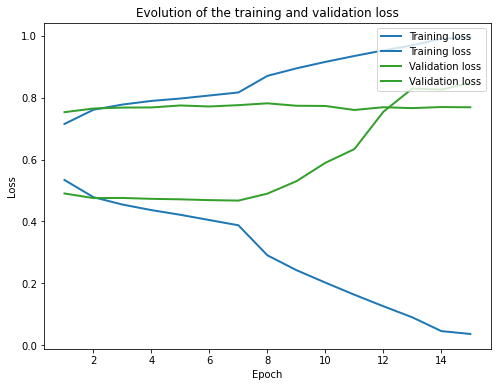

Best accuracy model basique :0.7688830212834054


In [92]:
#Ãpprentissage
history_tr=[]
history_te=[]
    
for epoch in range(nb_epochs):
    loss_train, acc_train = train( model, train_loader, optimizer, epoch, log_interval=10, criterion=criterion )
    history_tr.append((loss_train, acc_train))
    loss_val, acc_val = test( model, val_loader, epoch, criterion=criterion)
    history_te.append((loss_val, acc_val))
    if scheduler_type=='step':
        scheduler.step()
        print(scheduler._last_lr)
    if scheduler_type=='plateau':
        scheduler.step(acc_val)
        print(scheduler._last_lr)
    if save_model and epoch % save_epoch == 0:
        torch.save(model.state_dict(),'Conv_bn_data_augmentation_epoch_%s.pth' % (epoch))
    
print('Training Done')
plot_losses(history_tr, history_te)
print('Best accuracy model basique :{}'.format(history_te[-1][1]))

#### Résultats et conclusion

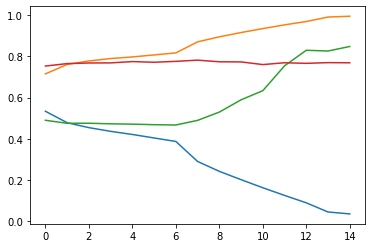

In [99]:
#Historique des courbes d'apprentissage.
plt.plot(history_tr)
plt.plot(history_te)

In [103]:
model=Conv_bn(num_classes, n_channels).to(device)
model.load_state_dict(torch.load('Conv_bn_data_augmentation_epoch_7.pth'))
model.eval()

# Performance en prédiction du modèle cnn basique 
pred_bool, labels, genres = predict_dataset(model, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men) 

Prediction complete
Accuracy_score général:  0.7816850543022156
Accuracy_score femme_0:  0.8207882642745972
Accuracy_score homme_1:  0.7266422510147095


On constate que le model overfit à partir de 6 epochs. J'ai donc décidé par la suite d'envisager:
<li> d'intégrer des couches de dropout dans le modèle
<li> de mettre en place une loss L2 via et de jouer sur le coefficient weight decay 
<li> de faire de la data augmentation et d'augmenter la qualité et la robustesse du dataset d'apprentissage  

### Approche 2 - lutte contre l'overfit

En conséquence en deuxième approche, j'ai donc tenté de réduire les phénomènes d'overfitting.

Le classifieur est identique au précédent à l'exception qu'il contient désormais des couches de dropout.

Le dataset d'apprentissage a fait l'objet de data augmentation comme du le renversement horizntal ou vertical des images, de la suppression de pixels, du changement de couleurs...

La loss comprend aussi une loss L2.

#### Data augmentation

In [78]:
#Caractéristics of data augmenation 
data_augmentation_tr = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.RandomErasing(p=0.1),
])

#### Modèle

In [79]:
class Conv_bn_dro_init(nn.Module):
    def __init__(self,num_classes, n_channels):
        super(Conv_bn_dro_init,self).__init__()
        self.layer1=nn.Sequential(nn.Conv2d(n_channels, 32, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2=nn.Sequential(nn.Conv2d(32, 64, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3=nn.Sequential(nn.Conv2d(64, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4=nn.Sequential(nn.Conv2d(128, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.fc=nn.Linear(5*5*128,512)
        self.fc1=nn.Linear(512,num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.zeros_(m.bias.data)
                
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=out.reshape(out.size(0),-1)
        out=F.dropout(out,p=0.5)
        out=self.fc(out)
        out=F.relu(out)
        out=F.dropout(out,p=0.5)
        out=self.fc1(out)
        return out

#### Apprentissage

In [32]:
#All the parameters
batch_size = 128
optimizer_type = "adam"
scheduler_type='plateau'
learning_rate = 1e-5
weight_decay = 2e-4
lr_decay_epochs = 6
lr_decay = 0.1
nb_epochs = 10
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
momentum = 0.9
n_channels = 3
num_classes = 2
save_model = True 
save_epoch = 1

In [33]:
#Loss
criterion = nn.CrossEntropyLoss()
#Model
model= Conv_bn_dro_init(num_classes, n_channels).to(device)
#Optimizer
if optimizer_type =='adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
if optimizer_type =='SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler
if scheduler_type=='step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs,gamma=lr_decay)
if scheduler_type=='plateau':   
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=lr_decay, patience=5, threshold=0.05,verbose=True)

Train Epoch: 0 [0/299966 (0%)]	Loss: 1.626140	Acc: 0.460938
Train Epoch: 0 [1280/299966 (0%)]	Loss: 2.689490	Acc: 0.531250
Train Epoch: 0 [2560/299966 (1%)]	Loss: 0.777387	Acc: 0.578125
Train Epoch: 0 [3840/299966 (1%)]	Loss: 0.730812	Acc: 0.460938
Train Epoch: 0 [5120/299966 (2%)]	Loss: 0.713965	Acc: 0.460938
Train Epoch: 0 [6400/299966 (2%)]	Loss: 0.743388	Acc: 0.406250
Train Epoch: 0 [7680/299966 (3%)]	Loss: 0.692341	Acc: 0.484375
Train Epoch: 0 [8960/299966 (3%)]	Loss: 0.687114	Acc: 0.554688
Train Epoch: 0 [10240/299966 (3%)]	Loss: 0.689342	Acc: 0.554688
Train Epoch: 0 [11520/299966 (4%)]	Loss: 0.682917	Acc: 0.554688
Train Epoch: 0 [12800/299966 (4%)]	Loss: 0.698976	Acc: 0.492188
Train Epoch: 0 [14080/299966 (5%)]	Loss: 0.683639	Acc: 0.578125
Train Epoch: 0 [15360/299966 (5%)]	Loss: 0.685773	Acc: 0.539062
Train Epoch: 0 [16640/299966 (6%)]	Loss: 0.684703	Acc: 0.546875
Train Epoch: 0 [17920/299966 (6%)]	Loss: 0.693490	Acc: 0.453125
Train Epoch: 0 [19200/299966 (6%)]	Loss: 0.688697	A

Train Epoch: 0 [161280/299966 (54%)]	Loss: 0.683970	Acc: 0.578125
Train Epoch: 0 [162560/299966 (54%)]	Loss: 0.710816	Acc: 0.453125
Train Epoch: 0 [163840/299966 (55%)]	Loss: 0.678445	Acc: 0.546875
Train Epoch: 0 [165120/299966 (55%)]	Loss: 0.688062	Acc: 0.515625
Train Epoch: 0 [166400/299966 (55%)]	Loss: 0.692337	Acc: 0.570312
Train Epoch: 0 [167680/299966 (56%)]	Loss: 0.687152	Acc: 0.554688
Train Epoch: 0 [168960/299966 (56%)]	Loss: 0.685353	Acc: 0.562500
Train Epoch: 0 [170240/299966 (57%)]	Loss: 0.688662	Acc: 0.546875
Train Epoch: 0 [171520/299966 (57%)]	Loss: 0.706215	Acc: 0.414062
Train Epoch: 0 [172800/299966 (58%)]	Loss: 0.693971	Acc: 0.500000
Train Epoch: 0 [174080/299966 (58%)]	Loss: 0.680205	Acc: 0.617188
Train Epoch: 0 [175360/299966 (58%)]	Loss: 0.691548	Acc: 0.570312
Train Epoch: 0 [176640/299966 (59%)]	Loss: 0.700019	Acc: 0.492188
Train Epoch: 0 [177920/299966 (59%)]	Loss: 0.694902	Acc: 0.492188
Train Epoch: 0 [179200/299966 (60%)]	Loss: 0.701288	Acc: 0.476562
Train Epoc

Train Epoch: 1 [19200/299966 (6%)]	Loss: 0.723441	Acc: 0.523438
Train Epoch: 1 [20480/299966 (7%)]	Loss: 0.688402	Acc: 0.515625
Train Epoch: 1 [21760/299966 (7%)]	Loss: 0.679116	Acc: 0.468750
Train Epoch: 1 [23040/299966 (8%)]	Loss: 0.698525	Acc: 0.507812
Train Epoch: 1 [24320/299966 (8%)]	Loss: 0.704831	Acc: 0.500000
Train Epoch: 1 [25600/299966 (9%)]	Loss: 0.685834	Acc: 0.562500
Train Epoch: 1 [26880/299966 (9%)]	Loss: 0.676989	Acc: 0.585938
Train Epoch: 1 [28160/299966 (9%)]	Loss: 0.693742	Acc: 0.468750
Train Epoch: 1 [29440/299966 (10%)]	Loss: 0.692024	Acc: 0.515625
Train Epoch: 1 [30720/299966 (10%)]	Loss: 0.716491	Acc: 0.437500
Train Epoch: 1 [32000/299966 (11%)]	Loss: 0.670749	Acc: 0.609375
Train Epoch: 1 [33280/299966 (11%)]	Loss: 0.693252	Acc: 0.515625
Train Epoch: 1 [34560/299966 (12%)]	Loss: 0.698411	Acc: 0.562500
Train Epoch: 1 [35840/299966 (12%)]	Loss: 0.689728	Acc: 0.515625
Train Epoch: 1 [37120/299966 (12%)]	Loss: 0.694324	Acc: 0.468750
Train Epoch: 1 [38400/299966 (13%

Train Epoch: 1 [180480/299966 (60%)]	Loss: 0.617150	Acc: 0.679688
Train Epoch: 1 [181760/299966 (61%)]	Loss: 0.653451	Acc: 0.601562
Train Epoch: 1 [183040/299966 (61%)]	Loss: 0.692840	Acc: 0.539062
Train Epoch: 1 [184320/299966 (61%)]	Loss: 0.653650	Acc: 0.601562
Train Epoch: 1 [185600/299966 (62%)]	Loss: 0.692380	Acc: 0.515625
Train Epoch: 1 [186880/299966 (62%)]	Loss: 0.679383	Acc: 0.601562
Train Epoch: 1 [188160/299966 (63%)]	Loss: 0.637608	Acc: 0.640625
Train Epoch: 1 [189440/299966 (63%)]	Loss: 0.695091	Acc: 0.570312
Train Epoch: 1 [190720/299966 (64%)]	Loss: 0.639507	Acc: 0.664062
Train Epoch: 1 [192000/299966 (64%)]	Loss: 0.661062	Acc: 0.640625
Train Epoch: 1 [193280/299966 (64%)]	Loss: 0.676929	Acc: 0.507812
Train Epoch: 1 [194560/299966 (65%)]	Loss: 0.641917	Acc: 0.609375
Train Epoch: 1 [195840/299966 (65%)]	Loss: 0.611805	Acc: 0.640625
Train Epoch: 1 [197120/299966 (66%)]	Loss: 0.671720	Acc: 0.539062
Train Epoch: 1 [198400/299966 (66%)]	Loss: 0.589818	Acc: 0.648438
Train Epoc

Train Epoch: 2 [38400/299966 (13%)]	Loss: 0.630440	Acc: 0.632812
Train Epoch: 2 [39680/299966 (13%)]	Loss: 0.608003	Acc: 0.640625
Train Epoch: 2 [40960/299966 (14%)]	Loss: 0.631151	Acc: 0.640625
Train Epoch: 2 [42240/299966 (14%)]	Loss: 0.621750	Acc: 0.632812
Train Epoch: 2 [43520/299966 (15%)]	Loss: 0.659715	Acc: 0.640625
Train Epoch: 2 [44800/299966 (15%)]	Loss: 0.597852	Acc: 0.664062
Train Epoch: 2 [46080/299966 (15%)]	Loss: 0.597257	Acc: 0.664062
Train Epoch: 2 [47360/299966 (16%)]	Loss: 0.601786	Acc: 0.679688
Train Epoch: 2 [48640/299966 (16%)]	Loss: 0.631072	Acc: 0.695312
Train Epoch: 2 [49920/299966 (17%)]	Loss: 0.621879	Acc: 0.664062
Train Epoch: 2 [51200/299966 (17%)]	Loss: 0.567729	Acc: 0.703125
Train Epoch: 2 [52480/299966 (17%)]	Loss: 0.599547	Acc: 0.656250
Train Epoch: 2 [53760/299966 (18%)]	Loss: 0.602270	Acc: 0.617188
Train Epoch: 2 [55040/299966 (18%)]	Loss: 0.602112	Acc: 0.648438
Train Epoch: 2 [56320/299966 (19%)]	Loss: 0.614807	Acc: 0.695312
Train Epoch: 2 [57600/299

Train Epoch: 2 [198400/299966 (66%)]	Loss: 0.608569	Acc: 0.664062
Train Epoch: 2 [199680/299966 (67%)]	Loss: 0.558428	Acc: 0.757812
Train Epoch: 2 [200960/299966 (67%)]	Loss: 0.622410	Acc: 0.625000
Train Epoch: 2 [202240/299966 (67%)]	Loss: 0.585507	Acc: 0.648438
Train Epoch: 2 [203520/299966 (68%)]	Loss: 0.559627	Acc: 0.679688
Train Epoch: 2 [204800/299966 (68%)]	Loss: 0.545447	Acc: 0.726562
Train Epoch: 2 [206080/299966 (69%)]	Loss: 0.570149	Acc: 0.640625
Train Epoch: 2 [207360/299966 (69%)]	Loss: 0.574192	Acc: 0.664062
Train Epoch: 2 [208640/299966 (70%)]	Loss: 0.623365	Acc: 0.640625
Train Epoch: 2 [209920/299966 (70%)]	Loss: 0.526200	Acc: 0.734375
Train Epoch: 2 [211200/299966 (70%)]	Loss: 0.616509	Acc: 0.671875
Train Epoch: 2 [212480/299966 (71%)]	Loss: 0.592090	Acc: 0.671875
Train Epoch: 2 [213760/299966 (71%)]	Loss: 0.591809	Acc: 0.664062
Train Epoch: 2 [215040/299966 (72%)]	Loss: 0.656226	Acc: 0.609375
Train Epoch: 2 [216320/299966 (72%)]	Loss: 0.645939	Acc: 0.671875
Train Epoc

Train Epoch: 3 [56320/299966 (19%)]	Loss: 0.566989	Acc: 0.687500
Train Epoch: 3 [57600/299966 (19%)]	Loss: 0.683434	Acc: 0.585938
Train Epoch: 3 [58880/299966 (20%)]	Loss: 0.612820	Acc: 0.687500
Train Epoch: 3 [60160/299966 (20%)]	Loss: 0.587517	Acc: 0.703125
Train Epoch: 3 [61440/299966 (20%)]	Loss: 0.590690	Acc: 0.656250
Train Epoch: 3 [62720/299966 (21%)]	Loss: 0.614959	Acc: 0.687500
Train Epoch: 3 [64000/299966 (21%)]	Loss: 0.607874	Acc: 0.687500
Train Epoch: 3 [65280/299966 (22%)]	Loss: 0.702249	Acc: 0.640625
Train Epoch: 3 [66560/299966 (22%)]	Loss: 0.561897	Acc: 0.757812
Train Epoch: 3 [67840/299966 (23%)]	Loss: 0.576041	Acc: 0.710938
Train Epoch: 3 [69120/299966 (23%)]	Loss: 0.564261	Acc: 0.718750
Train Epoch: 3 [70400/299966 (23%)]	Loss: 0.571914	Acc: 0.687500
Train Epoch: 3 [71680/299966 (24%)]	Loss: 0.538626	Acc: 0.710938
Train Epoch: 3 [72960/299966 (24%)]	Loss: 0.619935	Acc: 0.648438
Train Epoch: 3 [74240/299966 (25%)]	Loss: 0.564340	Acc: 0.664062
Train Epoch: 3 [75520/299

Train Epoch: 3 [216320/299966 (72%)]	Loss: 0.617298	Acc: 0.609375
Train Epoch: 3 [217600/299966 (73%)]	Loss: 0.607629	Acc: 0.679688
Train Epoch: 3 [218880/299966 (73%)]	Loss: 0.601151	Acc: 0.710938
Train Epoch: 3 [220160/299966 (73%)]	Loss: 0.566076	Acc: 0.757812
Train Epoch: 3 [221440/299966 (74%)]	Loss: 0.592673	Acc: 0.656250
Train Epoch: 3 [222720/299966 (74%)]	Loss: 0.603216	Acc: 0.679688
Train Epoch: 3 [224000/299966 (75%)]	Loss: 0.571805	Acc: 0.648438
Train Epoch: 3 [225280/299966 (75%)]	Loss: 0.574119	Acc: 0.679688
Train Epoch: 3 [226560/299966 (76%)]	Loss: 0.620475	Acc: 0.625000
Train Epoch: 3 [227840/299966 (76%)]	Loss: 0.587586	Acc: 0.671875
Train Epoch: 3 [229120/299966 (76%)]	Loss: 0.598731	Acc: 0.679688
Train Epoch: 3 [230400/299966 (77%)]	Loss: 0.622159	Acc: 0.679688
Train Epoch: 3 [231680/299966 (77%)]	Loss: 0.638416	Acc: 0.656250
Train Epoch: 3 [232960/299966 (78%)]	Loss: 0.587973	Acc: 0.656250
Train Epoch: 3 [234240/299966 (78%)]	Loss: 0.578419	Acc: 0.687500
Train Epoc

Train Epoch: 4 [74240/299966 (25%)]	Loss: 0.648762	Acc: 0.585938
Train Epoch: 4 [75520/299966 (25%)]	Loss: 0.578982	Acc: 0.664062
Train Epoch: 4 [76800/299966 (26%)]	Loss: 0.566395	Acc: 0.656250
Train Epoch: 4 [78080/299966 (26%)]	Loss: 0.522797	Acc: 0.757812
Train Epoch: 4 [79360/299966 (26%)]	Loss: 0.673318	Acc: 0.625000
Train Epoch: 4 [80640/299966 (27%)]	Loss: 0.646764	Acc: 0.593750
Train Epoch: 4 [81920/299966 (27%)]	Loss: 0.555640	Acc: 0.742188
Train Epoch: 4 [83200/299966 (28%)]	Loss: 0.665539	Acc: 0.664062
Train Epoch: 4 [84480/299966 (28%)]	Loss: 0.636107	Acc: 0.671875
Train Epoch: 4 [85760/299966 (29%)]	Loss: 0.593459	Acc: 0.703125
Train Epoch: 4 [87040/299966 (29%)]	Loss: 0.530935	Acc: 0.726562
Train Epoch: 4 [88320/299966 (29%)]	Loss: 0.610013	Acc: 0.625000
Train Epoch: 4 [89600/299966 (30%)]	Loss: 0.651179	Acc: 0.671875
Train Epoch: 4 [90880/299966 (30%)]	Loss: 0.554020	Acc: 0.710938
Train Epoch: 4 [92160/299966 (31%)]	Loss: 0.591499	Acc: 0.640625
Train Epoch: 4 [93440/299

Train Epoch: 4 [234240/299966 (78%)]	Loss: 0.486678	Acc: 0.773438
Train Epoch: 4 [235520/299966 (78%)]	Loss: 0.540339	Acc: 0.710938
Train Epoch: 4 [236800/299966 (79%)]	Loss: 0.589702	Acc: 0.664062
Train Epoch: 4 [238080/299966 (79%)]	Loss: 0.613615	Acc: 0.687500
Train Epoch: 4 [239360/299966 (80%)]	Loss: 0.575956	Acc: 0.664062
Train Epoch: 4 [240640/299966 (80%)]	Loss: 0.569747	Acc: 0.718750
Train Epoch: 4 [241920/299966 (81%)]	Loss: 0.580748	Acc: 0.648438
Train Epoch: 4 [243200/299966 (81%)]	Loss: 0.642259	Acc: 0.625000
Train Epoch: 4 [244480/299966 (81%)]	Loss: 0.536217	Acc: 0.742188
Train Epoch: 4 [245760/299966 (82%)]	Loss: 0.549262	Acc: 0.703125
Train Epoch: 4 [247040/299966 (82%)]	Loss: 0.518071	Acc: 0.726562
Train Epoch: 4 [248320/299966 (83%)]	Loss: 0.544613	Acc: 0.679688
Train Epoch: 4 [249600/299966 (83%)]	Loss: 0.603201	Acc: 0.671875
Train Epoch: 4 [250880/299966 (84%)]	Loss: 0.564841	Acc: 0.679688
Train Epoch: 4 [252160/299966 (84%)]	Loss: 0.504078	Acc: 0.726562
Train Epoc

Train Epoch: 5 [93440/299966 (31%)]	Loss: 0.670392	Acc: 0.640625
Train Epoch: 5 [94720/299966 (32%)]	Loss: 0.566722	Acc: 0.679688
Train Epoch: 5 [96000/299966 (32%)]	Loss: 0.528229	Acc: 0.734375
Train Epoch: 5 [97280/299966 (32%)]	Loss: 0.644799	Acc: 0.656250
Train Epoch: 5 [98560/299966 (33%)]	Loss: 0.577856	Acc: 0.718750
Train Epoch: 5 [99840/299966 (33%)]	Loss: 0.628281	Acc: 0.679688
Train Epoch: 5 [101120/299966 (34%)]	Loss: 0.608290	Acc: 0.648438
Train Epoch: 5 [102400/299966 (34%)]	Loss: 0.541572	Acc: 0.703125
Train Epoch: 5 [103680/299966 (35%)]	Loss: 0.589958	Acc: 0.710938
Train Epoch: 5 [104960/299966 (35%)]	Loss: 0.554694	Acc: 0.656250
Train Epoch: 5 [106240/299966 (35%)]	Loss: 0.557014	Acc: 0.664062
Train Epoch: 5 [107520/299966 (36%)]	Loss: 0.571283	Acc: 0.656250
Train Epoch: 5 [108800/299966 (36%)]	Loss: 0.582714	Acc: 0.640625
Train Epoch: 5 [110080/299966 (37%)]	Loss: 0.625616	Acc: 0.679688
Train Epoch: 5 [111360/299966 (37%)]	Loss: 0.542585	Acc: 0.773438
Train Epoch: 5 [

Train Epoch: 5 [253440/299966 (84%)]	Loss: 0.574525	Acc: 0.734375
Train Epoch: 5 [254720/299966 (85%)]	Loss: 0.617183	Acc: 0.703125
Train Epoch: 5 [256000/299966 (85%)]	Loss: 0.593276	Acc: 0.679688
Train Epoch: 5 [257280/299966 (86%)]	Loss: 0.595066	Acc: 0.601562
Train Epoch: 5 [258560/299966 (86%)]	Loss: 0.592426	Acc: 0.703125
Train Epoch: 5 [259840/299966 (87%)]	Loss: 0.554052	Acc: 0.703125
Train Epoch: 5 [261120/299966 (87%)]	Loss: 0.627945	Acc: 0.679688
Train Epoch: 5 [262400/299966 (87%)]	Loss: 0.516164	Acc: 0.726562
Train Epoch: 5 [263680/299966 (88%)]	Loss: 0.672385	Acc: 0.695312
Train Epoch: 5 [264960/299966 (88%)]	Loss: 0.641200	Acc: 0.648438
Train Epoch: 5 [266240/299966 (89%)]	Loss: 0.528454	Acc: 0.695312
Train Epoch: 5 [267520/299966 (89%)]	Loss: 0.617784	Acc: 0.648438
Train Epoch: 5 [268800/299966 (90%)]	Loss: 0.581239	Acc: 0.664062
Train Epoch: 5 [270080/299966 (90%)]	Loss: 0.491209	Acc: 0.773438
Train Epoch: 5 [271360/299966 (90%)]	Loss: 0.599749	Acc: 0.664062
Train Epoc

Train Epoch: 6 [112640/299966 (38%)]	Loss: 0.625420	Acc: 0.640625
Train Epoch: 6 [113920/299966 (38%)]	Loss: 0.621580	Acc: 0.648438
Train Epoch: 6 [115200/299966 (38%)]	Loss: 0.514046	Acc: 0.703125
Train Epoch: 6 [116480/299966 (39%)]	Loss: 0.581173	Acc: 0.656250
Train Epoch: 6 [117760/299966 (39%)]	Loss: 0.597469	Acc: 0.640625
Train Epoch: 6 [119040/299966 (40%)]	Loss: 0.590788	Acc: 0.679688
Train Epoch: 6 [120320/299966 (40%)]	Loss: 0.630709	Acc: 0.617188
Train Epoch: 6 [121600/299966 (41%)]	Loss: 0.662837	Acc: 0.609375
Train Epoch: 6 [122880/299966 (41%)]	Loss: 0.560114	Acc: 0.632812
Train Epoch: 6 [124160/299966 (41%)]	Loss: 0.545316	Acc: 0.679688
Train Epoch: 6 [125440/299966 (42%)]	Loss: 0.595478	Acc: 0.609375
Train Epoch: 6 [126720/299966 (42%)]	Loss: 0.623651	Acc: 0.648438
Train Epoch: 6 [128000/299966 (43%)]	Loss: 0.579197	Acc: 0.734375
Train Epoch: 6 [129280/299966 (43%)]	Loss: 0.482797	Acc: 0.726562
Train Epoch: 6 [130560/299966 (44%)]	Loss: 0.582817	Acc: 0.679688
Train Epoc

Train Epoch: 6 [272640/299966 (91%)]	Loss: 0.592567	Acc: 0.710938
Train Epoch: 6 [273920/299966 (91%)]	Loss: 0.604351	Acc: 0.695312
Train Epoch: 6 [275200/299966 (92%)]	Loss: 0.584853	Acc: 0.664062
Train Epoch: 6 [276480/299966 (92%)]	Loss: 0.540028	Acc: 0.742188
Train Epoch: 6 [277760/299966 (93%)]	Loss: 0.595419	Acc: 0.671875
Train Epoch: 6 [279040/299966 (93%)]	Loss: 0.605110	Acc: 0.679688
Train Epoch: 6 [280320/299966 (93%)]	Loss: 0.645550	Acc: 0.671875
Train Epoch: 6 [281600/299966 (94%)]	Loss: 0.593513	Acc: 0.625000
Train Epoch: 6 [282880/299966 (94%)]	Loss: 0.607257	Acc: 0.648438
Train Epoch: 6 [284160/299966 (95%)]	Loss: 0.576371	Acc: 0.726562
Train Epoch: 6 [285440/299966 (95%)]	Loss: 0.516534	Acc: 0.710938
Train Epoch: 6 [286720/299966 (96%)]	Loss: 0.557430	Acc: 0.742188
Train Epoch: 6 [288000/299966 (96%)]	Loss: 0.523777	Acc: 0.718750
Train Epoch: 6 [289280/299966 (96%)]	Loss: 0.587333	Acc: 0.679688
Train Epoch: 6 [290560/299966 (97%)]	Loss: 0.601482	Acc: 0.671875
Train Epoc

Train Epoch: 7 [131840/299966 (44%)]	Loss: 0.598384	Acc: 0.703125
Train Epoch: 7 [133120/299966 (44%)]	Loss: 0.555911	Acc: 0.718750
Train Epoch: 7 [134400/299966 (45%)]	Loss: 0.576657	Acc: 0.671875
Train Epoch: 7 [135680/299966 (45%)]	Loss: 0.638658	Acc: 0.648438
Train Epoch: 7 [136960/299966 (46%)]	Loss: 0.590176	Acc: 0.664062
Train Epoch: 7 [138240/299966 (46%)]	Loss: 0.526490	Acc: 0.781250
Train Epoch: 7 [139520/299966 (47%)]	Loss: 0.600004	Acc: 0.632812
Train Epoch: 7 [140800/299966 (47%)]	Loss: 0.681995	Acc: 0.609375
Train Epoch: 7 [142080/299966 (47%)]	Loss: 0.573553	Acc: 0.671875
Train Epoch: 7 [143360/299966 (48%)]	Loss: 0.572864	Acc: 0.664062
Train Epoch: 7 [144640/299966 (48%)]	Loss: 0.579413	Acc: 0.687500
Train Epoch: 7 [145920/299966 (49%)]	Loss: 0.598181	Acc: 0.695312
Train Epoch: 7 [147200/299966 (49%)]	Loss: 0.631238	Acc: 0.617188
Train Epoch: 7 [148480/299966 (49%)]	Loss: 0.623990	Acc: 0.679688
Train Epoch: 7 [149760/299966 (50%)]	Loss: 0.530839	Acc: 0.742188
Train Epoc

Train Epoch: 7 [291840/299966 (97%)]	Loss: 0.592098	Acc: 0.679688
Train Epoch: 7 [293120/299966 (98%)]	Loss: 0.578165	Acc: 0.718750
Train Epoch: 7 [294400/299966 (98%)]	Loss: 0.598318	Acc: 0.632812
Train Epoch: 7 [295680/299966 (99%)]	Loss: 0.600828	Acc: 0.664062
Train Epoch: 7 [296960/299966 (99%)]	Loss: 0.537188	Acc: 0.734375
Train Epoch: 7 [298240/299966 (99%)]	Loss: 0.564570	Acc: 0.710938
Train Epoch: 7 [299520/299966 (100%)]	Loss: 0.526876	Acc: 0.765625
Train Epoch: 7 \LOSS: 0.576784 \Accuracy: 0.689058
Test Epoch: 7 \LOSS: 0.629063 \Accuracy: 0.637742
Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
[0.001]
Train Epoch: 8 [0/299966 (0%)]	Loss: 0.592974	Acc: 0.671875
Train Epoch: 8 [1280/299966 (0%)]	Loss: 0.647635	Acc: 0.640625
Train Epoch: 8 [2560/299966 (1%)]	Loss: 0.625082	Acc: 0.656250
Train Epoch: 8 [3840/299966 (1%)]	Loss: 0.569870	Acc: 0.687500
Train Epoch: 8 [5120/299966 (2%)]	Loss: 0.543589	Acc: 0.804688
Train Epoch: 8 [6400/299966 (2%)]	Loss: 0.520413	Acc: 

Train Epoch: 8 [149760/299966 (50%)]	Loss: 0.517560	Acc: 0.687500
Train Epoch: 8 [151040/299966 (50%)]	Loss: 0.557727	Acc: 0.687500
Train Epoch: 8 [152320/299966 (51%)]	Loss: 0.512170	Acc: 0.726562
Train Epoch: 8 [153600/299966 (51%)]	Loss: 0.568212	Acc: 0.726562
Train Epoch: 8 [154880/299966 (52%)]	Loss: 0.564053	Acc: 0.703125
Train Epoch: 8 [156160/299966 (52%)]	Loss: 0.529332	Acc: 0.718750
Train Epoch: 8 [157440/299966 (52%)]	Loss: 0.552961	Acc: 0.687500
Train Epoch: 8 [158720/299966 (53%)]	Loss: 0.570119	Acc: 0.687500
Train Epoch: 8 [160000/299966 (53%)]	Loss: 0.539371	Acc: 0.734375
Train Epoch: 8 [161280/299966 (54%)]	Loss: 0.533781	Acc: 0.750000
Train Epoch: 8 [162560/299966 (54%)]	Loss: 0.532826	Acc: 0.750000
Train Epoch: 8 [163840/299966 (55%)]	Loss: 0.576605	Acc: 0.664062
Train Epoch: 8 [165120/299966 (55%)]	Loss: 0.578087	Acc: 0.718750
Train Epoch: 8 [166400/299966 (55%)]	Loss: 0.558038	Acc: 0.679688
Train Epoch: 8 [167680/299966 (56%)]	Loss: 0.597914	Acc: 0.656250
Train Epoc

Train Epoch: 9 [6400/299966 (2%)]	Loss: 0.520642	Acc: 0.718750
Train Epoch: 9 [7680/299966 (3%)]	Loss: 0.576626	Acc: 0.656250
Train Epoch: 9 [8960/299966 (3%)]	Loss: 0.553686	Acc: 0.695312
Train Epoch: 9 [10240/299966 (3%)]	Loss: 0.534449	Acc: 0.687500
Train Epoch: 9 [11520/299966 (4%)]	Loss: 0.545707	Acc: 0.695312
Train Epoch: 9 [12800/299966 (4%)]	Loss: 0.572143	Acc: 0.679688
Train Epoch: 9 [14080/299966 (5%)]	Loss: 0.548154	Acc: 0.687500
Train Epoch: 9 [15360/299966 (5%)]	Loss: 0.571853	Acc: 0.695312
Train Epoch: 9 [16640/299966 (6%)]	Loss: 0.565496	Acc: 0.703125
Train Epoch: 9 [17920/299966 (6%)]	Loss: 0.544834	Acc: 0.742188
Train Epoch: 9 [19200/299966 (6%)]	Loss: 0.543959	Acc: 0.734375
Train Epoch: 9 [20480/299966 (7%)]	Loss: 0.525023	Acc: 0.726562
Train Epoch: 9 [21760/299966 (7%)]	Loss: 0.506085	Acc: 0.750000
Train Epoch: 9 [23040/299966 (8%)]	Loss: 0.569430	Acc: 0.648438
Train Epoch: 9 [24320/299966 (8%)]	Loss: 0.515888	Acc: 0.710938
Train Epoch: 9 [25600/299966 (9%)]	Loss: 0.

Train Epoch: 9 [167680/299966 (56%)]	Loss: 0.509929	Acc: 0.726562
Train Epoch: 9 [168960/299966 (56%)]	Loss: 0.571193	Acc: 0.687500
Train Epoch: 9 [170240/299966 (57%)]	Loss: 0.550666	Acc: 0.695312
Train Epoch: 9 [171520/299966 (57%)]	Loss: 0.564983	Acc: 0.656250
Train Epoch: 9 [172800/299966 (58%)]	Loss: 0.563583	Acc: 0.718750
Train Epoch: 9 [174080/299966 (58%)]	Loss: 0.545262	Acc: 0.687500
Train Epoch: 9 [175360/299966 (58%)]	Loss: 0.523955	Acc: 0.710938
Train Epoch: 9 [176640/299966 (59%)]	Loss: 0.534644	Acc: 0.710938
Train Epoch: 9 [177920/299966 (59%)]	Loss: 0.554984	Acc: 0.710938
Train Epoch: 9 [179200/299966 (60%)]	Loss: 0.556603	Acc: 0.710938
Train Epoch: 9 [180480/299966 (60%)]	Loss: 0.494913	Acc: 0.687500
Train Epoch: 9 [181760/299966 (61%)]	Loss: 0.616399	Acc: 0.710938
Train Epoch: 9 [183040/299966 (61%)]	Loss: 0.565055	Acc: 0.695312
Train Epoch: 9 [184320/299966 (61%)]	Loss: 0.551206	Acc: 0.726562
Train Epoch: 9 [185600/299966 (62%)]	Loss: 0.584167	Acc: 0.687500
Train Epoc

Train Epoch: 10 [24320/299966 (8%)]	Loss: 0.547393	Acc: 0.671875
Train Epoch: 10 [25600/299966 (9%)]	Loss: 0.538974	Acc: 0.695312
Train Epoch: 10 [26880/299966 (9%)]	Loss: 0.541523	Acc: 0.710938
Train Epoch: 10 [28160/299966 (9%)]	Loss: 0.589607	Acc: 0.671875
Train Epoch: 10 [29440/299966 (10%)]	Loss: 0.548525	Acc: 0.679688
Train Epoch: 10 [30720/299966 (10%)]	Loss: 0.644383	Acc: 0.640625
Train Epoch: 10 [32000/299966 (11%)]	Loss: 0.481979	Acc: 0.773438
Train Epoch: 10 [33280/299966 (11%)]	Loss: 0.490997	Acc: 0.695312
Train Epoch: 10 [34560/299966 (12%)]	Loss: 0.483117	Acc: 0.804688
Train Epoch: 10 [35840/299966 (12%)]	Loss: 0.507592	Acc: 0.726562
Train Epoch: 10 [37120/299966 (12%)]	Loss: 0.603947	Acc: 0.648438
Train Epoch: 10 [38400/299966 (13%)]	Loss: 0.601907	Acc: 0.679688
Train Epoch: 10 [39680/299966 (13%)]	Loss: 0.520886	Acc: 0.726562
Train Epoch: 10 [40960/299966 (14%)]	Loss: 0.602902	Acc: 0.585938
Train Epoch: 10 [42240/299966 (14%)]	Loss: 0.584631	Acc: 0.648438
Train Epoch: 1

Train Epoch: 10 [183040/299966 (61%)]	Loss: 0.486238	Acc: 0.765625
Train Epoch: 10 [184320/299966 (61%)]	Loss: 0.554578	Acc: 0.703125
Train Epoch: 10 [185600/299966 (62%)]	Loss: 0.587955	Acc: 0.664062
Train Epoch: 10 [186880/299966 (62%)]	Loss: 0.549844	Acc: 0.687500
Train Epoch: 10 [188160/299966 (63%)]	Loss: 0.561708	Acc: 0.687500
Train Epoch: 10 [189440/299966 (63%)]	Loss: 0.564668	Acc: 0.679688
Train Epoch: 10 [190720/299966 (64%)]	Loss: 0.508297	Acc: 0.726562
Train Epoch: 10 [192000/299966 (64%)]	Loss: 0.554945	Acc: 0.742188
Train Epoch: 10 [193280/299966 (64%)]	Loss: 0.662902	Acc: 0.664062
Train Epoch: 10 [194560/299966 (65%)]	Loss: 0.546738	Acc: 0.671875
Train Epoch: 10 [195840/299966 (65%)]	Loss: 0.526873	Acc: 0.703125
Train Epoch: 10 [197120/299966 (66%)]	Loss: 0.522036	Acc: 0.695312
Train Epoch: 10 [198400/299966 (66%)]	Loss: 0.569475	Acc: 0.625000
Train Epoch: 10 [199680/299966 (67%)]	Loss: 0.536967	Acc: 0.750000
Train Epoch: 10 [200960/299966 (67%)]	Loss: 0.554927	Acc: 0.72

Train Epoch: 11 [38400/299966 (13%)]	Loss: 0.597262	Acc: 0.703125
Train Epoch: 11 [39680/299966 (13%)]	Loss: 0.571205	Acc: 0.718750
Train Epoch: 11 [40960/299966 (14%)]	Loss: 0.559022	Acc: 0.703125
Train Epoch: 11 [42240/299966 (14%)]	Loss: 0.578662	Acc: 0.687500
Train Epoch: 11 [43520/299966 (15%)]	Loss: 0.462950	Acc: 0.742188
Train Epoch: 11 [44800/299966 (15%)]	Loss: 0.504626	Acc: 0.781250
Train Epoch: 11 [46080/299966 (15%)]	Loss: 0.632083	Acc: 0.632812
Train Epoch: 11 [47360/299966 (16%)]	Loss: 0.535592	Acc: 0.687500
Train Epoch: 11 [48640/299966 (16%)]	Loss: 0.598293	Acc: 0.625000
Train Epoch: 11 [49920/299966 (17%)]	Loss: 0.551670	Acc: 0.671875
Train Epoch: 11 [51200/299966 (17%)]	Loss: 0.528966	Acc: 0.718750
Train Epoch: 11 [52480/299966 (17%)]	Loss: 0.559500	Acc: 0.734375
Train Epoch: 11 [53760/299966 (18%)]	Loss: 0.545782	Acc: 0.750000
Train Epoch: 11 [55040/299966 (18%)]	Loss: 0.594888	Acc: 0.625000
Train Epoch: 11 [56320/299966 (19%)]	Loss: 0.522845	Acc: 0.664062
Train Epoc

Train Epoch: 11 [197120/299966 (66%)]	Loss: 0.535623	Acc: 0.703125
Train Epoch: 11 [198400/299966 (66%)]	Loss: 0.525995	Acc: 0.703125
Train Epoch: 11 [199680/299966 (67%)]	Loss: 0.520722	Acc: 0.710938
Train Epoch: 11 [200960/299966 (67%)]	Loss: 0.503288	Acc: 0.710938
Train Epoch: 11 [202240/299966 (67%)]	Loss: 0.466975	Acc: 0.750000
Train Epoch: 11 [203520/299966 (68%)]	Loss: 0.513134	Acc: 0.664062
Train Epoch: 11 [204800/299966 (68%)]	Loss: 0.618260	Acc: 0.648438
Train Epoch: 11 [206080/299966 (69%)]	Loss: 0.527979	Acc: 0.726562
Train Epoch: 11 [207360/299966 (69%)]	Loss: 0.494305	Acc: 0.742188
Train Epoch: 11 [208640/299966 (70%)]	Loss: 0.546253	Acc: 0.703125
Train Epoch: 11 [209920/299966 (70%)]	Loss: 0.511464	Acc: 0.757812
Train Epoch: 11 [211200/299966 (70%)]	Loss: 0.543880	Acc: 0.750000
Train Epoch: 11 [212480/299966 (71%)]	Loss: 0.494389	Acc: 0.710938
Train Epoch: 11 [213760/299966 (71%)]	Loss: 0.546024	Acc: 0.648438
Train Epoch: 11 [215040/299966 (72%)]	Loss: 0.511154	Acc: 0.75

Train Epoch: 12 [52480/299966 (17%)]	Loss: 0.476738	Acc: 0.757812
Train Epoch: 12 [53760/299966 (18%)]	Loss: 0.529967	Acc: 0.726562
Train Epoch: 12 [55040/299966 (18%)]	Loss: 0.547975	Acc: 0.664062
Train Epoch: 12 [56320/299966 (19%)]	Loss: 0.517681	Acc: 0.765625
Train Epoch: 12 [57600/299966 (19%)]	Loss: 0.528353	Acc: 0.765625
Train Epoch: 12 [58880/299966 (20%)]	Loss: 0.554863	Acc: 0.695312
Train Epoch: 12 [60160/299966 (20%)]	Loss: 0.606675	Acc: 0.671875
Train Epoch: 12 [61440/299966 (20%)]	Loss: 0.517206	Acc: 0.718750
Train Epoch: 12 [62720/299966 (21%)]	Loss: 0.498994	Acc: 0.718750
Train Epoch: 12 [64000/299966 (21%)]	Loss: 0.566479	Acc: 0.679688
Train Epoch: 12 [65280/299966 (22%)]	Loss: 0.463371	Acc: 0.781250
Train Epoch: 12 [66560/299966 (22%)]	Loss: 0.550519	Acc: 0.703125
Train Epoch: 12 [67840/299966 (23%)]	Loss: 0.589314	Acc: 0.703125
Train Epoch: 12 [69120/299966 (23%)]	Loss: 0.512202	Acc: 0.718750
Train Epoch: 12 [70400/299966 (23%)]	Loss: 0.524274	Acc: 0.742188
Train Epoc

Train Epoch: 12 [209920/299966 (70%)]	Loss: 0.514457	Acc: 0.718750
Train Epoch: 12 [211200/299966 (70%)]	Loss: 0.496649	Acc: 0.773438
Train Epoch: 12 [212480/299966 (71%)]	Loss: 0.515666	Acc: 0.703125
Train Epoch: 12 [213760/299966 (71%)]	Loss: 0.517166	Acc: 0.757812
Train Epoch: 12 [215040/299966 (72%)]	Loss: 0.582973	Acc: 0.656250
Train Epoch: 12 [216320/299966 (72%)]	Loss: 0.555115	Acc: 0.664062
Train Epoch: 12 [217600/299966 (73%)]	Loss: 0.515547	Acc: 0.710938
Train Epoch: 12 [218880/299966 (73%)]	Loss: 0.568200	Acc: 0.679688
Train Epoch: 12 [220160/299966 (73%)]	Loss: 0.541588	Acc: 0.695312
Train Epoch: 12 [221440/299966 (74%)]	Loss: 0.454425	Acc: 0.781250
Train Epoch: 12 [222720/299966 (74%)]	Loss: 0.543205	Acc: 0.726562
Train Epoch: 12 [224000/299966 (75%)]	Loss: 0.558077	Acc: 0.664062
Train Epoch: 12 [225280/299966 (75%)]	Loss: 0.537180	Acc: 0.710938
Train Epoch: 12 [226560/299966 (76%)]	Loss: 0.595494	Acc: 0.695312
Train Epoch: 12 [227840/299966 (76%)]	Loss: 0.487680	Acc: 0.80

Train Epoch: 13 [65280/299966 (22%)]	Loss: 0.517397	Acc: 0.695312
Train Epoch: 13 [66560/299966 (22%)]	Loss: 0.557859	Acc: 0.679688
Train Epoch: 13 [67840/299966 (23%)]	Loss: 0.532979	Acc: 0.742188
Train Epoch: 13 [69120/299966 (23%)]	Loss: 0.549032	Acc: 0.679688
Train Epoch: 13 [70400/299966 (23%)]	Loss: 0.442702	Acc: 0.773438
Train Epoch: 13 [71680/299966 (24%)]	Loss: 0.504214	Acc: 0.734375
Train Epoch: 13 [72960/299966 (24%)]	Loss: 0.579081	Acc: 0.656250
Train Epoch: 13 [74240/299966 (25%)]	Loss: 0.561283	Acc: 0.734375
Train Epoch: 13 [75520/299966 (25%)]	Loss: 0.568027	Acc: 0.773438
Train Epoch: 13 [76800/299966 (26%)]	Loss: 0.587873	Acc: 0.695312
Train Epoch: 13 [78080/299966 (26%)]	Loss: 0.626557	Acc: 0.664062
Train Epoch: 13 [79360/299966 (26%)]	Loss: 0.511636	Acc: 0.718750
Train Epoch: 13 [80640/299966 (27%)]	Loss: 0.548617	Acc: 0.695312
Train Epoch: 13 [81920/299966 (27%)]	Loss: 0.515661	Acc: 0.734375
Train Epoch: 13 [83200/299966 (28%)]	Loss: 0.485316	Acc: 0.750000
Train Epoc

Train Epoch: 13 [222720/299966 (74%)]	Loss: 0.585650	Acc: 0.656250
Train Epoch: 13 [224000/299966 (75%)]	Loss: 0.526202	Acc: 0.726562
Train Epoch: 13 [225280/299966 (75%)]	Loss: 0.560175	Acc: 0.695312
Train Epoch: 13 [226560/299966 (76%)]	Loss: 0.519171	Acc: 0.757812
Train Epoch: 13 [227840/299966 (76%)]	Loss: 0.515775	Acc: 0.742188
Train Epoch: 13 [229120/299966 (76%)]	Loss: 0.561132	Acc: 0.679688
Train Epoch: 13 [230400/299966 (77%)]	Loss: 0.520725	Acc: 0.757812
Train Epoch: 13 [231680/299966 (77%)]	Loss: 0.556559	Acc: 0.726562
Train Epoch: 13 [232960/299966 (78%)]	Loss: 0.589120	Acc: 0.671875
Train Epoch: 13 [234240/299966 (78%)]	Loss: 0.553895	Acc: 0.734375
Train Epoch: 13 [235520/299966 (78%)]	Loss: 0.463975	Acc: 0.742188
Train Epoch: 13 [236800/299966 (79%)]	Loss: 0.465245	Acc: 0.804688
Train Epoch: 13 [238080/299966 (79%)]	Loss: 0.495988	Acc: 0.742188
Train Epoch: 13 [239360/299966 (80%)]	Loss: 0.569535	Acc: 0.695312
Train Epoch: 13 [240640/299966 (80%)]	Loss: 0.570353	Acc: 0.67

Train Epoch: 14 [78080/299966 (26%)]	Loss: 0.519196	Acc: 0.726562
Train Epoch: 14 [79360/299966 (26%)]	Loss: 0.463065	Acc: 0.781250
Train Epoch: 14 [80640/299966 (27%)]	Loss: 0.572552	Acc: 0.671875
Train Epoch: 14 [81920/299966 (27%)]	Loss: 0.527881	Acc: 0.679688
Train Epoch: 14 [83200/299966 (28%)]	Loss: 0.575470	Acc: 0.640625
Train Epoch: 14 [84480/299966 (28%)]	Loss: 0.532546	Acc: 0.734375
Train Epoch: 14 [85760/299966 (29%)]	Loss: 0.589891	Acc: 0.625000
Train Epoch: 14 [87040/299966 (29%)]	Loss: 0.496259	Acc: 0.750000
Train Epoch: 14 [88320/299966 (29%)]	Loss: 0.530744	Acc: 0.765625
Train Epoch: 14 [89600/299966 (30%)]	Loss: 0.491771	Acc: 0.757812
Train Epoch: 14 [90880/299966 (30%)]	Loss: 0.615985	Acc: 0.648438
Train Epoch: 14 [92160/299966 (31%)]	Loss: 0.509318	Acc: 0.710938
Train Epoch: 14 [93440/299966 (31%)]	Loss: 0.551355	Acc: 0.710938
Train Epoch: 14 [94720/299966 (32%)]	Loss: 0.497343	Acc: 0.718750
Train Epoch: 14 [96000/299966 (32%)]	Loss: 0.561140	Acc: 0.664062
Train Epoc

Train Epoch: 14 [235520/299966 (78%)]	Loss: 0.511720	Acc: 0.796875
Train Epoch: 14 [236800/299966 (79%)]	Loss: 0.542802	Acc: 0.726562
Train Epoch: 14 [238080/299966 (79%)]	Loss: 0.561550	Acc: 0.648438
Train Epoch: 14 [239360/299966 (80%)]	Loss: 0.544659	Acc: 0.726562
Train Epoch: 14 [240640/299966 (80%)]	Loss: 0.447675	Acc: 0.742188
Train Epoch: 14 [241920/299966 (81%)]	Loss: 0.493679	Acc: 0.734375
Train Epoch: 14 [243200/299966 (81%)]	Loss: 0.500284	Acc: 0.789062
Train Epoch: 14 [244480/299966 (81%)]	Loss: 0.491710	Acc: 0.757812
Train Epoch: 14 [245760/299966 (82%)]	Loss: 0.504641	Acc: 0.679688
Train Epoch: 14 [247040/299966 (82%)]	Loss: 0.588837	Acc: 0.671875
Train Epoch: 14 [248320/299966 (83%)]	Loss: 0.525389	Acc: 0.703125
Train Epoch: 14 [249600/299966 (83%)]	Loss: 0.561974	Acc: 0.640625
Train Epoch: 14 [250880/299966 (84%)]	Loss: 0.473458	Acc: 0.757812
Train Epoch: 14 [252160/299966 (84%)]	Loss: 0.551090	Acc: 0.695312
Train Epoch: 14 [253440/299966 (84%)]	Loss: 0.561133	Acc: 0.74

Train Epoch: 15 [92160/299966 (31%)]	Loss: 0.615609	Acc: 0.687500
Train Epoch: 15 [93440/299966 (31%)]	Loss: 0.618917	Acc: 0.664062
Train Epoch: 15 [94720/299966 (32%)]	Loss: 0.520211	Acc: 0.750000
Train Epoch: 15 [96000/299966 (32%)]	Loss: 0.520133	Acc: 0.734375
Train Epoch: 15 [97280/299966 (32%)]	Loss: 0.461383	Acc: 0.789062
Train Epoch: 15 [98560/299966 (33%)]	Loss: 0.450550	Acc: 0.750000
Train Epoch: 15 [99840/299966 (33%)]	Loss: 0.463363	Acc: 0.773438
Train Epoch: 15 [101120/299966 (34%)]	Loss: 0.558281	Acc: 0.617188
Train Epoch: 15 [102400/299966 (34%)]	Loss: 0.600695	Acc: 0.656250
Train Epoch: 15 [103680/299966 (35%)]	Loss: 0.550615	Acc: 0.671875
Train Epoch: 15 [104960/299966 (35%)]	Loss: 0.602699	Acc: 0.656250
Train Epoch: 15 [106240/299966 (35%)]	Loss: 0.509818	Acc: 0.718750
Train Epoch: 15 [107520/299966 (36%)]	Loss: 0.587592	Acc: 0.648438
Train Epoch: 15 [108800/299966 (36%)]	Loss: 0.489482	Acc: 0.726562
Train Epoch: 15 [110080/299966 (37%)]	Loss: 0.528254	Acc: 0.679688
Tr

Train Epoch: 15 [249600/299966 (83%)]	Loss: 0.494967	Acc: 0.742188
Train Epoch: 15 [250880/299966 (84%)]	Loss: 0.489271	Acc: 0.742188
Train Epoch: 15 [252160/299966 (84%)]	Loss: 0.521007	Acc: 0.726562
Train Epoch: 15 [253440/299966 (84%)]	Loss: 0.604285	Acc: 0.695312
Train Epoch: 15 [254720/299966 (85%)]	Loss: 0.539867	Acc: 0.664062
Train Epoch: 15 [256000/299966 (85%)]	Loss: 0.516900	Acc: 0.703125
Train Epoch: 15 [257280/299966 (86%)]	Loss: 0.589555	Acc: 0.718750
Train Epoch: 15 [258560/299966 (86%)]	Loss: 0.479376	Acc: 0.757812
Train Epoch: 15 [259840/299966 (87%)]	Loss: 0.520221	Acc: 0.710938
Train Epoch: 15 [261120/299966 (87%)]	Loss: 0.541945	Acc: 0.687500
Train Epoch: 15 [262400/299966 (87%)]	Loss: 0.489724	Acc: 0.750000
Train Epoch: 15 [263680/299966 (88%)]	Loss: 0.593176	Acc: 0.695312
Train Epoch: 15 [264960/299966 (88%)]	Loss: 0.517897	Acc: 0.718750
Train Epoch: 15 [266240/299966 (89%)]	Loss: 0.483114	Acc: 0.718750
Train Epoch: 15 [267520/299966 (89%)]	Loss: 0.511261	Acc: 0.73

Train Epoch: 16 [106240/299966 (35%)]	Loss: 0.601264	Acc: 0.687500
Train Epoch: 16 [107520/299966 (36%)]	Loss: 0.593541	Acc: 0.664062
Train Epoch: 16 [108800/299966 (36%)]	Loss: 0.572554	Acc: 0.734375
Train Epoch: 16 [110080/299966 (37%)]	Loss: 0.540775	Acc: 0.718750
Train Epoch: 16 [111360/299966 (37%)]	Loss: 0.478654	Acc: 0.750000
Train Epoch: 16 [112640/299966 (38%)]	Loss: 0.466388	Acc: 0.765625
Train Epoch: 16 [113920/299966 (38%)]	Loss: 0.544642	Acc: 0.695312
Train Epoch: 16 [115200/299966 (38%)]	Loss: 0.546867	Acc: 0.718750
Train Epoch: 16 [116480/299966 (39%)]	Loss: 0.510102	Acc: 0.742188
Train Epoch: 16 [117760/299966 (39%)]	Loss: 0.547299	Acc: 0.687500
Train Epoch: 16 [119040/299966 (40%)]	Loss: 0.512017	Acc: 0.710938
Train Epoch: 16 [120320/299966 (40%)]	Loss: 0.526596	Acc: 0.718750
Train Epoch: 16 [121600/299966 (41%)]	Loss: 0.597359	Acc: 0.617188
Train Epoch: 16 [122880/299966 (41%)]	Loss: 0.526437	Acc: 0.734375
Train Epoch: 16 [124160/299966 (41%)]	Loss: 0.472664	Acc: 0.75

Train Epoch: 16 [263680/299966 (88%)]	Loss: 0.562312	Acc: 0.718750
Train Epoch: 16 [264960/299966 (88%)]	Loss: 0.533666	Acc: 0.718750
Train Epoch: 16 [266240/299966 (89%)]	Loss: 0.533216	Acc: 0.687500
Train Epoch: 16 [267520/299966 (89%)]	Loss: 0.540398	Acc: 0.710938
Train Epoch: 16 [268800/299966 (90%)]	Loss: 0.489644	Acc: 0.695312
Train Epoch: 16 [270080/299966 (90%)]	Loss: 0.521016	Acc: 0.703125
Train Epoch: 16 [271360/299966 (90%)]	Loss: 0.523037	Acc: 0.710938
Train Epoch: 16 [272640/299966 (91%)]	Loss: 0.480566	Acc: 0.789062
Train Epoch: 16 [273920/299966 (91%)]	Loss: 0.477554	Acc: 0.734375
Train Epoch: 16 [275200/299966 (92%)]	Loss: 0.574256	Acc: 0.695312
Train Epoch: 16 [276480/299966 (92%)]	Loss: 0.512563	Acc: 0.718750
Train Epoch: 16 [277760/299966 (93%)]	Loss: 0.477901	Acc: 0.765625
Train Epoch: 16 [279040/299966 (93%)]	Loss: 0.479031	Acc: 0.757812
Train Epoch: 16 [280320/299966 (93%)]	Loss: 0.614614	Acc: 0.703125
Train Epoch: 16 [281600/299966 (94%)]	Loss: 0.507049	Acc: 0.78

Train Epoch: 17 [120320/299966 (40%)]	Loss: 0.556905	Acc: 0.718750
Train Epoch: 17 [121600/299966 (41%)]	Loss: 0.516136	Acc: 0.710938
Train Epoch: 17 [122880/299966 (41%)]	Loss: 0.538236	Acc: 0.726562
Train Epoch: 17 [124160/299966 (41%)]	Loss: 0.522492	Acc: 0.695312
Train Epoch: 17 [125440/299966 (42%)]	Loss: 0.524941	Acc: 0.742188
Train Epoch: 17 [126720/299966 (42%)]	Loss: 0.521594	Acc: 0.710938
Train Epoch: 17 [128000/299966 (43%)]	Loss: 0.581984	Acc: 0.679688
Train Epoch: 17 [129280/299966 (43%)]	Loss: 0.546882	Acc: 0.695312
Train Epoch: 17 [130560/299966 (44%)]	Loss: 0.519570	Acc: 0.664062
Train Epoch: 17 [131840/299966 (44%)]	Loss: 0.487727	Acc: 0.757812
Train Epoch: 17 [133120/299966 (44%)]	Loss: 0.492772	Acc: 0.750000
Train Epoch: 17 [134400/299966 (45%)]	Loss: 0.545178	Acc: 0.710938
Train Epoch: 17 [135680/299966 (45%)]	Loss: 0.567559	Acc: 0.679688
Train Epoch: 17 [136960/299966 (46%)]	Loss: 0.450150	Acc: 0.757812
Train Epoch: 17 [138240/299966 (46%)]	Loss: 0.497016	Acc: 0.74

Train Epoch: 17 [277760/299966 (93%)]	Loss: 0.580422	Acc: 0.679688
Train Epoch: 17 [279040/299966 (93%)]	Loss: 0.568729	Acc: 0.703125
Train Epoch: 17 [280320/299966 (93%)]	Loss: 0.512637	Acc: 0.703125
Train Epoch: 17 [281600/299966 (94%)]	Loss: 0.479431	Acc: 0.781250
Train Epoch: 17 [282880/299966 (94%)]	Loss: 0.563635	Acc: 0.703125
Train Epoch: 17 [284160/299966 (95%)]	Loss: 0.508588	Acc: 0.726562
Train Epoch: 17 [285440/299966 (95%)]	Loss: 0.508575	Acc: 0.781250
Train Epoch: 17 [286720/299966 (96%)]	Loss: 0.484206	Acc: 0.750000
Train Epoch: 17 [288000/299966 (96%)]	Loss: 0.527195	Acc: 0.710938
Train Epoch: 17 [289280/299966 (96%)]	Loss: 0.513941	Acc: 0.710938
Train Epoch: 17 [290560/299966 (97%)]	Loss: 0.448012	Acc: 0.796875
Train Epoch: 17 [291840/299966 (97%)]	Loss: 0.506743	Acc: 0.773438
Train Epoch: 17 [293120/299966 (98%)]	Loss: 0.473618	Acc: 0.742188
Train Epoch: 17 [294400/299966 (98%)]	Loss: 0.493176	Acc: 0.718750
Train Epoch: 17 [295680/299966 (99%)]	Loss: 0.571604	Acc: 0.67

Train Epoch: 18 [134400/299966 (45%)]	Loss: 0.511167	Acc: 0.671875
Train Epoch: 18 [135680/299966 (45%)]	Loss: 0.501458	Acc: 0.710938
Train Epoch: 18 [136960/299966 (46%)]	Loss: 0.561375	Acc: 0.656250
Train Epoch: 18 [138240/299966 (46%)]	Loss: 0.573736	Acc: 0.718750
Train Epoch: 18 [139520/299966 (47%)]	Loss: 0.546509	Acc: 0.679688
Train Epoch: 18 [140800/299966 (47%)]	Loss: 0.459607	Acc: 0.796875
Train Epoch: 18 [142080/299966 (47%)]	Loss: 0.511602	Acc: 0.687500
Train Epoch: 18 [143360/299966 (48%)]	Loss: 0.523029	Acc: 0.734375
Train Epoch: 18 [144640/299966 (48%)]	Loss: 0.487957	Acc: 0.765625
Train Epoch: 18 [145920/299966 (49%)]	Loss: 0.540904	Acc: 0.718750
Train Epoch: 18 [147200/299966 (49%)]	Loss: 0.511536	Acc: 0.734375
Train Epoch: 18 [148480/299966 (49%)]	Loss: 0.533462	Acc: 0.710938
Train Epoch: 18 [149760/299966 (50%)]	Loss: 0.563314	Acc: 0.703125
Train Epoch: 18 [151040/299966 (50%)]	Loss: 0.615631	Acc: 0.664062
Train Epoch: 18 [152320/299966 (51%)]	Loss: 0.512479	Acc: 0.75

Train Epoch: 18 [291840/299966 (97%)]	Loss: 0.490105	Acc: 0.765625
Train Epoch: 18 [293120/299966 (98%)]	Loss: 0.524986	Acc: 0.710938
Train Epoch: 18 [294400/299966 (98%)]	Loss: 0.575344	Acc: 0.710938
Train Epoch: 18 [295680/299966 (99%)]	Loss: 0.550714	Acc: 0.710938
Train Epoch: 18 [296960/299966 (99%)]	Loss: 0.539861	Acc: 0.703125
Train Epoch: 18 [298240/299966 (99%)]	Loss: 0.476364	Acc: 0.703125
Train Epoch: 18 [299520/299966 (100%)]	Loss: 0.552051	Acc: 0.710938
Train Epoch: 18 \LOSS: 0.527058 \Accuracy: 0.720369
Test Epoch: 18 \LOSS: 0.520384 \Accuracy: 0.724156
[0.0001]
Train Epoch: 19 [0/299966 (0%)]	Loss: 0.500665	Acc: 0.726562
Train Epoch: 19 [1280/299966 (0%)]	Loss: 0.438251	Acc: 0.789062
Train Epoch: 19 [2560/299966 (1%)]	Loss: 0.505558	Acc: 0.750000
Train Epoch: 19 [3840/299966 (1%)]	Loss: 0.522609	Acc: 0.726562
Train Epoch: 19 [5120/299966 (2%)]	Loss: 0.508669	Acc: 0.679688
Train Epoch: 19 [6400/299966 (2%)]	Loss: 0.534889	Acc: 0.726562
Train Epoch: 19 [7680/299966 (3%)]	Lo

Train Epoch: 19 [148480/299966 (49%)]	Loss: 0.481254	Acc: 0.757812
Train Epoch: 19 [149760/299966 (50%)]	Loss: 0.551429	Acc: 0.718750
Train Epoch: 19 [151040/299966 (50%)]	Loss: 0.503540	Acc: 0.742188
Train Epoch: 19 [152320/299966 (51%)]	Loss: 0.480081	Acc: 0.789062
Train Epoch: 19 [153600/299966 (51%)]	Loss: 0.504337	Acc: 0.789062
Train Epoch: 19 [154880/299966 (52%)]	Loss: 0.535365	Acc: 0.726562
Train Epoch: 19 [156160/299966 (52%)]	Loss: 0.507541	Acc: 0.710938
Train Epoch: 19 [157440/299966 (52%)]	Loss: 0.510500	Acc: 0.750000
Train Epoch: 19 [158720/299966 (53%)]	Loss: 0.532731	Acc: 0.687500
Train Epoch: 19 [160000/299966 (53%)]	Loss: 0.551378	Acc: 0.703125
Train Epoch: 19 [161280/299966 (54%)]	Loss: 0.487076	Acc: 0.804688
Train Epoch: 19 [162560/299966 (54%)]	Loss: 0.530323	Acc: 0.757812
Train Epoch: 19 [163840/299966 (55%)]	Loss: 0.556566	Acc: 0.695312
Train Epoch: 19 [165120/299966 (55%)]	Loss: 0.528260	Acc: 0.671875
Train Epoch: 19 [166400/299966 (55%)]	Loss: 0.529236	Acc: 0.67

Train Epoch: 20 [2560/299966 (1%)]	Loss: 0.571864	Acc: 0.640625
Train Epoch: 20 [3840/299966 (1%)]	Loss: 0.471763	Acc: 0.773438
Train Epoch: 20 [5120/299966 (2%)]	Loss: 0.526382	Acc: 0.757812
Train Epoch: 20 [6400/299966 (2%)]	Loss: 0.450446	Acc: 0.757812
Train Epoch: 20 [7680/299966 (3%)]	Loss: 0.540353	Acc: 0.671875
Train Epoch: 20 [8960/299966 (3%)]	Loss: 0.609817	Acc: 0.671875
Train Epoch: 20 [10240/299966 (3%)]	Loss: 0.489815	Acc: 0.773438
Train Epoch: 20 [11520/299966 (4%)]	Loss: 0.499119	Acc: 0.742188
Train Epoch: 20 [12800/299966 (4%)]	Loss: 0.534057	Acc: 0.734375
Train Epoch: 20 [14080/299966 (5%)]	Loss: 0.488885	Acc: 0.750000
Train Epoch: 20 [15360/299966 (5%)]	Loss: 0.498543	Acc: 0.726562
Train Epoch: 20 [16640/299966 (6%)]	Loss: 0.546925	Acc: 0.726562
Train Epoch: 20 [17920/299966 (6%)]	Loss: 0.549172	Acc: 0.703125
Train Epoch: 20 [19200/299966 (6%)]	Loss: 0.533207	Acc: 0.765625
Train Epoch: 20 [20480/299966 (7%)]	Loss: 0.603600	Acc: 0.695312
Train Epoch: 20 [21760/299966 (

Train Epoch: 20 [161280/299966 (54%)]	Loss: 0.532113	Acc: 0.710938
Train Epoch: 20 [162560/299966 (54%)]	Loss: 0.476436	Acc: 0.718750
Train Epoch: 20 [163840/299966 (55%)]	Loss: 0.506628	Acc: 0.726562
Train Epoch: 20 [165120/299966 (55%)]	Loss: 0.520290	Acc: 0.710938
Train Epoch: 20 [166400/299966 (55%)]	Loss: 0.522118	Acc: 0.695312
Train Epoch: 20 [167680/299966 (56%)]	Loss: 0.523373	Acc: 0.726562
Train Epoch: 20 [168960/299966 (56%)]	Loss: 0.499054	Acc: 0.734375
Train Epoch: 20 [170240/299966 (57%)]	Loss: 0.504087	Acc: 0.726562
Train Epoch: 20 [171520/299966 (57%)]	Loss: 0.473966	Acc: 0.765625
Train Epoch: 20 [172800/299966 (58%)]	Loss: 0.574162	Acc: 0.718750
Train Epoch: 20 [174080/299966 (58%)]	Loss: 0.552290	Acc: 0.671875
Train Epoch: 20 [175360/299966 (58%)]	Loss: 0.626907	Acc: 0.632812
Train Epoch: 20 [176640/299966 (59%)]	Loss: 0.506092	Acc: 0.750000
Train Epoch: 20 [177920/299966 (59%)]	Loss: 0.540327	Acc: 0.726562
Train Epoch: 20 [179200/299966 (60%)]	Loss: 0.494375	Acc: 0.71

Train Epoch: 21 [15360/299966 (5%)]	Loss: 0.534027	Acc: 0.765625
Train Epoch: 21 [16640/299966 (6%)]	Loss: 0.603557	Acc: 0.656250
Train Epoch: 21 [17920/299966 (6%)]	Loss: 0.481163	Acc: 0.703125
Train Epoch: 21 [19200/299966 (6%)]	Loss: 0.507544	Acc: 0.734375
Train Epoch: 21 [20480/299966 (7%)]	Loss: 0.492034	Acc: 0.789062
Train Epoch: 21 [21760/299966 (7%)]	Loss: 0.600011	Acc: 0.671875
Train Epoch: 21 [23040/299966 (8%)]	Loss: 0.508684	Acc: 0.757812
Train Epoch: 21 [24320/299966 (8%)]	Loss: 0.529463	Acc: 0.687500
Train Epoch: 21 [25600/299966 (9%)]	Loss: 0.519449	Acc: 0.742188
Train Epoch: 21 [26880/299966 (9%)]	Loss: 0.475677	Acc: 0.773438
Train Epoch: 21 [28160/299966 (9%)]	Loss: 0.489916	Acc: 0.757812
Train Epoch: 21 [29440/299966 (10%)]	Loss: 0.462611	Acc: 0.781250
Train Epoch: 21 [30720/299966 (10%)]	Loss: 0.489525	Acc: 0.757812
Train Epoch: 21 [32000/299966 (11%)]	Loss: 0.573282	Acc: 0.687500
Train Epoch: 21 [33280/299966 (11%)]	Loss: 0.511405	Acc: 0.734375
Train Epoch: 21 [3456

Train Epoch: 21 [174080/299966 (58%)]	Loss: 0.503850	Acc: 0.718750
Train Epoch: 21 [175360/299966 (58%)]	Loss: 0.492490	Acc: 0.742188
Train Epoch: 21 [176640/299966 (59%)]	Loss: 0.537431	Acc: 0.710938
Train Epoch: 21 [177920/299966 (59%)]	Loss: 0.526680	Acc: 0.718750
Train Epoch: 21 [179200/299966 (60%)]	Loss: 0.497755	Acc: 0.757812
Train Epoch: 21 [180480/299966 (60%)]	Loss: 0.537386	Acc: 0.710938
Train Epoch: 21 [181760/299966 (61%)]	Loss: 0.564175	Acc: 0.726562
Train Epoch: 21 [183040/299966 (61%)]	Loss: 0.518324	Acc: 0.710938
Train Epoch: 21 [184320/299966 (61%)]	Loss: 0.586301	Acc: 0.648438
Train Epoch: 21 [185600/299966 (62%)]	Loss: 0.454995	Acc: 0.742188
Train Epoch: 21 [186880/299966 (62%)]	Loss: 0.467136	Acc: 0.750000
Train Epoch: 21 [188160/299966 (63%)]	Loss: 0.485825	Acc: 0.796875
Train Epoch: 21 [189440/299966 (63%)]	Loss: 0.506865	Acc: 0.734375
Train Epoch: 21 [190720/299966 (64%)]	Loss: 0.510387	Acc: 0.734375
Train Epoch: 21 [192000/299966 (64%)]	Loss: 0.479121	Acc: 0.75

Train Epoch: 22 [29440/299966 (10%)]	Loss: 0.529917	Acc: 0.718750
Train Epoch: 22 [30720/299966 (10%)]	Loss: 0.522262	Acc: 0.710938
Train Epoch: 22 [32000/299966 (11%)]	Loss: 0.537897	Acc: 0.687500
Train Epoch: 22 [33280/299966 (11%)]	Loss: 0.498009	Acc: 0.718750
Train Epoch: 22 [34560/299966 (12%)]	Loss: 0.517207	Acc: 0.734375
Train Epoch: 22 [35840/299966 (12%)]	Loss: 0.578621	Acc: 0.757812
Train Epoch: 22 [37120/299966 (12%)]	Loss: 0.442106	Acc: 0.820312
Train Epoch: 22 [38400/299966 (13%)]	Loss: 0.543971	Acc: 0.703125
Train Epoch: 22 [39680/299966 (13%)]	Loss: 0.436313	Acc: 0.796875
Train Epoch: 22 [40960/299966 (14%)]	Loss: 0.588006	Acc: 0.664062
Train Epoch: 22 [42240/299966 (14%)]	Loss: 0.607082	Acc: 0.703125
Train Epoch: 22 [43520/299966 (15%)]	Loss: 0.490568	Acc: 0.750000
Train Epoch: 22 [44800/299966 (15%)]	Loss: 0.451791	Acc: 0.757812
Train Epoch: 22 [46080/299966 (15%)]	Loss: 0.515466	Acc: 0.750000
Train Epoch: 22 [47360/299966 (16%)]	Loss: 0.514089	Acc: 0.718750
Train Epoc

Train Epoch: 22 [188160/299966 (63%)]	Loss: 0.485762	Acc: 0.789062
Train Epoch: 22 [189440/299966 (63%)]	Loss: 0.536133	Acc: 0.703125
Train Epoch: 22 [190720/299966 (64%)]	Loss: 0.486553	Acc: 0.796875
Train Epoch: 22 [192000/299966 (64%)]	Loss: 0.486457	Acc: 0.757812
Train Epoch: 22 [193280/299966 (64%)]	Loss: 0.446686	Acc: 0.750000
Train Epoch: 22 [194560/299966 (65%)]	Loss: 0.527751	Acc: 0.703125
Train Epoch: 22 [195840/299966 (65%)]	Loss: 0.522465	Acc: 0.726562
Train Epoch: 22 [197120/299966 (66%)]	Loss: 0.467745	Acc: 0.734375
Train Epoch: 22 [198400/299966 (66%)]	Loss: 0.584203	Acc: 0.679688
Train Epoch: 22 [199680/299966 (67%)]	Loss: 0.513661	Acc: 0.734375
Train Epoch: 22 [200960/299966 (67%)]	Loss: 0.475723	Acc: 0.765625
Train Epoch: 22 [202240/299966 (67%)]	Loss: 0.433530	Acc: 0.820312
Train Epoch: 22 [203520/299966 (68%)]	Loss: 0.494082	Acc: 0.765625
Train Epoch: 22 [204800/299966 (68%)]	Loss: 0.485940	Acc: 0.742188
Train Epoch: 22 [206080/299966 (69%)]	Loss: 0.538912	Acc: 0.71

Train Epoch: 23 [43520/299966 (15%)]	Loss: 0.511021	Acc: 0.773438
Train Epoch: 23 [44800/299966 (15%)]	Loss: 0.524450	Acc: 0.679688
Train Epoch: 23 [46080/299966 (15%)]	Loss: 0.562607	Acc: 0.703125
Train Epoch: 23 [47360/299966 (16%)]	Loss: 0.479644	Acc: 0.773438
Train Epoch: 23 [48640/299966 (16%)]	Loss: 0.444223	Acc: 0.789062
Train Epoch: 23 [49920/299966 (17%)]	Loss: 0.554302	Acc: 0.710938
Train Epoch: 23 [51200/299966 (17%)]	Loss: 0.507747	Acc: 0.695312
Train Epoch: 23 [52480/299966 (17%)]	Loss: 0.551589	Acc: 0.703125
Train Epoch: 23 [53760/299966 (18%)]	Loss: 0.533824	Acc: 0.750000
Train Epoch: 23 [55040/299966 (18%)]	Loss: 0.479513	Acc: 0.750000
Train Epoch: 23 [56320/299966 (19%)]	Loss: 0.541669	Acc: 0.671875
Train Epoch: 23 [57600/299966 (19%)]	Loss: 0.538474	Acc: 0.695312
Train Epoch: 23 [58880/299966 (20%)]	Loss: 0.488174	Acc: 0.703125
Train Epoch: 23 [60160/299966 (20%)]	Loss: 0.536797	Acc: 0.679688
Train Epoch: 23 [61440/299966 (20%)]	Loss: 0.465043	Acc: 0.742188
Train Epoc

Train Epoch: 23 [200960/299966 (67%)]	Loss: 0.508088	Acc: 0.726562
Train Epoch: 23 [202240/299966 (67%)]	Loss: 0.526204	Acc: 0.718750
Train Epoch: 23 [203520/299966 (68%)]	Loss: 0.488642	Acc: 0.726562
Train Epoch: 23 [204800/299966 (68%)]	Loss: 0.507053	Acc: 0.742188
Train Epoch: 23 [206080/299966 (69%)]	Loss: 0.511542	Acc: 0.710938
Train Epoch: 23 [207360/299966 (69%)]	Loss: 0.467800	Acc: 0.796875
Train Epoch: 23 [208640/299966 (70%)]	Loss: 0.568500	Acc: 0.679688
Train Epoch: 23 [209920/299966 (70%)]	Loss: 0.471647	Acc: 0.734375
Train Epoch: 23 [211200/299966 (70%)]	Loss: 0.539785	Acc: 0.718750
Train Epoch: 23 [212480/299966 (71%)]	Loss: 0.499796	Acc: 0.726562
Train Epoch: 23 [213760/299966 (71%)]	Loss: 0.528694	Acc: 0.687500
Train Epoch: 23 [215040/299966 (72%)]	Loss: 0.537863	Acc: 0.726562
Train Epoch: 23 [216320/299966 (72%)]	Loss: 0.541705	Acc: 0.695312
Train Epoch: 23 [217600/299966 (73%)]	Loss: 0.660869	Acc: 0.671875
Train Epoch: 23 [218880/299966 (73%)]	Loss: 0.560815	Acc: 0.71

Train Epoch: 24 [56320/299966 (19%)]	Loss: 0.525322	Acc: 0.703125
Train Epoch: 24 [57600/299966 (19%)]	Loss: 0.580117	Acc: 0.664062
Train Epoch: 24 [58880/299966 (20%)]	Loss: 0.498018	Acc: 0.765625
Train Epoch: 24 [60160/299966 (20%)]	Loss: 0.543278	Acc: 0.750000
Train Epoch: 24 [61440/299966 (20%)]	Loss: 0.475520	Acc: 0.789062
Train Epoch: 24 [62720/299966 (21%)]	Loss: 0.493191	Acc: 0.750000
Train Epoch: 24 [64000/299966 (21%)]	Loss: 0.510225	Acc: 0.765625
Train Epoch: 24 [65280/299966 (22%)]	Loss: 0.526419	Acc: 0.757812
Train Epoch: 24 [66560/299966 (22%)]	Loss: 0.470104	Acc: 0.765625
Train Epoch: 24 [67840/299966 (23%)]	Loss: 0.458080	Acc: 0.765625
Train Epoch: 24 [69120/299966 (23%)]	Loss: 0.452406	Acc: 0.796875
Train Epoch: 24 [70400/299966 (23%)]	Loss: 0.501823	Acc: 0.734375
Train Epoch: 24 [71680/299966 (24%)]	Loss: 0.439943	Acc: 0.804688
Train Epoch: 24 [72960/299966 (24%)]	Loss: 0.467135	Acc: 0.742188
Train Epoch: 24 [74240/299966 (25%)]	Loss: 0.540685	Acc: 0.750000
Train Epoc

Train Epoch: 24 [213760/299966 (71%)]	Loss: 0.515994	Acc: 0.687500
Train Epoch: 24 [215040/299966 (72%)]	Loss: 0.490681	Acc: 0.734375
Train Epoch: 24 [216320/299966 (72%)]	Loss: 0.573142	Acc: 0.671875
Train Epoch: 24 [217600/299966 (73%)]	Loss: 0.615451	Acc: 0.664062
Train Epoch: 24 [218880/299966 (73%)]	Loss: 0.489214	Acc: 0.742188
Train Epoch: 24 [220160/299966 (73%)]	Loss: 0.565431	Acc: 0.710938
Train Epoch: 24 [221440/299966 (74%)]	Loss: 0.524746	Acc: 0.703125
Train Epoch: 24 [222720/299966 (74%)]	Loss: 0.558889	Acc: 0.687500
Train Epoch: 24 [224000/299966 (75%)]	Loss: 0.447633	Acc: 0.757812
Train Epoch: 24 [225280/299966 (75%)]	Loss: 0.555974	Acc: 0.695312
Train Epoch: 24 [226560/299966 (76%)]	Loss: 0.586433	Acc: 0.656250
Train Epoch: 24 [227840/299966 (76%)]	Loss: 0.478268	Acc: 0.781250
Train Epoch: 24 [229120/299966 (76%)]	Loss: 0.511099	Acc: 0.750000
Train Epoch: 24 [230400/299966 (77%)]	Loss: 0.454439	Acc: 0.734375
Train Epoch: 24 [231680/299966 (77%)]	Loss: 0.481882	Acc: 0.77

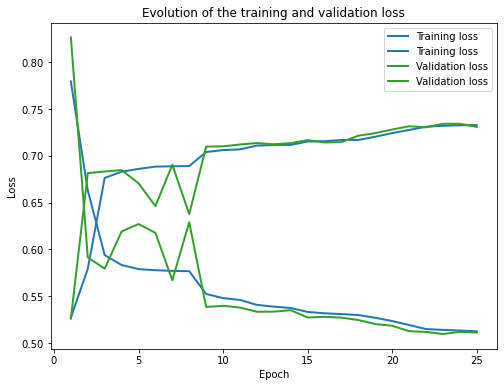

Best accuracy model basique :0.7308769403104497


In [34]:
history_tr=[]
history_te=[]
    
for epoch in range(nb_epochs):
    loss_train, acc_train = train( model, train_loader, optimizer, epoch, log_interval=10, criterion=criterion )
    history_tr.append((loss_train, acc_train))
    loss_val, acc_val = test( model, val_loader, epoch, criterion=criterion)
    history_te.append((loss_val, acc_val))
    if scheduler_type=='step':
        scheduler.step()
        print(scheduler._last_lr)
    if scheduler_type=='plateau':
        scheduler.step(acc_val)
        print(scheduler._last_lr)
    if save_model and epoch % save_epoch == 0:
        torch.save(model.state_dict(),'Conv_bn_dro_init_data_augmentation_adam_%s.pth' % (epoch))
    
print('Training Done')
plot_losses(history_tr, history_te)
print('Best accuracy model basique :{}'.format(history_te[-1][1]))
    
torch.save(model.state_dict(), 'Conv_bn_dro_init_data_augmentation_adam.pth')

#### Résultats et conclusion

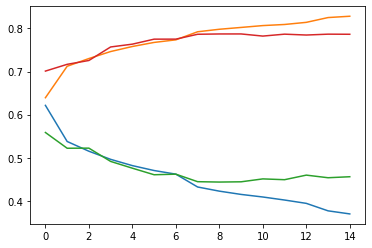

In [48]:
#Historique des courbes de loss et d'accuracy pour un CNN avec dropout with data augmentation
plt.plot(history_tr)
plt.plot(history_te)

In [49]:
#Performance en prédiction du CNN avec dropout et data augmentation
pred_bool, labels, genres = predict_dataset(model, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men)

Prediction complete
Accuracy_score général:  0.7856857180595398
Accuracy_score femme_0:  0.82598876953125
Accuracy_score homme_1:  0.7289539575576782


On constate que le modèle overfit un peu plus tardivement que précedemmenet, c.a.d à l\'epoch 7 au lieu de 6. L'introduction du (1) dropout, (2) d'une loss L2 et de (3) la data augmentation a eu un impact, l'overfitting etant moins important. 

De plus les performances en prédiction pour la métrique "accuracy" sont meilleures mais l'écart en précision est de l'ordre de 10% entre les genres. Le modèle se comporte beaucoup mieux pour le genre "femme" que pour le genre "homme".

### Approche 3 - Tentative avec un modèle plus complexe et une architecture Resnet

En troisièle approche, j'ai donc tenté d'augmenter la complexité du classifieur notamment pour l'extraction de features.

L'objectif étant de tenter d'améliorer les performances en classification, particulièrement pour le genre masculin.

Le modèle utilisé est basé sur l'architecture resnet. 

J'ai utilisé un weight_decay de 0.3 pour la loss L2 ainsi qu'un scheduleur de learning rate par plateau.

#### Modèle

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel,stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, stride = stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, stride = 1, padding=1)  #we change the size only once
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample
    
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample: #to be used when input size does not match output size
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return(out)

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10, n_channels=1):
        super(ResNet, self).__init__()
        self.in_channel = 16
        self.conv1 = nn.Conv2d(n_channels,16, stride =1, kernel_size = 3, padding = 1)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.block1 = self.make_layer(block, 16, 1)
        self.block2 = self.make_layer(block, 16, 1)
        self.block3 = self.make_layer(block, 32, 2)
        self.block4 = self.make_layer(block, 32, 1)
        self.block5 = self.make_layer(block, 64, 2)
        self.block6 = self.make_layer(block, 64, 1)
        self.avg_pool = nn.AvgPool2d(8) #8 is the kernel size so it is taking average of 8x8
        self.fc = nn.Linear(256, num_classes)
    def make_layer(self, block, out_channel, stride=1):
        downsample = None
        if(stride!=1) or (self.in_channel != out_channel):#input size not equal to output size only when stride not 1 or input channel and output channel are not same 
            downsample = nn.Sequential(
            nn.Conv2d(self.in_channel, out_channel, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d(out_channel))
        out_layer = block(self.in_channel, out_channel, stride, downsample)
        self.in_channel = out_channel
        return(out_layer)
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#### Apprentissage

In [37]:
#All the parameters
batch_size = 128
optimizer_type = "SGD"
scheduler_type='plateau'
learning_rate = 1e-2
weight_decay = 1e-3
lr_decay_epochs = 5
lr_decay = 0.1
nb_epochs = 15
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
momentum = 0.9
n_channels = 3
num_classes = 2

In [38]:
#Loss
criterion = nn.CrossEntropyLoss()
#Model
model= ResNet(block = ResidualBlock, num_classes= num_classes, n_channels=n_channels).to(device)
#Optimizer
if optimizer_type =='adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
if optimizer_type =='SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler
if scheduler_type=='step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs,gamma=lr_decay)
if scheduler_type=='plateau':   
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay, patience=5, threshold=0.05,verbose=True)

Train Epoch: 0 [0/299966 (0%)]	Loss: 0.687104	Acc: 0.570312
Train Epoch: 0 [1280/299966 (0%)]	Loss: 0.710485	Acc: 0.484375
Train Epoch: 0 [2560/299966 (1%)]	Loss: 0.720474	Acc: 0.546875
Train Epoch: 0 [3840/299966 (1%)]	Loss: 0.715634	Acc: 0.507812
Train Epoch: 0 [5120/299966 (2%)]	Loss: 0.760480	Acc: 0.476562
Train Epoch: 0 [6400/299966 (2%)]	Loss: 0.687306	Acc: 0.546875
Train Epoch: 0 [7680/299966 (3%)]	Loss: 0.673288	Acc: 0.562500
Train Epoch: 0 [8960/299966 (3%)]	Loss: 0.672282	Acc: 0.593750
Train Epoch: 0 [10240/299966 (3%)]	Loss: 0.689889	Acc: 0.570312
Train Epoch: 0 [11520/299966 (4%)]	Loss: 0.641633	Acc: 0.625000
Train Epoch: 0 [12800/299966 (4%)]	Loss: 0.663049	Acc: 0.593750
Train Epoch: 0 [14080/299966 (5%)]	Loss: 0.665817	Acc: 0.601562
Train Epoch: 0 [15360/299966 (5%)]	Loss: 0.654635	Acc: 0.578125
Train Epoch: 0 [16640/299966 (6%)]	Loss: 0.684550	Acc: 0.585938
Train Epoch: 0 [17920/299966 (6%)]	Loss: 0.637959	Acc: 0.609375
Train Epoch: 0 [19200/299966 (6%)]	Loss: 0.638104	A

Train Epoch: 0 [161280/299966 (54%)]	Loss: 0.528663	Acc: 0.726562
Train Epoch: 0 [162560/299966 (54%)]	Loss: 0.543450	Acc: 0.695312
Train Epoch: 0 [163840/299966 (55%)]	Loss: 0.568655	Acc: 0.703125
Train Epoch: 0 [165120/299966 (55%)]	Loss: 0.510455	Acc: 0.679688
Train Epoch: 0 [166400/299966 (55%)]	Loss: 0.634035	Acc: 0.570312
Train Epoch: 0 [167680/299966 (56%)]	Loss: 0.574230	Acc: 0.734375
Train Epoch: 0 [168960/299966 (56%)]	Loss: 0.497960	Acc: 0.710938
Train Epoch: 0 [170240/299966 (57%)]	Loss: 0.515030	Acc: 0.726562
Train Epoch: 0 [171520/299966 (57%)]	Loss: 0.525842	Acc: 0.695312
Train Epoch: 0 [172800/299966 (58%)]	Loss: 0.582335	Acc: 0.679688
Train Epoch: 0 [174080/299966 (58%)]	Loss: 0.567126	Acc: 0.718750
Train Epoch: 0 [175360/299966 (58%)]	Loss: 0.575787	Acc: 0.726562
Train Epoch: 0 [176640/299966 (59%)]	Loss: 0.439698	Acc: 0.812500
Train Epoch: 0 [177920/299966 (59%)]	Loss: 0.523205	Acc: 0.734375
Train Epoch: 0 [179200/299966 (60%)]	Loss: 0.511377	Acc: 0.703125
Train Epoc

Train Epoch: 1 [19200/299966 (6%)]	Loss: 0.525808	Acc: 0.726562
Train Epoch: 1 [20480/299966 (7%)]	Loss: 0.625746	Acc: 0.625000
Train Epoch: 1 [21760/299966 (7%)]	Loss: 0.478905	Acc: 0.757812
Train Epoch: 1 [23040/299966 (8%)]	Loss: 0.553869	Acc: 0.703125
Train Epoch: 1 [24320/299966 (8%)]	Loss: 0.524453	Acc: 0.734375
Train Epoch: 1 [25600/299966 (9%)]	Loss: 0.460099	Acc: 0.781250
Train Epoch: 1 [26880/299966 (9%)]	Loss: 0.559084	Acc: 0.695312
Train Epoch: 1 [28160/299966 (9%)]	Loss: 0.509868	Acc: 0.710938
Train Epoch: 1 [29440/299966 (10%)]	Loss: 0.542830	Acc: 0.710938
Train Epoch: 1 [30720/299966 (10%)]	Loss: 0.636624	Acc: 0.695312
Train Epoch: 1 [32000/299966 (11%)]	Loss: 0.653224	Acc: 0.664062
Train Epoch: 1 [33280/299966 (11%)]	Loss: 0.501103	Acc: 0.765625
Train Epoch: 1 [34560/299966 (12%)]	Loss: 0.534153	Acc: 0.648438
Train Epoch: 1 [35840/299966 (12%)]	Loss: 0.506547	Acc: 0.765625
Train Epoch: 1 [37120/299966 (12%)]	Loss: 0.633112	Acc: 0.687500
Train Epoch: 1 [38400/299966 (13%

Train Epoch: 1 [180480/299966 (60%)]	Loss: 0.504314	Acc: 0.750000
Train Epoch: 1 [181760/299966 (61%)]	Loss: 0.489334	Acc: 0.718750
Train Epoch: 1 [183040/299966 (61%)]	Loss: 0.457296	Acc: 0.750000
Train Epoch: 1 [184320/299966 (61%)]	Loss: 0.520934	Acc: 0.726562
Train Epoch: 1 [185600/299966 (62%)]	Loss: 0.419700	Acc: 0.812500
Train Epoch: 1 [186880/299966 (62%)]	Loss: 0.489767	Acc: 0.726562
Train Epoch: 1 [188160/299966 (63%)]	Loss: 0.487845	Acc: 0.718750
Train Epoch: 1 [189440/299966 (63%)]	Loss: 0.492523	Acc: 0.710938
Train Epoch: 1 [190720/299966 (64%)]	Loss: 0.525404	Acc: 0.710938
Train Epoch: 1 [192000/299966 (64%)]	Loss: 0.535190	Acc: 0.695312
Train Epoch: 1 [193280/299966 (64%)]	Loss: 0.440626	Acc: 0.812500
Train Epoch: 1 [194560/299966 (65%)]	Loss: 0.520817	Acc: 0.726562
Train Epoch: 1 [195840/299966 (65%)]	Loss: 0.604206	Acc: 0.679688
Train Epoch: 1 [197120/299966 (66%)]	Loss: 0.424374	Acc: 0.789062
Train Epoch: 1 [198400/299966 (66%)]	Loss: 0.525705	Acc: 0.734375
Train Epoc

Train Epoch: 2 [38400/299966 (13%)]	Loss: 0.551055	Acc: 0.695312
Train Epoch: 2 [39680/299966 (13%)]	Loss: 0.395833	Acc: 0.820312
Train Epoch: 2 [40960/299966 (14%)]	Loss: 0.525581	Acc: 0.703125
Train Epoch: 2 [42240/299966 (14%)]	Loss: 0.432630	Acc: 0.765625
Train Epoch: 2 [43520/299966 (15%)]	Loss: 0.408097	Acc: 0.781250
Train Epoch: 2 [44800/299966 (15%)]	Loss: 0.540807	Acc: 0.703125
Train Epoch: 2 [46080/299966 (15%)]	Loss: 0.438177	Acc: 0.781250
Train Epoch: 2 [47360/299966 (16%)]	Loss: 0.533416	Acc: 0.710938
Train Epoch: 2 [48640/299966 (16%)]	Loss: 0.443968	Acc: 0.789062
Train Epoch: 2 [49920/299966 (17%)]	Loss: 0.448854	Acc: 0.796875
Train Epoch: 2 [51200/299966 (17%)]	Loss: 0.512934	Acc: 0.750000
Train Epoch: 2 [52480/299966 (17%)]	Loss: 0.456545	Acc: 0.757812
Train Epoch: 2 [53760/299966 (18%)]	Loss: 0.493533	Acc: 0.773438
Train Epoch: 2 [55040/299966 (18%)]	Loss: 0.507011	Acc: 0.726562
Train Epoch: 2 [56320/299966 (19%)]	Loss: 0.556767	Acc: 0.726562
Train Epoch: 2 [57600/299

Train Epoch: 2 [198400/299966 (66%)]	Loss: 0.524117	Acc: 0.765625
Train Epoch: 2 [199680/299966 (67%)]	Loss: 0.563213	Acc: 0.687500
Train Epoch: 2 [200960/299966 (67%)]	Loss: 0.510939	Acc: 0.718750
Train Epoch: 2 [202240/299966 (67%)]	Loss: 0.473714	Acc: 0.750000
Train Epoch: 2 [203520/299966 (68%)]	Loss: 0.412586	Acc: 0.835938
Train Epoch: 2 [204800/299966 (68%)]	Loss: 0.470526	Acc: 0.796875
Train Epoch: 2 [206080/299966 (69%)]	Loss: 0.417947	Acc: 0.828125
Train Epoch: 2 [207360/299966 (69%)]	Loss: 0.466490	Acc: 0.773438
Train Epoch: 2 [208640/299966 (70%)]	Loss: 0.441231	Acc: 0.804688
Train Epoch: 2 [209920/299966 (70%)]	Loss: 0.460341	Acc: 0.757812
Train Epoch: 2 [211200/299966 (70%)]	Loss: 0.523023	Acc: 0.750000
Train Epoch: 2 [212480/299966 (71%)]	Loss: 0.478644	Acc: 0.718750
Train Epoch: 2 [213760/299966 (71%)]	Loss: 0.499129	Acc: 0.765625
Train Epoch: 2 [215040/299966 (72%)]	Loss: 0.521123	Acc: 0.750000
Train Epoch: 2 [216320/299966 (72%)]	Loss: 0.518394	Acc: 0.742188
Train Epoc

Train Epoch: 3 [56320/299966 (19%)]	Loss: 0.531485	Acc: 0.710938
Train Epoch: 3 [57600/299966 (19%)]	Loss: 0.501703	Acc: 0.718750
Train Epoch: 3 [58880/299966 (20%)]	Loss: 0.513393	Acc: 0.734375
Train Epoch: 3 [60160/299966 (20%)]	Loss: 0.439273	Acc: 0.812500
Train Epoch: 3 [61440/299966 (20%)]	Loss: 0.424716	Acc: 0.812500
Train Epoch: 3 [62720/299966 (21%)]	Loss: 0.468802	Acc: 0.726562
Train Epoch: 3 [64000/299966 (21%)]	Loss: 0.535471	Acc: 0.773438
Train Epoch: 3 [65280/299966 (22%)]	Loss: 0.379866	Acc: 0.820312
Train Epoch: 3 [66560/299966 (22%)]	Loss: 0.478201	Acc: 0.750000
Train Epoch: 3 [67840/299966 (23%)]	Loss: 0.499893	Acc: 0.734375
Train Epoch: 3 [69120/299966 (23%)]	Loss: 0.503696	Acc: 0.742188
Train Epoch: 3 [70400/299966 (23%)]	Loss: 0.406249	Acc: 0.781250
Train Epoch: 3 [71680/299966 (24%)]	Loss: 0.487090	Acc: 0.781250
Train Epoch: 3 [72960/299966 (24%)]	Loss: 0.482314	Acc: 0.742188
Train Epoch: 3 [74240/299966 (25%)]	Loss: 0.477312	Acc: 0.734375
Train Epoch: 3 [75520/299

Train Epoch: 3 [216320/299966 (72%)]	Loss: 0.361421	Acc: 0.843750
Train Epoch: 3 [217600/299966 (73%)]	Loss: 0.456426	Acc: 0.734375
Train Epoch: 3 [218880/299966 (73%)]	Loss: 0.463823	Acc: 0.757812
Train Epoch: 3 [220160/299966 (73%)]	Loss: 0.528991	Acc: 0.734375
Train Epoch: 3 [221440/299966 (74%)]	Loss: 0.464377	Acc: 0.765625
Train Epoch: 3 [222720/299966 (74%)]	Loss: 0.427448	Acc: 0.796875
Train Epoch: 3 [224000/299966 (75%)]	Loss: 0.467841	Acc: 0.789062
Train Epoch: 3 [225280/299966 (75%)]	Loss: 0.467191	Acc: 0.765625
Train Epoch: 3 [226560/299966 (76%)]	Loss: 0.443718	Acc: 0.750000
Train Epoch: 3 [227840/299966 (76%)]	Loss: 0.479276	Acc: 0.742188
Train Epoch: 3 [229120/299966 (76%)]	Loss: 0.441991	Acc: 0.781250
Train Epoch: 3 [230400/299966 (77%)]	Loss: 0.460803	Acc: 0.789062
Train Epoch: 3 [231680/299966 (77%)]	Loss: 0.460556	Acc: 0.781250
Train Epoch: 3 [232960/299966 (78%)]	Loss: 0.494354	Acc: 0.710938
Train Epoch: 3 [234240/299966 (78%)]	Loss: 0.484395	Acc: 0.781250
Train Epoc

Train Epoch: 4 [74240/299966 (25%)]	Loss: 0.442172	Acc: 0.781250
Train Epoch: 4 [75520/299966 (25%)]	Loss: 0.450303	Acc: 0.804688
Train Epoch: 4 [76800/299966 (26%)]	Loss: 0.502809	Acc: 0.757812
Train Epoch: 4 [78080/299966 (26%)]	Loss: 0.501488	Acc: 0.750000
Train Epoch: 4 [79360/299966 (26%)]	Loss: 0.461102	Acc: 0.718750
Train Epoch: 4 [80640/299966 (27%)]	Loss: 0.437251	Acc: 0.734375
Train Epoch: 4 [81920/299966 (27%)]	Loss: 0.430686	Acc: 0.789062
Train Epoch: 4 [83200/299966 (28%)]	Loss: 0.462452	Acc: 0.742188
Train Epoch: 4 [84480/299966 (28%)]	Loss: 0.395035	Acc: 0.828125
Train Epoch: 4 [85760/299966 (29%)]	Loss: 0.525338	Acc: 0.718750
Train Epoch: 4 [87040/299966 (29%)]	Loss: 0.476304	Acc: 0.757812
Train Epoch: 4 [88320/299966 (29%)]	Loss: 0.444686	Acc: 0.757812
Train Epoch: 4 [89600/299966 (30%)]	Loss: 0.498244	Acc: 0.718750
Train Epoch: 4 [90880/299966 (30%)]	Loss: 0.483151	Acc: 0.757812
Train Epoch: 4 [92160/299966 (31%)]	Loss: 0.539782	Acc: 0.726562
Train Epoch: 4 [93440/299

Train Epoch: 4 [234240/299966 (78%)]	Loss: 0.455527	Acc: 0.796875
Train Epoch: 4 [235520/299966 (78%)]	Loss: 0.499097	Acc: 0.750000
Train Epoch: 4 [236800/299966 (79%)]	Loss: 0.429285	Acc: 0.812500
Train Epoch: 4 [238080/299966 (79%)]	Loss: 0.468283	Acc: 0.750000
Train Epoch: 4 [239360/299966 (80%)]	Loss: 0.541330	Acc: 0.679688
Train Epoch: 4 [240640/299966 (80%)]	Loss: 0.402518	Acc: 0.773438
Train Epoch: 4 [241920/299966 (81%)]	Loss: 0.414014	Acc: 0.796875
Train Epoch: 4 [243200/299966 (81%)]	Loss: 0.424785	Acc: 0.789062
Train Epoch: 4 [244480/299966 (81%)]	Loss: 0.496978	Acc: 0.750000
Train Epoch: 4 [245760/299966 (82%)]	Loss: 0.492584	Acc: 0.703125
Train Epoch: 4 [247040/299966 (82%)]	Loss: 0.493426	Acc: 0.742188
Train Epoch: 4 [248320/299966 (83%)]	Loss: 0.412715	Acc: 0.820312
Train Epoch: 4 [249600/299966 (83%)]	Loss: 0.536830	Acc: 0.742188
Train Epoch: 4 [250880/299966 (84%)]	Loss: 0.420921	Acc: 0.781250
Train Epoch: 4 [252160/299966 (84%)]	Loss: 0.431093	Acc: 0.757812
Train Epoc

Train Epoch: 5 [93440/299966 (31%)]	Loss: 0.452810	Acc: 0.828125
Train Epoch: 5 [94720/299966 (32%)]	Loss: 0.482573	Acc: 0.789062
Train Epoch: 5 [96000/299966 (32%)]	Loss: 0.466947	Acc: 0.757812
Train Epoch: 5 [97280/299966 (32%)]	Loss: 0.475502	Acc: 0.796875
Train Epoch: 5 [98560/299966 (33%)]	Loss: 0.458276	Acc: 0.773438
Train Epoch: 5 [99840/299966 (33%)]	Loss: 0.515675	Acc: 0.765625
Train Epoch: 5 [101120/299966 (34%)]	Loss: 0.424851	Acc: 0.820312
Train Epoch: 5 [102400/299966 (34%)]	Loss: 0.523041	Acc: 0.757812
Train Epoch: 5 [103680/299966 (35%)]	Loss: 0.461274	Acc: 0.773438
Train Epoch: 5 [104960/299966 (35%)]	Loss: 0.459310	Acc: 0.773438
Train Epoch: 5 [106240/299966 (35%)]	Loss: 0.436654	Acc: 0.757812
Train Epoch: 5 [107520/299966 (36%)]	Loss: 0.502811	Acc: 0.773438
Train Epoch: 5 [108800/299966 (36%)]	Loss: 0.444183	Acc: 0.804688
Train Epoch: 5 [110080/299966 (37%)]	Loss: 0.456977	Acc: 0.820312
Train Epoch: 5 [111360/299966 (37%)]	Loss: 0.481454	Acc: 0.742188
Train Epoch: 5 [

Train Epoch: 5 [253440/299966 (84%)]	Loss: 0.554461	Acc: 0.695312
Train Epoch: 5 [254720/299966 (85%)]	Loss: 0.501417	Acc: 0.742188
Train Epoch: 5 [256000/299966 (85%)]	Loss: 0.447404	Acc: 0.828125
Train Epoch: 5 [257280/299966 (86%)]	Loss: 0.501077	Acc: 0.750000
Train Epoch: 5 [258560/299966 (86%)]	Loss: 0.425034	Acc: 0.796875
Train Epoch: 5 [259840/299966 (87%)]	Loss: 0.451762	Acc: 0.765625
Train Epoch: 5 [261120/299966 (87%)]	Loss: 0.533614	Acc: 0.718750
Train Epoch: 5 [262400/299966 (87%)]	Loss: 0.475989	Acc: 0.750000
Train Epoch: 5 [263680/299966 (88%)]	Loss: 0.451011	Acc: 0.742188
Train Epoch: 5 [264960/299966 (88%)]	Loss: 0.429752	Acc: 0.820312
Train Epoch: 5 [266240/299966 (89%)]	Loss: 0.466023	Acc: 0.773438
Train Epoch: 5 [267520/299966 (89%)]	Loss: 0.436649	Acc: 0.781250
Train Epoch: 5 [268800/299966 (90%)]	Loss: 0.460052	Acc: 0.765625
Train Epoch: 5 [270080/299966 (90%)]	Loss: 0.392150	Acc: 0.812500
Train Epoch: 5 [271360/299966 (90%)]	Loss: 0.421031	Acc: 0.796875
Train Epoc

Train Epoch: 6 [112640/299966 (38%)]	Loss: 0.481674	Acc: 0.718750
Train Epoch: 6 [113920/299966 (38%)]	Loss: 0.445928	Acc: 0.781250
Train Epoch: 6 [115200/299966 (38%)]	Loss: 0.509497	Acc: 0.742188
Train Epoch: 6 [116480/299966 (39%)]	Loss: 0.429355	Acc: 0.781250
Train Epoch: 6 [117760/299966 (39%)]	Loss: 0.425681	Acc: 0.812500
Train Epoch: 6 [119040/299966 (40%)]	Loss: 0.523835	Acc: 0.750000
Train Epoch: 6 [120320/299966 (40%)]	Loss: 0.439501	Acc: 0.734375
Train Epoch: 6 [121600/299966 (41%)]	Loss: 0.456573	Acc: 0.773438
Train Epoch: 6 [122880/299966 (41%)]	Loss: 0.537926	Acc: 0.726562
Train Epoch: 6 [124160/299966 (41%)]	Loss: 0.442094	Acc: 0.804688
Train Epoch: 6 [125440/299966 (42%)]	Loss: 0.468740	Acc: 0.796875
Train Epoch: 6 [126720/299966 (42%)]	Loss: 0.451188	Acc: 0.804688
Train Epoch: 6 [128000/299966 (43%)]	Loss: 0.419985	Acc: 0.804688
Train Epoch: 6 [129280/299966 (43%)]	Loss: 0.500727	Acc: 0.757812
Train Epoch: 6 [130560/299966 (44%)]	Loss: 0.542013	Acc: 0.703125
Train Epoc

Train Epoch: 6 [272640/299966 (91%)]	Loss: 0.391251	Acc: 0.812500
Train Epoch: 6 [273920/299966 (91%)]	Loss: 0.498705	Acc: 0.765625
Train Epoch: 6 [275200/299966 (92%)]	Loss: 0.579554	Acc: 0.710938
Train Epoch: 6 [276480/299966 (92%)]	Loss: 0.511896	Acc: 0.820312
Train Epoch: 6 [277760/299966 (93%)]	Loss: 0.506158	Acc: 0.750000
Train Epoch: 6 [279040/299966 (93%)]	Loss: 0.435825	Acc: 0.796875
Train Epoch: 6 [280320/299966 (93%)]	Loss: 0.494297	Acc: 0.742188
Train Epoch: 6 [281600/299966 (94%)]	Loss: 0.443238	Acc: 0.750000
Train Epoch: 6 [282880/299966 (94%)]	Loss: 0.494511	Acc: 0.796875
Train Epoch: 6 [284160/299966 (95%)]	Loss: 0.525006	Acc: 0.742188
Train Epoch: 6 [285440/299966 (95%)]	Loss: 0.443889	Acc: 0.789062
Train Epoch: 6 [286720/299966 (96%)]	Loss: 0.450658	Acc: 0.804688
Train Epoch: 6 [288000/299966 (96%)]	Loss: 0.540632	Acc: 0.710938
Train Epoch: 6 [289280/299966 (96%)]	Loss: 0.485845	Acc: 0.742188
Train Epoch: 6 [290560/299966 (97%)]	Loss: 0.466701	Acc: 0.757812
Train Epoc

Train Epoch: 7 [130560/299966 (44%)]	Loss: 0.338716	Acc: 0.820312
Train Epoch: 7 [131840/299966 (44%)]	Loss: 0.411354	Acc: 0.789062
Train Epoch: 7 [133120/299966 (44%)]	Loss: 0.401264	Acc: 0.789062
Train Epoch: 7 [134400/299966 (45%)]	Loss: 0.402522	Acc: 0.796875
Train Epoch: 7 [135680/299966 (45%)]	Loss: 0.427796	Acc: 0.812500
Train Epoch: 7 [136960/299966 (46%)]	Loss: 0.473261	Acc: 0.796875
Train Epoch: 7 [138240/299966 (46%)]	Loss: 0.373238	Acc: 0.843750
Train Epoch: 7 [139520/299966 (47%)]	Loss: 0.393834	Acc: 0.820312
Train Epoch: 7 [140800/299966 (47%)]	Loss: 0.404032	Acc: 0.828125
Train Epoch: 7 [142080/299966 (47%)]	Loss: 0.484300	Acc: 0.773438
Train Epoch: 7 [143360/299966 (48%)]	Loss: 0.411911	Acc: 0.796875
Train Epoch: 7 [144640/299966 (48%)]	Loss: 0.468525	Acc: 0.820312
Train Epoch: 7 [145920/299966 (49%)]	Loss: 0.406169	Acc: 0.796875
Train Epoch: 7 [147200/299966 (49%)]	Loss: 0.378856	Acc: 0.820312
Train Epoch: 7 [148480/299966 (49%)]	Loss: 0.354928	Acc: 0.843750
Train Epoc

Train Epoch: 7 [290560/299966 (97%)]	Loss: 0.435231	Acc: 0.773438
Train Epoch: 7 [291840/299966 (97%)]	Loss: 0.398206	Acc: 0.812500
Train Epoch: 7 [293120/299966 (98%)]	Loss: 0.413313	Acc: 0.804688
Train Epoch: 7 [294400/299966 (98%)]	Loss: 0.369631	Acc: 0.804688
Train Epoch: 7 [295680/299966 (99%)]	Loss: 0.462917	Acc: 0.750000
Train Epoch: 7 [296960/299966 (99%)]	Loss: 0.359471	Acc: 0.835938
Train Epoch: 7 [298240/299966 (99%)]	Loss: 0.365369	Acc: 0.804688
Train Epoch: 7 [299520/299966 (100%)]	Loss: 0.447217	Acc: 0.757812
Train Epoch: 7 \LOSS: 0.430355 \Accuracy: 0.791597
Test Epoch: 7 \LOSS: 0.441288 \Accuracy: 0.786006
[0.001]
Train Epoch: 8 [0/299966 (0%)]	Loss: 0.474828	Acc: 0.765625
Train Epoch: 8 [1280/299966 (0%)]	Loss: 0.370673	Acc: 0.828125
Train Epoch: 8 [2560/299966 (1%)]	Loss: 0.488411	Acc: 0.742188
Train Epoch: 8 [3840/299966 (1%)]	Loss: 0.462124	Acc: 0.750000
Train Epoch: 8 [5120/299966 (2%)]	Loss: 0.370606	Acc: 0.820312
Train Epoch: 8 [6400/299966 (2%)]	Loss: 0.398524	A

Train Epoch: 8 [149760/299966 (50%)]	Loss: 0.424431	Acc: 0.773438
Train Epoch: 8 [151040/299966 (50%)]	Loss: 0.422030	Acc: 0.757812
Train Epoch: 8 [152320/299966 (51%)]	Loss: 0.325213	Acc: 0.859375
Train Epoch: 8 [153600/299966 (51%)]	Loss: 0.380307	Acc: 0.820312
Train Epoch: 8 [154880/299966 (52%)]	Loss: 0.469320	Acc: 0.812500
Train Epoch: 8 [156160/299966 (52%)]	Loss: 0.422600	Acc: 0.781250
Train Epoch: 8 [157440/299966 (52%)]	Loss: 0.427113	Acc: 0.820312
Train Epoch: 8 [158720/299966 (53%)]	Loss: 0.387372	Acc: 0.820312
Train Epoch: 8 [160000/299966 (53%)]	Loss: 0.474614	Acc: 0.773438
Train Epoch: 8 [161280/299966 (54%)]	Loss: 0.343291	Acc: 0.843750
Train Epoch: 8 [162560/299966 (54%)]	Loss: 0.485249	Acc: 0.820312
Train Epoch: 8 [163840/299966 (55%)]	Loss: 0.399185	Acc: 0.804688
Train Epoch: 8 [165120/299966 (55%)]	Loss: 0.450518	Acc: 0.789062
Train Epoch: 8 [166400/299966 (55%)]	Loss: 0.478359	Acc: 0.750000
Train Epoch: 8 [167680/299966 (56%)]	Loss: 0.379034	Acc: 0.796875
Train Epoc

Train Epoch: 9 [6400/299966 (2%)]	Loss: 0.408464	Acc: 0.820312
Train Epoch: 9 [7680/299966 (3%)]	Loss: 0.362478	Acc: 0.835938
Train Epoch: 9 [8960/299966 (3%)]	Loss: 0.443277	Acc: 0.835938
Train Epoch: 9 [10240/299966 (3%)]	Loss: 0.444116	Acc: 0.804688
Train Epoch: 9 [11520/299966 (4%)]	Loss: 0.407936	Acc: 0.796875
Train Epoch: 9 [12800/299966 (4%)]	Loss: 0.360443	Acc: 0.851562
Train Epoch: 9 [14080/299966 (5%)]	Loss: 0.426249	Acc: 0.773438
Train Epoch: 9 [15360/299966 (5%)]	Loss: 0.491905	Acc: 0.718750
Train Epoch: 9 [16640/299966 (6%)]	Loss: 0.368283	Acc: 0.867188
Train Epoch: 9 [17920/299966 (6%)]	Loss: 0.400501	Acc: 0.804688
Train Epoch: 9 [19200/299966 (6%)]	Loss: 0.368984	Acc: 0.812500
Train Epoch: 9 [20480/299966 (7%)]	Loss: 0.340632	Acc: 0.851562
Train Epoch: 9 [21760/299966 (7%)]	Loss: 0.488627	Acc: 0.750000
Train Epoch: 9 [23040/299966 (8%)]	Loss: 0.360788	Acc: 0.828125
Train Epoch: 9 [24320/299966 (8%)]	Loss: 0.396601	Acc: 0.804688
Train Epoch: 9 [25600/299966 (9%)]	Loss: 0.

Train Epoch: 9 [167680/299966 (56%)]	Loss: 0.445986	Acc: 0.750000
Train Epoch: 9 [168960/299966 (56%)]	Loss: 0.360455	Acc: 0.859375
Train Epoch: 9 [170240/299966 (57%)]	Loss: 0.478710	Acc: 0.773438
Train Epoch: 9 [171520/299966 (57%)]	Loss: 0.402208	Acc: 0.851562
Train Epoch: 9 [172800/299966 (58%)]	Loss: 0.454059	Acc: 0.796875
Train Epoch: 9 [174080/299966 (58%)]	Loss: 0.392841	Acc: 0.835938
Train Epoch: 9 [175360/299966 (58%)]	Loss: 0.412461	Acc: 0.820312
Train Epoch: 9 [176640/299966 (59%)]	Loss: 0.392789	Acc: 0.812500
Train Epoch: 9 [177920/299966 (59%)]	Loss: 0.469954	Acc: 0.757812
Train Epoch: 9 [179200/299966 (60%)]	Loss: 0.411512	Acc: 0.789062
Train Epoch: 9 [180480/299966 (60%)]	Loss: 0.412378	Acc: 0.765625
Train Epoch: 9 [181760/299966 (61%)]	Loss: 0.426154	Acc: 0.820312
Train Epoch: 9 [183040/299966 (61%)]	Loss: 0.348025	Acc: 0.828125
Train Epoch: 9 [184320/299966 (61%)]	Loss: 0.464370	Acc: 0.765625
Train Epoch: 9 [185600/299966 (62%)]	Loss: 0.388689	Acc: 0.804688
Train Epoc

Train Epoch: 10 [24320/299966 (8%)]	Loss: 0.475219	Acc: 0.757812
Train Epoch: 10 [25600/299966 (9%)]	Loss: 0.354041	Acc: 0.867188
Train Epoch: 10 [26880/299966 (9%)]	Loss: 0.394321	Acc: 0.828125
Train Epoch: 10 [28160/299966 (9%)]	Loss: 0.401232	Acc: 0.828125
Train Epoch: 10 [29440/299966 (10%)]	Loss: 0.394304	Acc: 0.804688
Train Epoch: 10 [30720/299966 (10%)]	Loss: 0.484285	Acc: 0.757812
Train Epoch: 10 [32000/299966 (11%)]	Loss: 0.385241	Acc: 0.812500
Train Epoch: 10 [33280/299966 (11%)]	Loss: 0.545643	Acc: 0.750000
Train Epoch: 10 [34560/299966 (12%)]	Loss: 0.455422	Acc: 0.820312
Train Epoch: 10 [35840/299966 (12%)]	Loss: 0.441987	Acc: 0.796875
Train Epoch: 10 [37120/299966 (12%)]	Loss: 0.276251	Acc: 0.906250
Train Epoch: 10 [38400/299966 (13%)]	Loss: 0.493567	Acc: 0.796875
Train Epoch: 10 [39680/299966 (13%)]	Loss: 0.350836	Acc: 0.835938
Train Epoch: 10 [40960/299966 (14%)]	Loss: 0.383036	Acc: 0.851562
Train Epoch: 10 [42240/299966 (14%)]	Loss: 0.371681	Acc: 0.835938
Train Epoch: 1

Train Epoch: 10 [183040/299966 (61%)]	Loss: 0.408113	Acc: 0.804688
Train Epoch: 10 [184320/299966 (61%)]	Loss: 0.423855	Acc: 0.812500
Train Epoch: 10 [185600/299966 (62%)]	Loss: 0.435933	Acc: 0.796875
Train Epoch: 10 [186880/299966 (62%)]	Loss: 0.387006	Acc: 0.835938
Train Epoch: 10 [188160/299966 (63%)]	Loss: 0.429269	Acc: 0.789062
Train Epoch: 10 [189440/299966 (63%)]	Loss: 0.349878	Acc: 0.851562
Train Epoch: 10 [190720/299966 (64%)]	Loss: 0.356040	Acc: 0.859375
Train Epoch: 10 [192000/299966 (64%)]	Loss: 0.438500	Acc: 0.796875
Train Epoch: 10 [193280/299966 (64%)]	Loss: 0.318716	Acc: 0.859375
Train Epoch: 10 [194560/299966 (65%)]	Loss: 0.376776	Acc: 0.859375
Train Epoch: 10 [195840/299966 (65%)]	Loss: 0.480174	Acc: 0.726562
Train Epoch: 10 [197120/299966 (66%)]	Loss: 0.313631	Acc: 0.867188
Train Epoch: 10 [198400/299966 (66%)]	Loss: 0.340069	Acc: 0.828125
Train Epoch: 10 [199680/299966 (67%)]	Loss: 0.375807	Acc: 0.851562
Train Epoch: 10 [200960/299966 (67%)]	Loss: 0.518176	Acc: 0.75

Train Epoch: 11 [38400/299966 (13%)]	Loss: 0.417953	Acc: 0.796875
Train Epoch: 11 [39680/299966 (13%)]	Loss: 0.384608	Acc: 0.820312
Train Epoch: 11 [40960/299966 (14%)]	Loss: 0.348706	Acc: 0.804688
Train Epoch: 11 [42240/299966 (14%)]	Loss: 0.377875	Acc: 0.812500
Train Epoch: 11 [43520/299966 (15%)]	Loss: 0.310015	Acc: 0.859375
Train Epoch: 11 [44800/299966 (15%)]	Loss: 0.382758	Acc: 0.804688
Train Epoch: 11 [46080/299966 (15%)]	Loss: 0.311487	Acc: 0.882812
Train Epoch: 11 [47360/299966 (16%)]	Loss: 0.373232	Acc: 0.812500
Train Epoch: 11 [48640/299966 (16%)]	Loss: 0.388655	Acc: 0.812500
Train Epoch: 11 [49920/299966 (17%)]	Loss: 0.373623	Acc: 0.843750
Train Epoch: 11 [51200/299966 (17%)]	Loss: 0.420707	Acc: 0.804688
Train Epoch: 11 [52480/299966 (17%)]	Loss: 0.359310	Acc: 0.875000
Train Epoch: 11 [53760/299966 (18%)]	Loss: 0.409748	Acc: 0.835938
Train Epoch: 11 [55040/299966 (18%)]	Loss: 0.475537	Acc: 0.750000
Train Epoch: 11 [56320/299966 (19%)]	Loss: 0.347180	Acc: 0.867188
Train Epoc

Train Epoch: 11 [197120/299966 (66%)]	Loss: 0.434971	Acc: 0.796875
Train Epoch: 11 [198400/299966 (66%)]	Loss: 0.366953	Acc: 0.820312
Train Epoch: 11 [199680/299966 (67%)]	Loss: 0.401477	Acc: 0.796875
Train Epoch: 11 [200960/299966 (67%)]	Loss: 0.395688	Acc: 0.820312
Train Epoch: 11 [202240/299966 (67%)]	Loss: 0.510377	Acc: 0.750000
Train Epoch: 11 [203520/299966 (68%)]	Loss: 0.453302	Acc: 0.750000
Train Epoch: 11 [204800/299966 (68%)]	Loss: 0.459672	Acc: 0.773438
Train Epoch: 11 [206080/299966 (69%)]	Loss: 0.338840	Acc: 0.812500
Train Epoch: 11 [207360/299966 (69%)]	Loss: 0.404047	Acc: 0.796875
Train Epoch: 11 [208640/299966 (70%)]	Loss: 0.335771	Acc: 0.843750
Train Epoch: 11 [209920/299966 (70%)]	Loss: 0.376905	Acc: 0.843750
Train Epoch: 11 [211200/299966 (70%)]	Loss: 0.359834	Acc: 0.835938
Train Epoch: 11 [212480/299966 (71%)]	Loss: 0.445102	Acc: 0.757812
Train Epoch: 11 [213760/299966 (71%)]	Loss: 0.326508	Acc: 0.859375
Train Epoch: 11 [215040/299966 (72%)]	Loss: 0.465897	Acc: 0.71

Train Epoch: 12 [52480/299966 (17%)]	Loss: 0.399690	Acc: 0.843750
Train Epoch: 12 [53760/299966 (18%)]	Loss: 0.386479	Acc: 0.843750
Train Epoch: 12 [55040/299966 (18%)]	Loss: 0.380206	Acc: 0.804688
Train Epoch: 12 [56320/299966 (19%)]	Loss: 0.338802	Acc: 0.843750
Train Epoch: 12 [57600/299966 (19%)]	Loss: 0.413447	Acc: 0.796875
Train Epoch: 12 [58880/299966 (20%)]	Loss: 0.416493	Acc: 0.835938
Train Epoch: 12 [60160/299966 (20%)]	Loss: 0.390172	Acc: 0.796875
Train Epoch: 12 [61440/299966 (20%)]	Loss: 0.367738	Acc: 0.820312
Train Epoch: 12 [62720/299966 (21%)]	Loss: 0.375762	Acc: 0.843750
Train Epoch: 12 [64000/299966 (21%)]	Loss: 0.405300	Acc: 0.773438
Train Epoch: 12 [65280/299966 (22%)]	Loss: 0.329984	Acc: 0.890625
Train Epoch: 12 [66560/299966 (22%)]	Loss: 0.439273	Acc: 0.750000
Train Epoch: 12 [67840/299966 (23%)]	Loss: 0.318395	Acc: 0.851562
Train Epoch: 12 [69120/299966 (23%)]	Loss: 0.358575	Acc: 0.859375
Train Epoch: 12 [70400/299966 (23%)]	Loss: 0.333044	Acc: 0.851562
Train Epoc

Train Epoch: 12 [209920/299966 (70%)]	Loss: 0.355405	Acc: 0.859375
Train Epoch: 12 [211200/299966 (70%)]	Loss: 0.514577	Acc: 0.742188
Train Epoch: 12 [212480/299966 (71%)]	Loss: 0.363473	Acc: 0.835938
Train Epoch: 12 [213760/299966 (71%)]	Loss: 0.412331	Acc: 0.773438
Train Epoch: 12 [215040/299966 (72%)]	Loss: 0.374289	Acc: 0.820312
Train Epoch: 12 [216320/299966 (72%)]	Loss: 0.372496	Acc: 0.859375
Train Epoch: 12 [217600/299966 (73%)]	Loss: 0.417909	Acc: 0.789062
Train Epoch: 12 [218880/299966 (73%)]	Loss: 0.365494	Acc: 0.835938
Train Epoch: 12 [220160/299966 (73%)]	Loss: 0.413051	Acc: 0.812500
Train Epoch: 12 [221440/299966 (74%)]	Loss: 0.449212	Acc: 0.789062
Train Epoch: 12 [222720/299966 (74%)]	Loss: 0.353374	Acc: 0.851562
Train Epoch: 12 [224000/299966 (75%)]	Loss: 0.384349	Acc: 0.757812
Train Epoch: 12 [225280/299966 (75%)]	Loss: 0.349013	Acc: 0.835938
Train Epoch: 12 [226560/299966 (76%)]	Loss: 0.336078	Acc: 0.859375
Train Epoch: 12 [227840/299966 (76%)]	Loss: 0.424043	Acc: 0.75

Train Epoch: 13 [64000/299966 (21%)]	Loss: 0.335047	Acc: 0.843750
Train Epoch: 13 [65280/299966 (22%)]	Loss: 0.377096	Acc: 0.828125
Train Epoch: 13 [66560/299966 (22%)]	Loss: 0.317355	Acc: 0.914062
Train Epoch: 13 [67840/299966 (23%)]	Loss: 0.380564	Acc: 0.796875
Train Epoch: 13 [69120/299966 (23%)]	Loss: 0.337177	Acc: 0.851562
Train Epoch: 13 [70400/299966 (23%)]	Loss: 0.357426	Acc: 0.812500
Train Epoch: 13 [71680/299966 (24%)]	Loss: 0.387828	Acc: 0.828125
Train Epoch: 13 [72960/299966 (24%)]	Loss: 0.350778	Acc: 0.843750
Train Epoch: 13 [74240/299966 (25%)]	Loss: 0.364262	Acc: 0.828125
Train Epoch: 13 [75520/299966 (25%)]	Loss: 0.431971	Acc: 0.804688
Train Epoch: 13 [76800/299966 (26%)]	Loss: 0.341352	Acc: 0.835938
Train Epoch: 13 [78080/299966 (26%)]	Loss: 0.366798	Acc: 0.828125
Train Epoch: 13 [79360/299966 (26%)]	Loss: 0.331546	Acc: 0.843750
Train Epoch: 13 [80640/299966 (27%)]	Loss: 0.427068	Acc: 0.804688
Train Epoch: 13 [81920/299966 (27%)]	Loss: 0.351912	Acc: 0.828125
Train Epoc

Train Epoch: 13 [221440/299966 (74%)]	Loss: 0.368828	Acc: 0.820312
Train Epoch: 13 [222720/299966 (74%)]	Loss: 0.359750	Acc: 0.820312
Train Epoch: 13 [224000/299966 (75%)]	Loss: 0.288713	Acc: 0.906250
Train Epoch: 13 [225280/299966 (75%)]	Loss: 0.348897	Acc: 0.828125
Train Epoch: 13 [226560/299966 (76%)]	Loss: 0.400641	Acc: 0.804688
Train Epoch: 13 [227840/299966 (76%)]	Loss: 0.373714	Acc: 0.851562
Train Epoch: 13 [229120/299966 (76%)]	Loss: 0.486714	Acc: 0.789062
Train Epoch: 13 [230400/299966 (77%)]	Loss: 0.346790	Acc: 0.867188
Train Epoch: 13 [231680/299966 (77%)]	Loss: 0.335805	Acc: 0.851562
Train Epoch: 13 [232960/299966 (78%)]	Loss: 0.390604	Acc: 0.851562
Train Epoch: 13 [234240/299966 (78%)]	Loss: 0.394969	Acc: 0.843750
Train Epoch: 13 [235520/299966 (78%)]	Loss: 0.323833	Acc: 0.843750
Train Epoch: 13 [236800/299966 (79%)]	Loss: 0.340711	Acc: 0.843750
Train Epoch: 13 [238080/299966 (79%)]	Loss: 0.296750	Acc: 0.906250
Train Epoch: 13 [239360/299966 (80%)]	Loss: 0.339606	Acc: 0.87

Train Epoch: 14 [76800/299966 (26%)]	Loss: 0.234497	Acc: 0.914062
Train Epoch: 14 [78080/299966 (26%)]	Loss: 0.356904	Acc: 0.867188
Train Epoch: 14 [79360/299966 (26%)]	Loss: 0.329999	Acc: 0.843750
Train Epoch: 14 [80640/299966 (27%)]	Loss: 0.413694	Acc: 0.851562
Train Epoch: 14 [81920/299966 (27%)]	Loss: 0.490818	Acc: 0.765625
Train Epoch: 14 [83200/299966 (28%)]	Loss: 0.409961	Acc: 0.820312
Train Epoch: 14 [84480/299966 (28%)]	Loss: 0.377002	Acc: 0.859375
Train Epoch: 14 [85760/299966 (29%)]	Loss: 0.396031	Acc: 0.804688
Train Epoch: 14 [87040/299966 (29%)]	Loss: 0.366207	Acc: 0.835938
Train Epoch: 14 [88320/299966 (29%)]	Loss: 0.376300	Acc: 0.828125
Train Epoch: 14 [89600/299966 (30%)]	Loss: 0.343740	Acc: 0.828125
Train Epoch: 14 [90880/299966 (30%)]	Loss: 0.354392	Acc: 0.859375
Train Epoch: 14 [92160/299966 (31%)]	Loss: 0.394444	Acc: 0.781250
Train Epoch: 14 [93440/299966 (31%)]	Loss: 0.301452	Acc: 0.875000
Train Epoch: 14 [94720/299966 (32%)]	Loss: 0.402851	Acc: 0.820312
Train Epoc

Train Epoch: 14 [234240/299966 (78%)]	Loss: 0.365239	Acc: 0.859375
Train Epoch: 14 [235520/299966 (78%)]	Loss: 0.346476	Acc: 0.851562
Train Epoch: 14 [236800/299966 (79%)]	Loss: 0.332221	Acc: 0.851562
Train Epoch: 14 [238080/299966 (79%)]	Loss: 0.375195	Acc: 0.820312
Train Epoch: 14 [239360/299966 (80%)]	Loss: 0.310561	Acc: 0.890625
Train Epoch: 14 [240640/299966 (80%)]	Loss: 0.298076	Acc: 0.851562
Train Epoch: 14 [241920/299966 (81%)]	Loss: 0.339017	Acc: 0.812500
Train Epoch: 14 [243200/299966 (81%)]	Loss: 0.310708	Acc: 0.882812
Train Epoch: 14 [244480/299966 (81%)]	Loss: 0.435651	Acc: 0.765625
Train Epoch: 14 [245760/299966 (82%)]	Loss: 0.403891	Acc: 0.796875
Train Epoch: 14 [247040/299966 (82%)]	Loss: 0.377875	Acc: 0.843750
Train Epoch: 14 [248320/299966 (83%)]	Loss: 0.365559	Acc: 0.875000
Train Epoch: 14 [249600/299966 (83%)]	Loss: 0.517758	Acc: 0.765625
Train Epoch: 14 [250880/299966 (84%)]	Loss: 0.392464	Acc: 0.828125
Train Epoch: 14 [252160/299966 (84%)]	Loss: 0.377652	Acc: 0.81

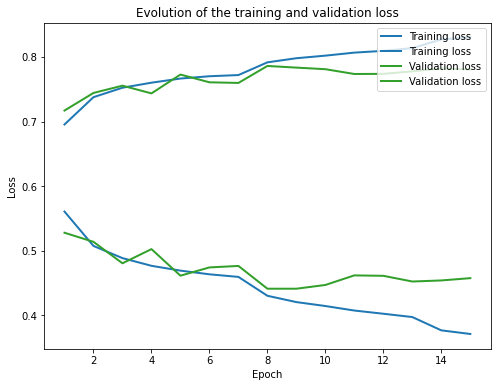

Best accuracy model basique :0.7806449031845095


In [39]:
history_tr=[]
history_te=[]
    
for epoch in range(nb_epochs):
    loss_train, acc_train = train( model, train_loader, optimizer, epoch, log_interval=10, criterion=criterion )
    history_tr.append((loss_train, acc_train))
    loss_val, acc_val = test( model, val_loader, epoch, criterion=criterion)
    history_te.append((loss_val, acc_val))
    if scheduler_type=='step':
        scheduler.step()
        print(scheduler._last_lr)
    if scheduler_type=='plateau':
        scheduler.step(acc_val)
        print(scheduler._last_lr)
    
print('Training Done')
plot_losses(history_tr, history_te)
print('Best accuracy model basique :{}'.format(history_te[-1][1]))
    
torch.save(model.state_dict(), 'Resnet.pth')

#### Résultats et conclusion

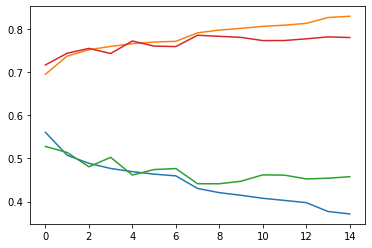

In [40]:
#Historique des courbes de loss et d'accuracypour un modèle avec l'architecture Resnet avec dropout et data augmentation
plt.plot(history_tr)
plt.plot(history_te)

In [41]:
#Performance en prédiction de l'architecture Resnet avec data augmentation
pred_bool, labels, genres = predict_dataset(model, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men)

Prediction complete
Accuracy_score général:  0.7806448936462402
Accuracy_score femme_0:  0.8237990736961365
Accuracy_score homme_1:  0.7198998332023621


On constate avec cette approche qu'il n'y a pas d'augmentation significative des performances. 
Ce modèle un peu plus complexe ne semble pas pouvoir extraire plus de caractéristiques pertinentes pour la classifcation.

### Approche 4 - Tentative avec une approche avec deux classifieurs et un GRL

AFin de réduire les écarts de performance entre les genres "femmes" et "hommes" j\'ai souhaité utiliser l'information contenue dans le label "genre".

Je me suis inspiré de l'approche "Gradient Reversal Layer" qui consiste à inverser le gradient pour forcer les caractéristiques à être identiques pour deux classes différentes.

L'idée ici serait de forcer les caractéristiques apprises par les couches de features à être identiques et génériques pour un homme et pour une femme.

l'architecture du "bimodel est documentée ci dessous.
Le but de la partie "Generator" du modèle est d'extraire les features. Le classifieur "CL" a pour objectif de discriminer sur les labels et le classifieur CG sur les genres.

En appliquant le [gradient reversal layer (GRL)](https://arxiv.org/pdf/1409.7495.pdf), c'est à dire inverser le gradient venant du classifieur CG, j'impose aux couches du Générateur de produire des caractéristiques qui confondent les hommes et les femmes. L'idée, in fine, etant de que les caractéristiques fianelement apprises permettent de discriminer les labels tout en étant générique d'un point de vue du genre.

#### BiModel

In [ ]:
from torch.autograd import Function
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None


class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [105]:
class Generator(nn.Module):
    def __init__(self,num_classes, n_channels =3, dropout_prob=0.5):
        super(Generator,self).__init__()
        self.dropout_prob=dropout_prob
        self.layer1=nn.Sequential(nn.Conv2d(n_channels, 32, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2=nn.Sequential(nn.Conv2d(32, 64, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3=nn.Sequential(nn.Conv2d(64, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4=nn.Sequential(nn.Conv2d(128, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.avgpool = nn.AdaptiveAvgPool2d(5)
        self.fc=nn.Linear(3200,512)
        self.bn=nn.BatchNorm1d(512)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.zeros_(m.bias.data)
    
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.avgpool(out)
        out=F.dropout(out,p=self.dropout_prob)
        out=out.reshape(out.size(0),-1)
        out=F.relu(self.bn(self.fc(out)))
        out=F.dropout(out,p=self.dropout_prob)
        return out


class Clf_Label(nn.Module):
    def __init__(self,num_classes):
        super(Clf_Label, self).__init__()

        self.fc1 = nn.Linear(512, 128)
        self.bn1_fc = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
        
    def forward(self, x):
        x = F.relu(self.bn1_fc(self.fc1(x)))
        #x = F.dropout(x,p=0.5)
        x = self.fc2(x)
        return x
    
class Clf_Genre(nn.Module):
    def __init__(self,num_classes,lambda_=1):
        super(Clf_Genre, self).__init__()
        
        self.GRL = GradientReversal(lambda_=lambda_)
        self.fc1 = nn.Linear(512, 128)
        self.bn1_fc = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
        
    def forward(self, x):
        x = self.GRL(x)
        x = F.relu(self.bn1_fc(self.fc1(x)))
        #x = F.dropout(x,p=0.5)
        x = self.fc2(x)
        return x


In [106]:
def train_bimodel(GF, CL, CG, train_loader, optim_g, optim_cl, optim_cg, 
          epoch, log_interval=10, criterion = nn.CrossEntropyLoss()):   
    GF.train()
    CL.train()
    CG.train()
    
    loss_epoch = 0.0
    acc_epoch = 0
    torch.autograd.set_detect_anomaly(True)
    for batch_idx, data in enumerate(train_loader):

        # get the inputs; data is a list of [inputs, labels]
        images, labels, genres = data
        images = images.to(device)
        labels = labels.to(device)
        genres = labels.to(device)

        # zero the parameter gradients
        optim_g.zero_grad()
        optim_cl.zero_grad()
        optim_cg.zero_grad()
        
        # forward + backward + optimize for clfs
        features = GF(images)
        outputs_l = CL(features)
        outputs_g = CG(features)
        loss_l = criterion(outputs_l,labels)
        loss_g = criterion(outputs_g,genres)
        loss= loss_l + loss_g
        loss.backward()
        optim_cl.step()
        optim_cg.step()
        optim_g.step()
        
        #record losses and accuracies
        loss_epoch += loss.cpu().item()
        acc_l = accuracy(outputs_l, labels)
        acc_g = accuracy(outputs_g, genres)
        acc_epoch += acc_l.item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss_labels: {:.6f}\tAcc_labels: {:.6f}\tAcc_genres: {:.6f}'.format(
                epoch, batch_idx * len(labels), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item(), acc_l.item(), acc_g.item()))
    
    train_loss = loss_epoch/ len(train_loader)
    train_acc = acc_epoch/ len(train_loader)
    print('Train Epoch: {} \LOSS: {:.6f} \Accuracy: {:.6f}'.
          format(epoch, train_loss, train_acc))
    return train_loss, train_acc

In [107]:
def test_bimodel(GF, CL, CG, val_loader, epoch, criterion = nn.CrossEntropyLoss()):
    GF.eval()
    CL.eval()
    CG.eval()
    loss_epoch = 0.0
    acc_epoch_l = acc_epoch_g = 0 
    acc_men = 0
    acc_women = 0
    nb_men = 0
    nb_women = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            images, labels, genres = data
            images = images.to(device)
            labels = labels.to(device)
            genres = genres.to(device)
            features = GF(images)
            outputs_l  = CL(features)
            outputs_g  = CG(features)
            loss_l = criterion(outputs_l, labels)
            loss_g = criterion(outputs_g, genres)
            loss= loss_l + loss_g
            acc_l = accuracy(outputs_l, labels)
            acc_g = accuracy(outputs_g, genres)
            loss_epoch +=loss_l.item()
            acc_epoch_l +=acc_l.item() 
            acc_epoch_g +=acc_g.item() 

    val_loss = loss_epoch/ len(val_loader)
    val_acc_l = acc_epoch_l/ len(val_loader)
    val_acc_g = acc_epoch_g/ len(val_loader)
    print('Test Epoch: {} \LOSS: {:.6f} \Acc_labels: {:.6f}\Acc_genres: {:.6f}'.
          format(epoch, val_loss, val_acc_l, val_acc_g))

    return val_loss, val_acc_l, val_acc_g  

#### Data augmentation

In [ ]:
data_augmentation = True
#Dataset and DataLoader
batch_size=128
#Training dataset
train_original = CustomImageDataset(train_df, "train", transform = image_transform)
train_augmentation = CustomImageDataset(train_df, "train", transform = data_augmentation_tr)
if data_augmentation == False:
    train_dataset = train_original
else:
    #train_dataset = torch.utils.data.TensorDataset(train_augmentation, train_original)
    train_dataset = torch.utils.data.ConcatDataset([train_augmentation,train_original])

#Validation dataset
val_dataset = CustomImageDataset(val_df, "validation", transform = image_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

print('Number of training samples: {}'.format(len(train_dataset)))
print('Number of validation samples: {}'.format(len(val_dataset)))
print('sample size: {}'.format(train_dataset[0][0].shape))
print('image rows: {}'.format(train_dataset[0][0].shape[1]))
print('image cols: {}'.format(train_dataset[0][0].shape[2]))
print('example of item :',val_dataset.__getitem__(10))

if data_augmentation == False:    
    print('Classes: {}'.format(np.unique(train_loader.dataset.labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.genres)))
else:
    print('Classes: {}'.format(np.unique(train_loader.dataset.datasets[0].labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.datasets[0].genres)))

#### Apprentissage

In [154]:
#All the parameters
batch_size = 128
optimizer_type = "SGD"
scheduler_type='plateau'
learning_rate = 1e-2
weight_decay = 5e-4
lr_decay_epochs = 5
lr_decay = 0.1
nb_epochs = 15
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
momentum = 0.9
n_channels = 3
num_classes = 2
save_model=True
save_epoch =1

In [155]:
#Loss
criterion = nn.CrossEntropyLoss()
#Models
GF=Generator(num_classes, n_channels =3, dropout_prob=0.5).to(device)
CL=Clf_Label(num_classes).to(device)
CG=Clf_Genre(num_classes,lambda_=0.5).to(device)
#Optimizer
if optimizer_type =='adam':
    optim_g = optim.Adam(GF.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optim_cl = optim.Adam(CL.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optim_cg = optim.Adam(CG.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer = torch.optim.Adam(list(GF.parameters()) + list(CL.parameters())+ list(CG.parameters()),
                                lr=learning_rate, weight_decay=weight_decay)
if optimizer_type =='SGD':
    optim_g = torch.optim.SGD(GF.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    optim_cl = torch.optim.SGD(CL.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    optim_cg = torch.optim.SGD(CG.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    optimizer = torch.optim.SGD(list(GF.parameters()) + list(CL.parameters())+ list(CG.parameters()),
                                lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler
if scheduler_type=='step':
    scheduler_g = optim.lr_scheduler.StepLR(optim_g, step_size=lr_decay_epochs,gamma=lr_decay)
    scheduler_cl = optim.lr_scheduler.StepLR(optim_cl, step_size=lr_decay_epochs,gamma=lr_decay)
    scheduler_cg = optim.lr_scheduler.StepLR(optim_cg, step_size=lr_decay_epochs,gamma=lr_decay)
if scheduler_type=='plateau':   
    scheduler_g = optim.lr_scheduler.ReduceLROnPlateau(optim_g, mode='min', factor=lr_decay, patience=5, threshold=0.05,verbose=True)
    scheduler_cl = optim.lr_scheduler.ReduceLROnPlateau(optim_cl, mode='min', factor=lr_decay, patience=5, threshold=0.05,verbose=True)
    scheduler_cg = optim.lr_scheduler.ReduceLROnPlateau(optim_cg, mode='min', factor=lr_decay, patience=5, threshold=0.05,verbose=True)

Train Epoch: 0 [0/299966 (0%)]	Loss_labels: 1.796359	Acc_labels: 0.500000	Acc_genres: 0.445312
Train Epoch: 0 [1280/299966 (0%)]	Loss_labels: 1.755055	Acc_labels: 0.476562	Acc_genres: 0.492188
Train Epoch: 0 [2560/299966 (1%)]	Loss_labels: 1.587152	Acc_labels: 0.484375	Acc_genres: 0.554688
Train Epoch: 0 [3840/299966 (1%)]	Loss_labels: 1.449386	Acc_labels: 0.539062	Acc_genres: 0.546875
Train Epoch: 0 [5120/299966 (2%)]	Loss_labels: 1.533850	Acc_labels: 0.570312	Acc_genres: 0.453125
Train Epoch: 0 [6400/299966 (2%)]	Loss_labels: 1.464097	Acc_labels: 0.507812	Acc_genres: 0.468750
Train Epoch: 0 [7680/299966 (3%)]	Loss_labels: 1.466828	Acc_labels: 0.539062	Acc_genres: 0.398438
Train Epoch: 0 [8960/299966 (3%)]	Loss_labels: 1.408006	Acc_labels: 0.492188	Acc_genres: 0.539062
Train Epoch: 0 [10240/299966 (3%)]	Loss_labels: 1.384027	Acc_labels: 0.546875	Acc_genres: 0.515625
Train Epoch: 0 [11520/299966 (4%)]	Loss_labels: 1.387025	Acc_labels: 0.570312	Acc_genres: 0.554688
Train Epoch: 0 [12800

Train Epoch: 0 [106240/299966 (35%)]	Loss_labels: 1.168258	Acc_labels: 0.687500	Acc_genres: 0.718750
Train Epoch: 0 [107520/299966 (36%)]	Loss_labels: 1.280872	Acc_labels: 0.632812	Acc_genres: 0.632812
Train Epoch: 0 [108800/299966 (36%)]	Loss_labels: 1.358697	Acc_labels: 0.601562	Acc_genres: 0.554688
Train Epoch: 0 [110080/299966 (37%)]	Loss_labels: 1.159918	Acc_labels: 0.687500	Acc_genres: 0.687500
Train Epoch: 0 [111360/299966 (37%)]	Loss_labels: 1.110536	Acc_labels: 0.750000	Acc_genres: 0.742188
Train Epoch: 0 [112640/299966 (38%)]	Loss_labels: 1.099391	Acc_labels: 0.781250	Acc_genres: 0.742188
Train Epoch: 0 [113920/299966 (38%)]	Loss_labels: 1.158464	Acc_labels: 0.671875	Acc_genres: 0.664062
Train Epoch: 0 [115200/299966 (38%)]	Loss_labels: 1.365823	Acc_labels: 0.593750	Acc_genres: 0.585938
Train Epoch: 0 [116480/299966 (39%)]	Loss_labels: 1.388419	Acc_labels: 0.601562	Acc_genres: 0.601562
Train Epoch: 0 [117760/299966 (39%)]	Loss_labels: 1.313699	Acc_labels: 0.617188	Acc_genres:

Train Epoch: 0 [211200/299966 (70%)]	Loss_labels: 1.082575	Acc_labels: 0.757812	Acc_genres: 0.765625
Train Epoch: 0 [212480/299966 (71%)]	Loss_labels: 1.074687	Acc_labels: 0.703125	Acc_genres: 0.687500
Train Epoch: 0 [213760/299966 (71%)]	Loss_labels: 1.061461	Acc_labels: 0.734375	Acc_genres: 0.710938
Train Epoch: 0 [215040/299966 (72%)]	Loss_labels: 1.147281	Acc_labels: 0.757812	Acc_genres: 0.742188
Train Epoch: 0 [216320/299966 (72%)]	Loss_labels: 1.135709	Acc_labels: 0.703125	Acc_genres: 0.695312
Train Epoch: 0 [217600/299966 (73%)]	Loss_labels: 1.229283	Acc_labels: 0.664062	Acc_genres: 0.609375
Train Epoch: 0 [218880/299966 (73%)]	Loss_labels: 1.099744	Acc_labels: 0.710938	Acc_genres: 0.687500
Train Epoch: 0 [220160/299966 (73%)]	Loss_labels: 1.156399	Acc_labels: 0.687500	Acc_genres: 0.656250
Train Epoch: 0 [221440/299966 (74%)]	Loss_labels: 1.182712	Acc_labels: 0.726562	Acc_genres: 0.718750
Train Epoch: 0 [222720/299966 (74%)]	Loss_labels: 1.159369	Acc_labels: 0.703125	Acc_genres:

Train Epoch: 1 [14080/299966 (5%)]	Loss_labels: 1.057711	Acc_labels: 0.750000	Acc_genres: 0.718750
Train Epoch: 1 [15360/299966 (5%)]	Loss_labels: 1.143934	Acc_labels: 0.757812	Acc_genres: 0.726562
Train Epoch: 1 [16640/299966 (6%)]	Loss_labels: 1.065505	Acc_labels: 0.718750	Acc_genres: 0.695312
Train Epoch: 1 [17920/299966 (6%)]	Loss_labels: 1.235280	Acc_labels: 0.648438	Acc_genres: 0.617188
Train Epoch: 1 [19200/299966 (6%)]	Loss_labels: 1.039073	Acc_labels: 0.710938	Acc_genres: 0.726562
Train Epoch: 1 [20480/299966 (7%)]	Loss_labels: 1.080892	Acc_labels: 0.750000	Acc_genres: 0.718750
Train Epoch: 1 [21760/299966 (7%)]	Loss_labels: 1.102060	Acc_labels: 0.671875	Acc_genres: 0.671875
Train Epoch: 1 [23040/299966 (8%)]	Loss_labels: 1.050016	Acc_labels: 0.710938	Acc_genres: 0.695312
Train Epoch: 1 [24320/299966 (8%)]	Loss_labels: 1.077637	Acc_labels: 0.687500	Acc_genres: 0.671875
Train Epoch: 1 [25600/299966 (9%)]	Loss_labels: 1.219501	Acc_labels: 0.640625	Acc_genres: 0.664062
Train Epoc

Train Epoch: 1 [119040/299966 (40%)]	Loss_labels: 1.099204	Acc_labels: 0.726562	Acc_genres: 0.718750
Train Epoch: 1 [120320/299966 (40%)]	Loss_labels: 1.069799	Acc_labels: 0.734375	Acc_genres: 0.710938
Train Epoch: 1 [121600/299966 (41%)]	Loss_labels: 1.175899	Acc_labels: 0.695312	Acc_genres: 0.710938
Train Epoch: 1 [122880/299966 (41%)]	Loss_labels: 1.075716	Acc_labels: 0.734375	Acc_genres: 0.695312
Train Epoch: 1 [124160/299966 (41%)]	Loss_labels: 0.971371	Acc_labels: 0.742188	Acc_genres: 0.765625
Train Epoch: 1 [125440/299966 (42%)]	Loss_labels: 0.937412	Acc_labels: 0.796875	Acc_genres: 0.781250
Train Epoch: 1 [126720/299966 (42%)]	Loss_labels: 1.076709	Acc_labels: 0.703125	Acc_genres: 0.765625
Train Epoch: 1 [128000/299966 (43%)]	Loss_labels: 1.245361	Acc_labels: 0.671875	Acc_genres: 0.664062
Train Epoch: 1 [129280/299966 (43%)]	Loss_labels: 1.094074	Acc_labels: 0.703125	Acc_genres: 0.718750
Train Epoch: 1 [130560/299966 (44%)]	Loss_labels: 1.071149	Acc_labels: 0.765625	Acc_genres:

Train Epoch: 1 [224000/299966 (75%)]	Loss_labels: 0.996435	Acc_labels: 0.726562	Acc_genres: 0.734375
Train Epoch: 1 [225280/299966 (75%)]	Loss_labels: 1.226858	Acc_labels: 0.687500	Acc_genres: 0.726562
Train Epoch: 1 [226560/299966 (76%)]	Loss_labels: 1.027938	Acc_labels: 0.781250	Acc_genres: 0.765625
Train Epoch: 1 [227840/299966 (76%)]	Loss_labels: 1.050987	Acc_labels: 0.718750	Acc_genres: 0.734375
Train Epoch: 1 [229120/299966 (76%)]	Loss_labels: 1.128597	Acc_labels: 0.750000	Acc_genres: 0.757812
Train Epoch: 1 [230400/299966 (77%)]	Loss_labels: 1.053082	Acc_labels: 0.765625	Acc_genres: 0.734375
Train Epoch: 1 [231680/299966 (77%)]	Loss_labels: 1.137271	Acc_labels: 0.742188	Acc_genres: 0.718750
Train Epoch: 1 [232960/299966 (78%)]	Loss_labels: 1.030761	Acc_labels: 0.750000	Acc_genres: 0.757812
Train Epoch: 1 [234240/299966 (78%)]	Loss_labels: 1.140495	Acc_labels: 0.687500	Acc_genres: 0.632812
Train Epoch: 1 [235520/299966 (78%)]	Loss_labels: 1.221785	Acc_labels: 0.640625	Acc_genres:

Train Epoch: 2 [26880/299966 (9%)]	Loss_labels: 1.053103	Acc_labels: 0.703125	Acc_genres: 0.695312
Train Epoch: 2 [28160/299966 (9%)]	Loss_labels: 1.005134	Acc_labels: 0.773438	Acc_genres: 0.765625
Train Epoch: 2 [29440/299966 (10%)]	Loss_labels: 1.000010	Acc_labels: 0.718750	Acc_genres: 0.734375
Train Epoch: 2 [30720/299966 (10%)]	Loss_labels: 0.995762	Acc_labels: 0.796875	Acc_genres: 0.757812
Train Epoch: 2 [32000/299966 (11%)]	Loss_labels: 1.180297	Acc_labels: 0.726562	Acc_genres: 0.671875
Train Epoch: 2 [33280/299966 (11%)]	Loss_labels: 0.995726	Acc_labels: 0.789062	Acc_genres: 0.765625
Train Epoch: 2 [34560/299966 (12%)]	Loss_labels: 1.074215	Acc_labels: 0.742188	Acc_genres: 0.726562
Train Epoch: 2 [35840/299966 (12%)]	Loss_labels: 1.045048	Acc_labels: 0.718750	Acc_genres: 0.671875
Train Epoch: 2 [37120/299966 (12%)]	Loss_labels: 0.948690	Acc_labels: 0.781250	Acc_genres: 0.773438
Train Epoch: 2 [38400/299966 (13%)]	Loss_labels: 0.917054	Acc_labels: 0.796875	Acc_genres: 0.796875
Tr

Train Epoch: 2 [131840/299966 (44%)]	Loss_labels: 1.210523	Acc_labels: 0.664062	Acc_genres: 0.679688
Train Epoch: 2 [133120/299966 (44%)]	Loss_labels: 0.936971	Acc_labels: 0.750000	Acc_genres: 0.757812
Train Epoch: 2 [134400/299966 (45%)]	Loss_labels: 1.059826	Acc_labels: 0.757812	Acc_genres: 0.757812
Train Epoch: 2 [135680/299966 (45%)]	Loss_labels: 1.040833	Acc_labels: 0.718750	Acc_genres: 0.757812
Train Epoch: 2 [136960/299966 (46%)]	Loss_labels: 1.034631	Acc_labels: 0.750000	Acc_genres: 0.757812
Train Epoch: 2 [138240/299966 (46%)]	Loss_labels: 0.893043	Acc_labels: 0.835938	Acc_genres: 0.796875
Train Epoch: 2 [139520/299966 (47%)]	Loss_labels: 1.064584	Acc_labels: 0.710938	Acc_genres: 0.695312
Train Epoch: 2 [140800/299966 (47%)]	Loss_labels: 1.162060	Acc_labels: 0.687500	Acc_genres: 0.703125
Train Epoch: 2 [142080/299966 (47%)]	Loss_labels: 0.964852	Acc_labels: 0.765625	Acc_genres: 0.773438
Train Epoch: 2 [143360/299966 (48%)]	Loss_labels: 0.990084	Acc_labels: 0.750000	Acc_genres:

Train Epoch: 2 [236800/299966 (79%)]	Loss_labels: 0.926674	Acc_labels: 0.765625	Acc_genres: 0.773438
Train Epoch: 2 [238080/299966 (79%)]	Loss_labels: 1.134056	Acc_labels: 0.734375	Acc_genres: 0.757812
Train Epoch: 2 [239360/299966 (80%)]	Loss_labels: 1.011649	Acc_labels: 0.742188	Acc_genres: 0.726562
Train Epoch: 2 [240640/299966 (80%)]	Loss_labels: 1.121492	Acc_labels: 0.695312	Acc_genres: 0.687500
Train Epoch: 2 [241920/299966 (81%)]	Loss_labels: 0.931668	Acc_labels: 0.734375	Acc_genres: 0.726562
Train Epoch: 2 [243200/299966 (81%)]	Loss_labels: 1.090880	Acc_labels: 0.742188	Acc_genres: 0.726562
Train Epoch: 2 [244480/299966 (81%)]	Loss_labels: 1.087013	Acc_labels: 0.679688	Acc_genres: 0.703125
Train Epoch: 2 [245760/299966 (82%)]	Loss_labels: 1.036508	Acc_labels: 0.734375	Acc_genres: 0.718750
Train Epoch: 2 [247040/299966 (82%)]	Loss_labels: 1.099282	Acc_labels: 0.718750	Acc_genres: 0.687500
Train Epoch: 2 [248320/299966 (83%)]	Loss_labels: 0.977388	Acc_labels: 0.765625	Acc_genres:

Train Epoch: 3 [39680/299966 (13%)]	Loss_labels: 0.943096	Acc_labels: 0.750000	Acc_genres: 0.734375
Train Epoch: 3 [40960/299966 (14%)]	Loss_labels: 1.229145	Acc_labels: 0.703125	Acc_genres: 0.679688
Train Epoch: 3 [42240/299966 (14%)]	Loss_labels: 0.814247	Acc_labels: 0.820312	Acc_genres: 0.835938
Train Epoch: 3 [43520/299966 (15%)]	Loss_labels: 1.106918	Acc_labels: 0.679688	Acc_genres: 0.695312
Train Epoch: 3 [44800/299966 (15%)]	Loss_labels: 1.013222	Acc_labels: 0.703125	Acc_genres: 0.718750
Train Epoch: 3 [46080/299966 (15%)]	Loss_labels: 0.896141	Acc_labels: 0.734375	Acc_genres: 0.742188
Train Epoch: 3 [47360/299966 (16%)]	Loss_labels: 0.879169	Acc_labels: 0.835938	Acc_genres: 0.835938
Train Epoch: 3 [48640/299966 (16%)]	Loss_labels: 0.958139	Acc_labels: 0.765625	Acc_genres: 0.757812
Train Epoch: 3 [49920/299966 (17%)]	Loss_labels: 0.840692	Acc_labels: 0.820312	Acc_genres: 0.812500
Train Epoch: 3 [51200/299966 (17%)]	Loss_labels: 0.890961	Acc_labels: 0.804688	Acc_genres: 0.796875


Train Epoch: 3 [144640/299966 (48%)]	Loss_labels: 1.061686	Acc_labels: 0.718750	Acc_genres: 0.742188
Train Epoch: 3 [145920/299966 (49%)]	Loss_labels: 0.875234	Acc_labels: 0.789062	Acc_genres: 0.789062
Train Epoch: 3 [147200/299966 (49%)]	Loss_labels: 0.920086	Acc_labels: 0.773438	Acc_genres: 0.781250
Train Epoch: 3 [148480/299966 (49%)]	Loss_labels: 1.035382	Acc_labels: 0.750000	Acc_genres: 0.742188
Train Epoch: 3 [149760/299966 (50%)]	Loss_labels: 0.819058	Acc_labels: 0.859375	Acc_genres: 0.851562
Train Epoch: 3 [151040/299966 (50%)]	Loss_labels: 0.926332	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 3 [152320/299966 (51%)]	Loss_labels: 0.906957	Acc_labels: 0.765625	Acc_genres: 0.757812
Train Epoch: 3 [153600/299966 (51%)]	Loss_labels: 0.969481	Acc_labels: 0.710938	Acc_genres: 0.718750
Train Epoch: 3 [154880/299966 (52%)]	Loss_labels: 1.104733	Acc_labels: 0.695312	Acc_genres: 0.710938
Train Epoch: 3 [156160/299966 (52%)]	Loss_labels: 1.015026	Acc_labels: 0.734375	Acc_genres:

Train Epoch: 3 [249600/299966 (83%)]	Loss_labels: 0.956954	Acc_labels: 0.718750	Acc_genres: 0.734375
Train Epoch: 3 [250880/299966 (84%)]	Loss_labels: 1.009737	Acc_labels: 0.726562	Acc_genres: 0.718750
Train Epoch: 3 [252160/299966 (84%)]	Loss_labels: 1.006897	Acc_labels: 0.742188	Acc_genres: 0.757812
Train Epoch: 3 [253440/299966 (84%)]	Loss_labels: 1.040819	Acc_labels: 0.718750	Acc_genres: 0.710938
Train Epoch: 3 [254720/299966 (85%)]	Loss_labels: 1.088543	Acc_labels: 0.687500	Acc_genres: 0.703125
Train Epoch: 3 [256000/299966 (85%)]	Loss_labels: 1.115331	Acc_labels: 0.703125	Acc_genres: 0.710938
Train Epoch: 3 [257280/299966 (86%)]	Loss_labels: 0.926619	Acc_labels: 0.742188	Acc_genres: 0.726562
Train Epoch: 3 [258560/299966 (86%)]	Loss_labels: 0.889198	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 3 [259840/299966 (87%)]	Loss_labels: 0.843381	Acc_labels: 0.781250	Acc_genres: 0.804688
Train Epoch: 3 [261120/299966 (87%)]	Loss_labels: 0.911951	Acc_labels: 0.781250	Acc_genres:

Train Epoch: 4 [52480/299966 (17%)]	Loss_labels: 0.932909	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 4 [53760/299966 (18%)]	Loss_labels: 0.813011	Acc_labels: 0.796875	Acc_genres: 0.804688
Train Epoch: 4 [55040/299966 (18%)]	Loss_labels: 1.156646	Acc_labels: 0.664062	Acc_genres: 0.671875
Train Epoch: 4 [56320/299966 (19%)]	Loss_labels: 0.848372	Acc_labels: 0.742188	Acc_genres: 0.773438
Train Epoch: 4 [57600/299966 (19%)]	Loss_labels: 1.023398	Acc_labels: 0.773438	Acc_genres: 0.750000
Train Epoch: 4 [58880/299966 (20%)]	Loss_labels: 0.929683	Acc_labels: 0.781250	Acc_genres: 0.757812
Train Epoch: 4 [60160/299966 (20%)]	Loss_labels: 0.991987	Acc_labels: 0.781250	Acc_genres: 0.804688
Train Epoch: 4 [61440/299966 (20%)]	Loss_labels: 0.897581	Acc_labels: 0.765625	Acc_genres: 0.750000
Train Epoch: 4 [62720/299966 (21%)]	Loss_labels: 0.921711	Acc_labels: 0.765625	Acc_genres: 0.734375
Train Epoch: 4 [64000/299966 (21%)]	Loss_labels: 0.935097	Acc_labels: 0.750000	Acc_genres: 0.750000


Train Epoch: 4 [157440/299966 (52%)]	Loss_labels: 0.864256	Acc_labels: 0.757812	Acc_genres: 0.765625
Train Epoch: 4 [158720/299966 (53%)]	Loss_labels: 0.937606	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 4 [160000/299966 (53%)]	Loss_labels: 0.988664	Acc_labels: 0.695312	Acc_genres: 0.679688
Train Epoch: 4 [161280/299966 (54%)]	Loss_labels: 0.952380	Acc_labels: 0.765625	Acc_genres: 0.765625
Train Epoch: 4 [162560/299966 (54%)]	Loss_labels: 0.934838	Acc_labels: 0.812500	Acc_genres: 0.812500
Train Epoch: 4 [163840/299966 (55%)]	Loss_labels: 1.050342	Acc_labels: 0.742188	Acc_genres: 0.742188
Train Epoch: 4 [165120/299966 (55%)]	Loss_labels: 1.056512	Acc_labels: 0.695312	Acc_genres: 0.679688
Train Epoch: 4 [166400/299966 (55%)]	Loss_labels: 0.860788	Acc_labels: 0.781250	Acc_genres: 0.796875
Train Epoch: 4 [167680/299966 (56%)]	Loss_labels: 0.885732	Acc_labels: 0.820312	Acc_genres: 0.812500
Train Epoch: 4 [168960/299966 (56%)]	Loss_labels: 1.110807	Acc_labels: 0.710938	Acc_genres:

Train Epoch: 4 [262400/299966 (87%)]	Loss_labels: 0.882972	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 4 [263680/299966 (88%)]	Loss_labels: 0.972303	Acc_labels: 0.742188	Acc_genres: 0.742188
Train Epoch: 4 [264960/299966 (88%)]	Loss_labels: 1.102646	Acc_labels: 0.703125	Acc_genres: 0.695312
Train Epoch: 4 [266240/299966 (89%)]	Loss_labels: 0.901927	Acc_labels: 0.726562	Acc_genres: 0.742188
Train Epoch: 4 [267520/299966 (89%)]	Loss_labels: 0.948327	Acc_labels: 0.757812	Acc_genres: 0.757812
Train Epoch: 4 [268800/299966 (90%)]	Loss_labels: 0.832864	Acc_labels: 0.835938	Acc_genres: 0.828125
Train Epoch: 4 [270080/299966 (90%)]	Loss_labels: 0.989164	Acc_labels: 0.734375	Acc_genres: 0.742188
Train Epoch: 4 [271360/299966 (90%)]	Loss_labels: 1.045976	Acc_labels: 0.695312	Acc_genres: 0.710938
Train Epoch: 4 [272640/299966 (91%)]	Loss_labels: 0.860008	Acc_labels: 0.796875	Acc_genres: 0.796875
Train Epoch: 4 [273920/299966 (91%)]	Loss_labels: 0.975356	Acc_labels: 0.726562	Acc_genres:

Train Epoch: 5 [65280/299966 (22%)]	Loss_labels: 1.022769	Acc_labels: 0.750000	Acc_genres: 0.734375
Train Epoch: 5 [66560/299966 (22%)]	Loss_labels: 0.802376	Acc_labels: 0.812500	Acc_genres: 0.789062
Train Epoch: 5 [67840/299966 (23%)]	Loss_labels: 0.980520	Acc_labels: 0.757812	Acc_genres: 0.765625
Train Epoch: 5 [69120/299966 (23%)]	Loss_labels: 0.904927	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 5 [70400/299966 (23%)]	Loss_labels: 0.884036	Acc_labels: 0.796875	Acc_genres: 0.796875
Train Epoch: 5 [71680/299966 (24%)]	Loss_labels: 1.042508	Acc_labels: 0.734375	Acc_genres: 0.726562
Train Epoch: 5 [72960/299966 (24%)]	Loss_labels: 0.936433	Acc_labels: 0.781250	Acc_genres: 0.804688
Train Epoch: 5 [74240/299966 (25%)]	Loss_labels: 1.007796	Acc_labels: 0.750000	Acc_genres: 0.750000
Train Epoch: 5 [75520/299966 (25%)]	Loss_labels: 1.025645	Acc_labels: 0.742188	Acc_genres: 0.734375
Train Epoch: 5 [76800/299966 (26%)]	Loss_labels: 1.009112	Acc_labels: 0.750000	Acc_genres: 0.742188


Train Epoch: 5 [170240/299966 (57%)]	Loss_labels: 0.938513	Acc_labels: 0.765625	Acc_genres: 0.781250
Train Epoch: 5 [171520/299966 (57%)]	Loss_labels: 0.994908	Acc_labels: 0.757812	Acc_genres: 0.750000
Train Epoch: 5 [172800/299966 (58%)]	Loss_labels: 0.929065	Acc_labels: 0.781250	Acc_genres: 0.773438
Train Epoch: 5 [174080/299966 (58%)]	Loss_labels: 0.904026	Acc_labels: 0.757812	Acc_genres: 0.757812
Train Epoch: 5 [175360/299966 (58%)]	Loss_labels: 1.035646	Acc_labels: 0.742188	Acc_genres: 0.742188
Train Epoch: 5 [176640/299966 (59%)]	Loss_labels: 0.818102	Acc_labels: 0.835938	Acc_genres: 0.843750
Train Epoch: 5 [177920/299966 (59%)]	Loss_labels: 0.766141	Acc_labels: 0.789062	Acc_genres: 0.804688
Train Epoch: 5 [179200/299966 (60%)]	Loss_labels: 1.182710	Acc_labels: 0.703125	Acc_genres: 0.718750
Train Epoch: 5 [180480/299966 (60%)]	Loss_labels: 1.012905	Acc_labels: 0.750000	Acc_genres: 0.773438
Train Epoch: 5 [181760/299966 (61%)]	Loss_labels: 0.813197	Acc_labels: 0.843750	Acc_genres:

Train Epoch: 5 [275200/299966 (92%)]	Loss_labels: 1.090255	Acc_labels: 0.734375	Acc_genres: 0.726562
Train Epoch: 5 [276480/299966 (92%)]	Loss_labels: 0.878570	Acc_labels: 0.804688	Acc_genres: 0.820312
Train Epoch: 5 [277760/299966 (93%)]	Loss_labels: 0.833394	Acc_labels: 0.804688	Acc_genres: 0.796875
Train Epoch: 5 [279040/299966 (93%)]	Loss_labels: 0.840937	Acc_labels: 0.804688	Acc_genres: 0.804688
Train Epoch: 5 [280320/299966 (93%)]	Loss_labels: 1.042686	Acc_labels: 0.695312	Acc_genres: 0.703125
Train Epoch: 5 [281600/299966 (94%)]	Loss_labels: 0.908467	Acc_labels: 0.757812	Acc_genres: 0.773438
Train Epoch: 5 [282880/299966 (94%)]	Loss_labels: 1.100688	Acc_labels: 0.710938	Acc_genres: 0.703125
Train Epoch: 5 [284160/299966 (95%)]	Loss_labels: 0.876438	Acc_labels: 0.742188	Acc_genres: 0.734375
Train Epoch: 5 [285440/299966 (95%)]	Loss_labels: 0.854908	Acc_labels: 0.796875	Acc_genres: 0.796875
Train Epoch: 5 [286720/299966 (96%)]	Loss_labels: 0.932228	Acc_labels: 0.789062	Acc_genres:

Train Epoch: 6 [78080/299966 (26%)]	Loss_labels: 0.783901	Acc_labels: 0.796875	Acc_genres: 0.789062
Train Epoch: 6 [79360/299966 (26%)]	Loss_labels: 0.941401	Acc_labels: 0.781250	Acc_genres: 0.765625
Train Epoch: 6 [80640/299966 (27%)]	Loss_labels: 0.945289	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 6 [81920/299966 (27%)]	Loss_labels: 0.824552	Acc_labels: 0.828125	Acc_genres: 0.820312
Train Epoch: 6 [83200/299966 (28%)]	Loss_labels: 0.893616	Acc_labels: 0.757812	Acc_genres: 0.765625
Train Epoch: 6 [84480/299966 (28%)]	Loss_labels: 0.920021	Acc_labels: 0.710938	Acc_genres: 0.734375
Train Epoch: 6 [85760/299966 (29%)]	Loss_labels: 0.954647	Acc_labels: 0.781250	Acc_genres: 0.773438
Train Epoch: 6 [87040/299966 (29%)]	Loss_labels: 0.862842	Acc_labels: 0.820312	Acc_genres: 0.796875
Train Epoch: 6 [88320/299966 (29%)]	Loss_labels: 0.847580	Acc_labels: 0.796875	Acc_genres: 0.820312
Train Epoch: 6 [89600/299966 (30%)]	Loss_labels: 0.898051	Acc_labels: 0.781250	Acc_genres: 0.773438


Train Epoch: 6 [183040/299966 (61%)]	Loss_labels: 1.037968	Acc_labels: 0.750000	Acc_genres: 0.742188
Train Epoch: 6 [184320/299966 (61%)]	Loss_labels: 0.926024	Acc_labels: 0.765625	Acc_genres: 0.765625
Train Epoch: 6 [185600/299966 (62%)]	Loss_labels: 1.017521	Acc_labels: 0.773438	Acc_genres: 0.765625
Train Epoch: 6 [186880/299966 (62%)]	Loss_labels: 0.864413	Acc_labels: 0.765625	Acc_genres: 0.765625
Train Epoch: 6 [188160/299966 (63%)]	Loss_labels: 0.976744	Acc_labels: 0.734375	Acc_genres: 0.750000
Train Epoch: 6 [189440/299966 (63%)]	Loss_labels: 1.006376	Acc_labels: 0.773438	Acc_genres: 0.781250
Train Epoch: 6 [190720/299966 (64%)]	Loss_labels: 0.909012	Acc_labels: 0.734375	Acc_genres: 0.734375
Train Epoch: 6 [192000/299966 (64%)]	Loss_labels: 0.921165	Acc_labels: 0.789062	Acc_genres: 0.773438
Train Epoch: 6 [193280/299966 (64%)]	Loss_labels: 0.871816	Acc_labels: 0.781250	Acc_genres: 0.789062
Train Epoch: 6 [194560/299966 (65%)]	Loss_labels: 0.974028	Acc_labels: 0.765625	Acc_genres:

Train Epoch: 6 [288000/299966 (96%)]	Loss_labels: 0.793776	Acc_labels: 0.820312	Acc_genres: 0.812500
Train Epoch: 6 [289280/299966 (96%)]	Loss_labels: 0.977708	Acc_labels: 0.789062	Acc_genres: 0.789062
Train Epoch: 6 [290560/299966 (97%)]	Loss_labels: 0.978833	Acc_labels: 0.781250	Acc_genres: 0.789062
Train Epoch: 6 [291840/299966 (97%)]	Loss_labels: 0.958780	Acc_labels: 0.765625	Acc_genres: 0.750000
Train Epoch: 6 [293120/299966 (98%)]	Loss_labels: 1.145947	Acc_labels: 0.679688	Acc_genres: 0.710938
Train Epoch: 6 [294400/299966 (98%)]	Loss_labels: 1.046749	Acc_labels: 0.750000	Acc_genres: 0.773438
Train Epoch: 6 [295680/299966 (99%)]	Loss_labels: 0.905053	Acc_labels: 0.820312	Acc_genres: 0.812500
Train Epoch: 6 [296960/299966 (99%)]	Loss_labels: 0.818142	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 6 [298240/299966 (99%)]	Loss_labels: 0.855934	Acc_labels: 0.781250	Acc_genres: 0.765625
Train Epoch: 6 [299520/299966 (100%)]	Loss_labels: 1.006899	Acc_labels: 0.750000	Acc_genres

Train Epoch: 7 [88320/299966 (29%)]	Loss_labels: 0.995958	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 7 [89600/299966 (30%)]	Loss_labels: 0.903130	Acc_labels: 0.781250	Acc_genres: 0.796875
Train Epoch: 7 [90880/299966 (30%)]	Loss_labels: 0.979524	Acc_labels: 0.765625	Acc_genres: 0.773438
Train Epoch: 7 [92160/299966 (31%)]	Loss_labels: 0.841781	Acc_labels: 0.820312	Acc_genres: 0.820312
Train Epoch: 7 [93440/299966 (31%)]	Loss_labels: 0.962689	Acc_labels: 0.757812	Acc_genres: 0.765625
Train Epoch: 7 [94720/299966 (32%)]	Loss_labels: 0.785677	Acc_labels: 0.796875	Acc_genres: 0.812500
Train Epoch: 7 [96000/299966 (32%)]	Loss_labels: 0.816576	Acc_labels: 0.804688	Acc_genres: 0.804688
Train Epoch: 7 [97280/299966 (32%)]	Loss_labels: 0.988404	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 7 [98560/299966 (33%)]	Loss_labels: 0.977610	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 7 [99840/299966 (33%)]	Loss_labels: 0.693436	Acc_labels: 0.859375	Acc_genres: 0.851562


Train Epoch: 7 [193280/299966 (64%)]	Loss_labels: 0.786604	Acc_labels: 0.804688	Acc_genres: 0.812500
Train Epoch: 7 [194560/299966 (65%)]	Loss_labels: 0.788693	Acc_labels: 0.843750	Acc_genres: 0.843750
Train Epoch: 7 [195840/299966 (65%)]	Loss_labels: 1.012706	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 7 [197120/299966 (66%)]	Loss_labels: 1.057568	Acc_labels: 0.734375	Acc_genres: 0.734375
Train Epoch: 7 [198400/299966 (66%)]	Loss_labels: 0.829655	Acc_labels: 0.804688	Acc_genres: 0.796875
Train Epoch: 7 [199680/299966 (67%)]	Loss_labels: 0.951280	Acc_labels: 0.750000	Acc_genres: 0.750000
Train Epoch: 7 [200960/299966 (67%)]	Loss_labels: 0.800795	Acc_labels: 0.835938	Acc_genres: 0.851562
Train Epoch: 7 [202240/299966 (67%)]	Loss_labels: 0.707315	Acc_labels: 0.835938	Acc_genres: 0.843750
Train Epoch: 7 [203520/299966 (68%)]	Loss_labels: 0.850474	Acc_labels: 0.820312	Acc_genres: 0.812500
Train Epoch: 7 [204800/299966 (68%)]	Loss_labels: 0.881990	Acc_labels: 0.789062	Acc_genres:

Train Epoch: 7 [298240/299966 (99%)]	Loss_labels: 0.867887	Acc_labels: 0.796875	Acc_genres: 0.789062
Train Epoch: 7 [299520/299966 (100%)]	Loss_labels: 0.891457	Acc_labels: 0.804688	Acc_genres: 0.804688
Train Epoch: 7 \LOSS: 0.884016 \Accuracy: 0.784810
Test Epoch: 7 \LOSS: 0.444115 \Acc_labels: 0.783805\Acc_genres: 0.461074
[0.001]
Train Epoch: 8 [0/299966 (0%)]	Loss_labels: 1.022078	Acc_labels: 0.796875	Acc_genres: 0.804688
Train Epoch: 8 [1280/299966 (0%)]	Loss_labels: 0.854526	Acc_labels: 0.812500	Acc_genres: 0.804688
Train Epoch: 8 [2560/299966 (1%)]	Loss_labels: 0.705751	Acc_labels: 0.843750	Acc_genres: 0.851562
Train Epoch: 8 [3840/299966 (1%)]	Loss_labels: 0.928409	Acc_labels: 0.765625	Acc_genres: 0.750000
Train Epoch: 8 [5120/299966 (2%)]	Loss_labels: 0.850904	Acc_labels: 0.796875	Acc_genres: 0.789062
Train Epoch: 8 [6400/299966 (2%)]	Loss_labels: 1.172045	Acc_labels: 0.718750	Acc_genres: 0.718750
Train Epoch: 8 [7680/299966 (3%)]	Loss_labels: 0.853463	Acc_labels: 0.757812	Acc

Train Epoch: 8 [101120/299966 (34%)]	Loss_labels: 0.797483	Acc_labels: 0.843750	Acc_genres: 0.843750
Train Epoch: 8 [102400/299966 (34%)]	Loss_labels: 0.922328	Acc_labels: 0.742188	Acc_genres: 0.742188
Train Epoch: 8 [103680/299966 (35%)]	Loss_labels: 0.858109	Acc_labels: 0.796875	Acc_genres: 0.789062
Train Epoch: 8 [104960/299966 (35%)]	Loss_labels: 0.907569	Acc_labels: 0.789062	Acc_genres: 0.804688
Train Epoch: 8 [106240/299966 (35%)]	Loss_labels: 1.001147	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 8 [107520/299966 (36%)]	Loss_labels: 0.810343	Acc_labels: 0.820312	Acc_genres: 0.812500
Train Epoch: 8 [108800/299966 (36%)]	Loss_labels: 1.124565	Acc_labels: 0.726562	Acc_genres: 0.726562
Train Epoch: 8 [110080/299966 (37%)]	Loss_labels: 0.757840	Acc_labels: 0.828125	Acc_genres: 0.835938
Train Epoch: 8 [111360/299966 (37%)]	Loss_labels: 0.701872	Acc_labels: 0.875000	Acc_genres: 0.875000
Train Epoch: 8 [112640/299966 (38%)]	Loss_labels: 0.773500	Acc_labels: 0.820312	Acc_genres:

Train Epoch: 8 [206080/299966 (69%)]	Loss_labels: 0.858088	Acc_labels: 0.789062	Acc_genres: 0.804688
Train Epoch: 8 [207360/299966 (69%)]	Loss_labels: 0.986656	Acc_labels: 0.765625	Acc_genres: 0.781250
Train Epoch: 8 [208640/299966 (70%)]	Loss_labels: 1.079706	Acc_labels: 0.742188	Acc_genres: 0.742188
Train Epoch: 8 [209920/299966 (70%)]	Loss_labels: 0.900580	Acc_labels: 0.750000	Acc_genres: 0.757812
Train Epoch: 8 [211200/299966 (70%)]	Loss_labels: 0.747623	Acc_labels: 0.843750	Acc_genres: 0.843750
Train Epoch: 8 [212480/299966 (71%)]	Loss_labels: 0.735253	Acc_labels: 0.835938	Acc_genres: 0.835938
Train Epoch: 8 [213760/299966 (71%)]	Loss_labels: 0.869580	Acc_labels: 0.828125	Acc_genres: 0.804688
Train Epoch: 8 [215040/299966 (72%)]	Loss_labels: 1.019238	Acc_labels: 0.742188	Acc_genres: 0.765625
Train Epoch: 8 [216320/299966 (72%)]	Loss_labels: 0.858904	Acc_labels: 0.789062	Acc_genres: 0.789062
Train Epoch: 8 [217600/299966 (73%)]	Loss_labels: 0.939815	Acc_labels: 0.765625	Acc_genres:

Train Epoch: 9 [8960/299966 (3%)]	Loss_labels: 0.763761	Acc_labels: 0.828125	Acc_genres: 0.820312
Train Epoch: 9 [10240/299966 (3%)]	Loss_labels: 0.789776	Acc_labels: 0.828125	Acc_genres: 0.820312
Train Epoch: 9 [11520/299966 (4%)]	Loss_labels: 0.793225	Acc_labels: 0.812500	Acc_genres: 0.804688
Train Epoch: 9 [12800/299966 (4%)]	Loss_labels: 0.789024	Acc_labels: 0.820312	Acc_genres: 0.835938
Train Epoch: 9 [14080/299966 (5%)]	Loss_labels: 0.876830	Acc_labels: 0.812500	Acc_genres: 0.804688
Train Epoch: 9 [15360/299966 (5%)]	Loss_labels: 0.952386	Acc_labels: 0.750000	Acc_genres: 0.742188
Train Epoch: 9 [16640/299966 (6%)]	Loss_labels: 0.746497	Acc_labels: 0.859375	Acc_genres: 0.851562
Train Epoch: 9 [17920/299966 (6%)]	Loss_labels: 0.861509	Acc_labels: 0.796875	Acc_genres: 0.812500
Train Epoch: 9 [19200/299966 (6%)]	Loss_labels: 0.865396	Acc_labels: 0.773438	Acc_genres: 0.781250
Train Epoch: 9 [20480/299966 (7%)]	Loss_labels: 0.894137	Acc_labels: 0.765625	Acc_genres: 0.765625
Train Epoch

Train Epoch: 9 [113920/299966 (38%)]	Loss_labels: 1.166781	Acc_labels: 0.726562	Acc_genres: 0.726562
Train Epoch: 9 [115200/299966 (38%)]	Loss_labels: 0.832987	Acc_labels: 0.828125	Acc_genres: 0.835938
Train Epoch: 9 [116480/299966 (39%)]	Loss_labels: 0.894262	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 9 [117760/299966 (39%)]	Loss_labels: 0.876135	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 9 [119040/299966 (40%)]	Loss_labels: 0.803992	Acc_labels: 0.835938	Acc_genres: 0.843750
Train Epoch: 9 [120320/299966 (40%)]	Loss_labels: 0.792884	Acc_labels: 0.828125	Acc_genres: 0.812500
Train Epoch: 9 [121600/299966 (41%)]	Loss_labels: 0.710869	Acc_labels: 0.828125	Acc_genres: 0.828125
Train Epoch: 9 [122880/299966 (41%)]	Loss_labels: 0.928150	Acc_labels: 0.789062	Acc_genres: 0.789062
Train Epoch: 9 [124160/299966 (41%)]	Loss_labels: 0.972311	Acc_labels: 0.757812	Acc_genres: 0.773438
Train Epoch: 9 [125440/299966 (42%)]	Loss_labels: 0.985624	Acc_labels: 0.757812	Acc_genres:

Train Epoch: 9 [218880/299966 (73%)]	Loss_labels: 0.988481	Acc_labels: 0.757812	Acc_genres: 0.734375
Train Epoch: 9 [220160/299966 (73%)]	Loss_labels: 0.751586	Acc_labels: 0.843750	Acc_genres: 0.843750
Train Epoch: 9 [221440/299966 (74%)]	Loss_labels: 0.771423	Acc_labels: 0.812500	Acc_genres: 0.820312
Train Epoch: 9 [222720/299966 (74%)]	Loss_labels: 0.894701	Acc_labels: 0.750000	Acc_genres: 0.757812
Train Epoch: 9 [224000/299966 (75%)]	Loss_labels: 0.737212	Acc_labels: 0.812500	Acc_genres: 0.820312
Train Epoch: 9 [225280/299966 (75%)]	Loss_labels: 0.792683	Acc_labels: 0.773438	Acc_genres: 0.781250
Train Epoch: 9 [226560/299966 (76%)]	Loss_labels: 0.911856	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 9 [227840/299966 (76%)]	Loss_labels: 0.881811	Acc_labels: 0.742188	Acc_genres: 0.750000
Train Epoch: 9 [229120/299966 (76%)]	Loss_labels: 0.846711	Acc_labels: 0.757812	Acc_genres: 0.773438
Train Epoch: 9 [230400/299966 (77%)]	Loss_labels: 0.960343	Acc_labels: 0.750000	Acc_genres:

Train Epoch: 10 [21760/299966 (7%)]	Loss_labels: 0.859354	Acc_labels: 0.820312	Acc_genres: 0.843750
Train Epoch: 10 [23040/299966 (8%)]	Loss_labels: 0.731979	Acc_labels: 0.820312	Acc_genres: 0.820312
Train Epoch: 10 [24320/299966 (8%)]	Loss_labels: 0.797990	Acc_labels: 0.804688	Acc_genres: 0.789062
Train Epoch: 10 [25600/299966 (9%)]	Loss_labels: 0.691889	Acc_labels: 0.843750	Acc_genres: 0.843750
Train Epoch: 10 [26880/299966 (9%)]	Loss_labels: 0.878292	Acc_labels: 0.765625	Acc_genres: 0.773438
Train Epoch: 10 [28160/299966 (9%)]	Loss_labels: 0.886976	Acc_labels: 0.812500	Acc_genres: 0.812500
Train Epoch: 10 [29440/299966 (10%)]	Loss_labels: 0.848110	Acc_labels: 0.820312	Acc_genres: 0.804688
Train Epoch: 10 [30720/299966 (10%)]	Loss_labels: 0.764351	Acc_labels: 0.789062	Acc_genres: 0.796875
Train Epoch: 10 [32000/299966 (11%)]	Loss_labels: 0.871357	Acc_labels: 0.812500	Acc_genres: 0.796875
Train Epoch: 10 [33280/299966 (11%)]	Loss_labels: 1.038704	Acc_labels: 0.750000	Acc_genres: 0.742

Train Epoch: 10 [125440/299966 (42%)]	Loss_labels: 0.771275	Acc_labels: 0.804688	Acc_genres: 0.828125
Train Epoch: 10 [126720/299966 (42%)]	Loss_labels: 0.909033	Acc_labels: 0.757812	Acc_genres: 0.750000
Train Epoch: 10 [128000/299966 (43%)]	Loss_labels: 1.023036	Acc_labels: 0.734375	Acc_genres: 0.742188
Train Epoch: 10 [129280/299966 (43%)]	Loss_labels: 0.896276	Acc_labels: 0.789062	Acc_genres: 0.773438
Train Epoch: 10 [130560/299966 (44%)]	Loss_labels: 0.738856	Acc_labels: 0.789062	Acc_genres: 0.796875
Train Epoch: 10 [131840/299966 (44%)]	Loss_labels: 0.922607	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 10 [133120/299966 (44%)]	Loss_labels: 0.873637	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 10 [134400/299966 (45%)]	Loss_labels: 0.787921	Acc_labels: 0.812500	Acc_genres: 0.804688
Train Epoch: 10 [135680/299966 (45%)]	Loss_labels: 0.805769	Acc_labels: 0.828125	Acc_genres: 0.828125
Train Epoch: 10 [136960/299966 (46%)]	Loss_labels: 0.787905	Acc_labels: 0.804688	A

Train Epoch: 10 [229120/299966 (76%)]	Loss_labels: 0.977416	Acc_labels: 0.765625	Acc_genres: 0.773438
Train Epoch: 10 [230400/299966 (77%)]	Loss_labels: 1.029062	Acc_labels: 0.726562	Acc_genres: 0.734375
Train Epoch: 10 [231680/299966 (77%)]	Loss_labels: 0.911553	Acc_labels: 0.765625	Acc_genres: 0.773438
Train Epoch: 10 [232960/299966 (78%)]	Loss_labels: 0.747500	Acc_labels: 0.796875	Acc_genres: 0.828125
Train Epoch: 10 [234240/299966 (78%)]	Loss_labels: 1.022339	Acc_labels: 0.750000	Acc_genres: 0.757812
Train Epoch: 10 [235520/299966 (78%)]	Loss_labels: 0.886311	Acc_labels: 0.804688	Acc_genres: 0.796875
Train Epoch: 10 [236800/299966 (79%)]	Loss_labels: 0.690670	Acc_labels: 0.820312	Acc_genres: 0.835938
Train Epoch: 10 [238080/299966 (79%)]	Loss_labels: 1.019733	Acc_labels: 0.718750	Acc_genres: 0.734375
Train Epoch: 10 [239360/299966 (80%)]	Loss_labels: 0.757486	Acc_labels: 0.859375	Acc_genres: 0.859375
Train Epoch: 10 [240640/299966 (80%)]	Loss_labels: 0.759233	Acc_labels: 0.843750	A

Train Epoch: 11 [30720/299966 (10%)]	Loss_labels: 0.816724	Acc_labels: 0.757812	Acc_genres: 0.773438
Train Epoch: 11 [32000/299966 (11%)]	Loss_labels: 1.002688	Acc_labels: 0.750000	Acc_genres: 0.742188
Train Epoch: 11 [33280/299966 (11%)]	Loss_labels: 0.985453	Acc_labels: 0.726562	Acc_genres: 0.734375
Train Epoch: 11 [34560/299966 (12%)]	Loss_labels: 0.985357	Acc_labels: 0.773438	Acc_genres: 0.765625
Train Epoch: 11 [35840/299966 (12%)]	Loss_labels: 0.960060	Acc_labels: 0.765625	Acc_genres: 0.765625
Train Epoch: 11 [37120/299966 (12%)]	Loss_labels: 0.758482	Acc_labels: 0.796875	Acc_genres: 0.812500
Train Epoch: 11 [38400/299966 (13%)]	Loss_labels: 0.717178	Acc_labels: 0.835938	Acc_genres: 0.843750
Train Epoch: 11 [39680/299966 (13%)]	Loss_labels: 0.881880	Acc_labels: 0.781250	Acc_genres: 0.789062
Train Epoch: 11 [40960/299966 (14%)]	Loss_labels: 1.055547	Acc_labels: 0.765625	Acc_genres: 0.765625
Train Epoch: 11 [42240/299966 (14%)]	Loss_labels: 0.778828	Acc_labels: 0.804688	Acc_genres:

Train Epoch: 11 [134400/299966 (45%)]	Loss_labels: 0.774579	Acc_labels: 0.812500	Acc_genres: 0.820312
Train Epoch: 11 [135680/299966 (45%)]	Loss_labels: 0.688033	Acc_labels: 0.843750	Acc_genres: 0.843750
Train Epoch: 11 [136960/299966 (46%)]	Loss_labels: 0.977502	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 11 [138240/299966 (46%)]	Loss_labels: 0.813331	Acc_labels: 0.804688	Acc_genres: 0.804688
Train Epoch: 11 [139520/299966 (47%)]	Loss_labels: 0.984931	Acc_labels: 0.710938	Acc_genres: 0.718750
Train Epoch: 11 [140800/299966 (47%)]	Loss_labels: 0.924284	Acc_labels: 0.773438	Acc_genres: 0.765625
Train Epoch: 11 [142080/299966 (47%)]	Loss_labels: 0.819096	Acc_labels: 0.867188	Acc_genres: 0.851562
Train Epoch: 11 [143360/299966 (48%)]	Loss_labels: 0.883032	Acc_labels: 0.765625	Acc_genres: 0.773438
Train Epoch: 11 [144640/299966 (48%)]	Loss_labels: 0.828036	Acc_labels: 0.796875	Acc_genres: 0.812500
Train Epoch: 11 [145920/299966 (49%)]	Loss_labels: 0.762003	Acc_labels: 0.773438	A

Train Epoch: 11 [238080/299966 (79%)]	Loss_labels: 0.873809	Acc_labels: 0.750000	Acc_genres: 0.726562
Train Epoch: 11 [239360/299966 (80%)]	Loss_labels: 0.771714	Acc_labels: 0.820312	Acc_genres: 0.828125
Train Epoch: 11 [240640/299966 (80%)]	Loss_labels: 0.977514	Acc_labels: 0.757812	Acc_genres: 0.773438
Train Epoch: 11 [241920/299966 (81%)]	Loss_labels: 0.803067	Acc_labels: 0.796875	Acc_genres: 0.789062
Train Epoch: 11 [243200/299966 (81%)]	Loss_labels: 0.947171	Acc_labels: 0.757812	Acc_genres: 0.773438
Train Epoch: 11 [244480/299966 (81%)]	Loss_labels: 0.737988	Acc_labels: 0.828125	Acc_genres: 0.828125
Train Epoch: 11 [245760/299966 (82%)]	Loss_labels: 0.724362	Acc_labels: 0.851562	Acc_genres: 0.843750
Train Epoch: 11 [247040/299966 (82%)]	Loss_labels: 0.821046	Acc_labels: 0.835938	Acc_genres: 0.835938
Train Epoch: 11 [248320/299966 (83%)]	Loss_labels: 0.795626	Acc_labels: 0.773438	Acc_genres: 0.789062
Train Epoch: 11 [249600/299966 (83%)]	Loss_labels: 0.741409	Acc_labels: 0.835938	A

Train Epoch: 12 [39680/299966 (13%)]	Loss_labels: 0.868296	Acc_labels: 0.773438	Acc_genres: 0.781250
Train Epoch: 12 [40960/299966 (14%)]	Loss_labels: 0.848930	Acc_labels: 0.789062	Acc_genres: 0.796875
Train Epoch: 12 [42240/299966 (14%)]	Loss_labels: 0.814333	Acc_labels: 0.789062	Acc_genres: 0.796875
Train Epoch: 12 [43520/299966 (15%)]	Loss_labels: 0.934532	Acc_labels: 0.765625	Acc_genres: 0.757812
Train Epoch: 12 [44800/299966 (15%)]	Loss_labels: 0.734113	Acc_labels: 0.828125	Acc_genres: 0.812500
Train Epoch: 12 [46080/299966 (15%)]	Loss_labels: 0.859864	Acc_labels: 0.820312	Acc_genres: 0.804688
Train Epoch: 12 [47360/299966 (16%)]	Loss_labels: 0.781220	Acc_labels: 0.765625	Acc_genres: 0.757812
Train Epoch: 12 [48640/299966 (16%)]	Loss_labels: 0.780562	Acc_labels: 0.820312	Acc_genres: 0.828125
Train Epoch: 12 [49920/299966 (17%)]	Loss_labels: 0.953451	Acc_labels: 0.765625	Acc_genres: 0.757812
Train Epoch: 12 [51200/299966 (17%)]	Loss_labels: 0.963848	Acc_labels: 0.781250	Acc_genres:

Train Epoch: 12 [143360/299966 (48%)]	Loss_labels: 0.913467	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 12 [144640/299966 (48%)]	Loss_labels: 0.911199	Acc_labels: 0.804688	Acc_genres: 0.804688
Train Epoch: 12 [145920/299966 (49%)]	Loss_labels: 0.787718	Acc_labels: 0.804688	Acc_genres: 0.796875
Train Epoch: 12 [147200/299966 (49%)]	Loss_labels: 0.666311	Acc_labels: 0.843750	Acc_genres: 0.843750
Train Epoch: 12 [148480/299966 (49%)]	Loss_labels: 0.758990	Acc_labels: 0.789062	Acc_genres: 0.804688
Train Epoch: 12 [149760/299966 (50%)]	Loss_labels: 0.936800	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 12 [151040/299966 (50%)]	Loss_labels: 0.736838	Acc_labels: 0.835938	Acc_genres: 0.835938
Train Epoch: 12 [152320/299966 (51%)]	Loss_labels: 0.750913	Acc_labels: 0.851562	Acc_genres: 0.835938
Train Epoch: 12 [153600/299966 (51%)]	Loss_labels: 0.891236	Acc_labels: 0.789062	Acc_genres: 0.789062
Train Epoch: 12 [154880/299966 (52%)]	Loss_labels: 0.807126	Acc_labels: 0.789062	A

Train Epoch: 12 [247040/299966 (82%)]	Loss_labels: 0.788358	Acc_labels: 0.796875	Acc_genres: 0.796875
Train Epoch: 12 [248320/299966 (83%)]	Loss_labels: 0.659479	Acc_labels: 0.867188	Acc_genres: 0.851562
Train Epoch: 12 [249600/299966 (83%)]	Loss_labels: 0.891196	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 12 [250880/299966 (84%)]	Loss_labels: 0.932185	Acc_labels: 0.757812	Acc_genres: 0.765625
Train Epoch: 12 [252160/299966 (84%)]	Loss_labels: 0.797305	Acc_labels: 0.828125	Acc_genres: 0.812500
Train Epoch: 12 [253440/299966 (84%)]	Loss_labels: 0.869898	Acc_labels: 0.750000	Acc_genres: 0.757812
Train Epoch: 12 [254720/299966 (85%)]	Loss_labels: 0.790689	Acc_labels: 0.820312	Acc_genres: 0.828125
Train Epoch: 12 [256000/299966 (85%)]	Loss_labels: 0.975860	Acc_labels: 0.757812	Acc_genres: 0.757812
Train Epoch: 12 [257280/299966 (86%)]	Loss_labels: 0.791961	Acc_labels: 0.765625	Acc_genres: 0.773438
Train Epoch: 12 [258560/299966 (86%)]	Loss_labels: 0.746590	Acc_labels: 0.812500	A

Train Epoch: 13 [46080/299966 (15%)]	Loss_labels: 0.792278	Acc_labels: 0.789062	Acc_genres: 0.804688
Train Epoch: 13 [47360/299966 (16%)]	Loss_labels: 0.656934	Acc_labels: 0.875000	Acc_genres: 0.867188
Train Epoch: 13 [48640/299966 (16%)]	Loss_labels: 0.820888	Acc_labels: 0.812500	Acc_genres: 0.804688
Train Epoch: 13 [49920/299966 (17%)]	Loss_labels: 0.760605	Acc_labels: 0.828125	Acc_genres: 0.828125
Train Epoch: 13 [51200/299966 (17%)]	Loss_labels: 0.886924	Acc_labels: 0.789062	Acc_genres: 0.789062
Train Epoch: 13 [52480/299966 (17%)]	Loss_labels: 0.833715	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 13 [53760/299966 (18%)]	Loss_labels: 0.787362	Acc_labels: 0.843750	Acc_genres: 0.851562
Train Epoch: 13 [55040/299966 (18%)]	Loss_labels: 0.911606	Acc_labels: 0.804688	Acc_genres: 0.812500
Train Epoch: 13 [56320/299966 (19%)]	Loss_labels: 0.907453	Acc_labels: 0.812500	Acc_genres: 0.796875
Train Epoch: 13 [57600/299966 (19%)]	Loss_labels: 0.843298	Acc_labels: 0.820312	Acc_genres:

Train Epoch: 13 [149760/299966 (50%)]	Loss_labels: 0.686013	Acc_labels: 0.875000	Acc_genres: 0.859375
Train Epoch: 13 [151040/299966 (50%)]	Loss_labels: 0.692629	Acc_labels: 0.843750	Acc_genres: 0.859375
Train Epoch: 13 [152320/299966 (51%)]	Loss_labels: 0.769060	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 13 [153600/299966 (51%)]	Loss_labels: 0.885926	Acc_labels: 0.773438	Acc_genres: 0.765625
Train Epoch: 13 [154880/299966 (52%)]	Loss_labels: 0.935648	Acc_labels: 0.796875	Acc_genres: 0.796875
Train Epoch: 13 [156160/299966 (52%)]	Loss_labels: 0.654956	Acc_labels: 0.835938	Acc_genres: 0.835938
Train Epoch: 13 [157440/299966 (52%)]	Loss_labels: 0.889319	Acc_labels: 0.765625	Acc_genres: 0.750000
Train Epoch: 13 [158720/299966 (53%)]	Loss_labels: 0.863962	Acc_labels: 0.820312	Acc_genres: 0.812500
Train Epoch: 13 [160000/299966 (53%)]	Loss_labels: 0.673967	Acc_labels: 0.835938	Acc_genres: 0.828125
Train Epoch: 13 [161280/299966 (54%)]	Loss_labels: 0.967584	Acc_labels: 0.781250	A

Train Epoch: 13 [253440/299966 (84%)]	Loss_labels: 0.838628	Acc_labels: 0.820312	Acc_genres: 0.796875
Train Epoch: 13 [254720/299966 (85%)]	Loss_labels: 0.876617	Acc_labels: 0.789062	Acc_genres: 0.796875
Train Epoch: 13 [256000/299966 (85%)]	Loss_labels: 0.870208	Acc_labels: 0.820312	Acc_genres: 0.820312
Train Epoch: 13 [257280/299966 (86%)]	Loss_labels: 0.723503	Acc_labels: 0.828125	Acc_genres: 0.820312
Train Epoch: 13 [258560/299966 (86%)]	Loss_labels: 0.824345	Acc_labels: 0.773438	Acc_genres: 0.781250
Train Epoch: 13 [259840/299966 (87%)]	Loss_labels: 0.837638	Acc_labels: 0.804688	Acc_genres: 0.812500
Train Epoch: 13 [261120/299966 (87%)]	Loss_labels: 0.656500	Acc_labels: 0.875000	Acc_genres: 0.867188
Train Epoch: 13 [262400/299966 (87%)]	Loss_labels: 0.805790	Acc_labels: 0.828125	Acc_genres: 0.812500
Train Epoch: 13 [263680/299966 (88%)]	Loss_labels: 0.883801	Acc_labels: 0.781250	Acc_genres: 0.781250
Train Epoch: 13 [264960/299966 (88%)]	Loss_labels: 0.745289	Acc_labels: 0.812500	A

Train Epoch: 14 [55040/299966 (18%)]	Loss_labels: 0.760025	Acc_labels: 0.828125	Acc_genres: 0.843750
Train Epoch: 14 [56320/299966 (19%)]	Loss_labels: 0.736196	Acc_labels: 0.828125	Acc_genres: 0.812500
Train Epoch: 14 [57600/299966 (19%)]	Loss_labels: 0.829238	Acc_labels: 0.812500	Acc_genres: 0.812500
Train Epoch: 14 [58880/299966 (20%)]	Loss_labels: 0.938675	Acc_labels: 0.773438	Acc_genres: 0.773438
Train Epoch: 14 [60160/299966 (20%)]	Loss_labels: 1.088964	Acc_labels: 0.757812	Acc_genres: 0.765625
Train Epoch: 14 [61440/299966 (20%)]	Loss_labels: 0.896685	Acc_labels: 0.789062	Acc_genres: 0.781250
Train Epoch: 14 [62720/299966 (21%)]	Loss_labels: 0.828767	Acc_labels: 0.820312	Acc_genres: 0.812500
Train Epoch: 14 [64000/299966 (21%)]	Loss_labels: 0.977934	Acc_labels: 0.765625	Acc_genres: 0.750000
Train Epoch: 14 [65280/299966 (22%)]	Loss_labels: 0.853248	Acc_labels: 0.812500	Acc_genres: 0.796875
Train Epoch: 14 [66560/299966 (22%)]	Loss_labels: 0.894634	Acc_labels: 0.812500	Acc_genres:

Train Epoch: 14 [158720/299966 (53%)]	Loss_labels: 0.701740	Acc_labels: 0.835938	Acc_genres: 0.828125
Train Epoch: 14 [160000/299966 (53%)]	Loss_labels: 0.779656	Acc_labels: 0.843750	Acc_genres: 0.835938
Train Epoch: 14 [161280/299966 (54%)]	Loss_labels: 0.865644	Acc_labels: 0.804688	Acc_genres: 0.804688
Train Epoch: 14 [162560/299966 (54%)]	Loss_labels: 0.919815	Acc_labels: 0.781250	Acc_genres: 0.773438
Train Epoch: 14 [163840/299966 (55%)]	Loss_labels: 0.857100	Acc_labels: 0.820312	Acc_genres: 0.820312
Train Epoch: 14 [165120/299966 (55%)]	Loss_labels: 0.828099	Acc_labels: 0.828125	Acc_genres: 0.851562
Train Epoch: 14 [166400/299966 (55%)]	Loss_labels: 0.945679	Acc_labels: 0.765625	Acc_genres: 0.781250
Train Epoch: 14 [167680/299966 (56%)]	Loss_labels: 0.845335	Acc_labels: 0.773438	Acc_genres: 0.781250
Train Epoch: 14 [168960/299966 (56%)]	Loss_labels: 1.143955	Acc_labels: 0.710938	Acc_genres: 0.710938
Train Epoch: 14 [170240/299966 (57%)]	Loss_labels: 0.672187	Acc_labels: 0.859375	A

Train Epoch: 14 [262400/299966 (87%)]	Loss_labels: 0.693116	Acc_labels: 0.859375	Acc_genres: 0.867188
Train Epoch: 14 [263680/299966 (88%)]	Loss_labels: 0.877798	Acc_labels: 0.796875	Acc_genres: 0.804688
Train Epoch: 14 [264960/299966 (88%)]	Loss_labels: 0.749564	Acc_labels: 0.835938	Acc_genres: 0.835938
Train Epoch: 14 [266240/299966 (89%)]	Loss_labels: 0.707182	Acc_labels: 0.828125	Acc_genres: 0.835938
Train Epoch: 14 [267520/299966 (89%)]	Loss_labels: 0.789726	Acc_labels: 0.804688	Acc_genres: 0.820312
Train Epoch: 14 [268800/299966 (90%)]	Loss_labels: 0.770348	Acc_labels: 0.820312	Acc_genres: 0.828125
Train Epoch: 14 [270080/299966 (90%)]	Loss_labels: 0.821661	Acc_labels: 0.789062	Acc_genres: 0.789062
Train Epoch: 14 [271360/299966 (90%)]	Loss_labels: 0.787551	Acc_labels: 0.765625	Acc_genres: 0.765625
Train Epoch: 14 [272640/299966 (91%)]	Loss_labels: 0.878030	Acc_labels: 0.765625	Acc_genres: 0.765625
Train Epoch: 14 [273920/299966 (91%)]	Loss_labels: 0.843807	Acc_labels: 0.789062	A

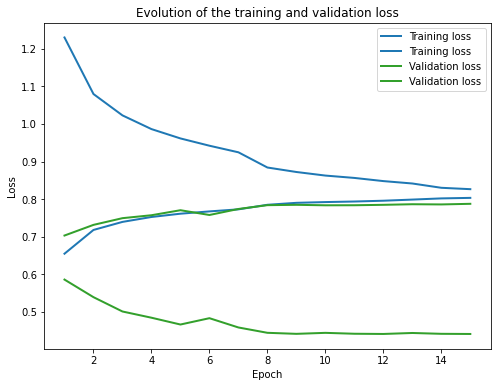

IndexError: list index out of range

In [156]:
history_tr=[]
history_tel=[]
history_teg=[]
    
for epoch in range(nb_epochs):
    loss_train, acc_train = train_bimodel(GF, CL, CG, train_loader, optim_g, optim_cl, optim_cg, 
          epoch, log_interval=10, criterion = criterion)
    history_tr.append((loss_train, acc_train))
    loss_val, acc_val_l, acc_val_g = test_bimodel(GF, CL, CG, val_loader, epoch, criterion = criterion)
    history_tel.append((loss_val, acc_val_l))
    history_teg.append((loss_val, acc_val_g))
    if scheduler_type=='step':
        scheduler_g.step()
        scheduler_cl.step()
        scheduler_cg.step()
        print(scheduler_cl._last_lr)
    if scheduler_type=='plateau':
        scheduler_g.step(acc_val_l)
        scheduler_cl.step(acc_val_l)
        scheduler_cg.step(acc_val_g)
        print(scheduler_g._last_lr)
    if save_model and epoch % save_epoch == 0:
        torch.save(GF.state_dict(),'GFBiModel_epoch_%s_alpha_0.5.pth' % (epoch))
        torch.save(CL.state_dict(),'CLBiModel_epoch_%s_alpha_0.5.pth' % (epoch))
        torch.save(CG.state_dict(),'CGBiModel_epoch_%s_alpha_0.5.pth' % (epoch))
    
print('Training Done')
plot_losses(history_tr, history_tel)
print('Best accuracy model basique :{}'.format(history_tel[-1][1]))

#### Résultats et conclusion

Training Done


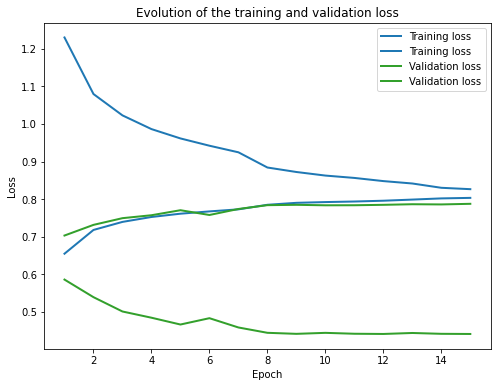

Best accuracy model basique :0.7874059849575932


In [157]:
#performance du bimodel aveec un lambda  égal à 0.5 
print('Training Done')
plot_losses(history_tr, history_tel)
print('Best accuracy model basique :{}'.format(history_tel[-1][1]))

In [158]:
#Performance du bimodel avec lambda=0.5 
pred_bool, labels, genres = predict_dataset_bimodel(GF, CL, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men)

Prediction complete
Accuracy_score général:  0.7880861163139343
Accuracy_score femme_0:  0.8268098831176758
Accuracy_score homme_1:  0.7335773706436157


J'ai constaté une très légere augmentation des écarts de performance entre le genre "homme" et le genre "femme" avec cette aproche.
La performance sur le genre "homme" est montée jusqu'à 74% réduisant ainsi l'écart entre les genres à environ 8%.

Je pense que mes paramètres d'apprentissage peuvent être améliorés. Entre autre le rapport entre la loss du classifieur CL et CG a un rôle important sur la convergence du modèle.
Je n'ai fait des essais que pour des lambda de 0.5, 1 et 2 et choisi de manière empirique 0.5

In [108]:
GF=Generator(num_classes, n_channels =3, dropout_prob=0.5).to(device)
CL=Clf_Label(num_classes).to(device)
CL.load_state_dict(torch.load('CLBiModel_epoch_14_alpha_0.5.pth'))
GF.load_state_dict(torch.load('GFBiModel_epoch_14_alpha_0.5.pth'))

<All keys matched successfully>

In [109]:
pred_bool, labels, genres = predict_dataset_bimodel(GF, CL, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men)

Prediction complete
Accuracy_score général:  0.7883661389350891
Accuracy_score femme_0:  0.8265361785888672
Accuracy_score homme_1:  0.7346368432044983


### Approche 5 - Classifieur par genre

Toujours dans l'otique de réduire les écarts de performance entre les genres "femmes" et "hommes" j\'ai souhaité évaluer les performances de classifieur dont la base d'apprentissage soit exclusivement constituée de données labellisées "femme" et "homme".

Pour cette approche, je me suis contenté de mon second CNN avec dropout et data augmentation qui apprend exclusivement sur les données labellisées "femme" ou "homme".

#### Data augmentation

In [196]:
#Caractéristics of image transformation 
image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

#Caractéristics of data augmenation 
data_augmentation_tr = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=1),
            #transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)]),p=0.1),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
            transforms.RandomApply(torch.nn.ModuleList([
                torchvision.transforms.GaussianBlur(5)]),p=0.2),
            transforms.RandomErasing(p=0.1),
])

#Caractéristics of data augmenation 
data_augmentation_tr2 = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.FiveCrop(50),
            transforms.Lambda(lambda crops: torch.stack([(crop) for crop in crops])),
            transforms.Resize(80),
    
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            #transforms.RandomErasing(p=0.1),
])

In [ ]:
data_augmentation = True
#Dataset and DataLoader
batch_size=128
#Training dataset
train_homme = CustomImageDataset(train_df.loc[train_df['genre']==1].reset_index(drop=True), "train", transform = image_transform)
train_femme = CustomImageDataset(train_df.loc[train_df['genre']==0].reset_index(drop=True), "train", transform = image_transform)
train_augmentation = CustomImageDataset(train_df.loc[train_df['genre']==1].reset_index(drop=True), "train", transform = data_augmentation_tr)
if data_augmentation == True:
    #train_dataset = torch.utils.data.TensorDataset(train_augmentation, train_original)
    train_homme = torch.utils.data.ConcatDataset([train_augmentation,train_homme])
    train_femme = torch.utils.data.ConcatDataset([train_augmentation,train_femme])

#Validation dataset
val_homme = CustomImageDataset(val_df.loc[train_df['genre']==1].reset_index(drop=True), "validation", transform = image_transform)
val_femme = CustomImageDataset(val_df.loc[train_df['genre']==0].reset_index(drop=True), "validation", transform = image_transform)
train_loader_homme = torch.utils.data.DataLoader(train_homme, batch_size=batch_size,shuffle=True)
val_loader_homme = torch.utils.data.DataLoader(val_homme, batch_size=1, shuffle=False)

print('Number of training samples: {}'.format(len(train_homme)))
print('Number of validation samples: {}'.format(len(val_homme)))
print('sample size: {}'.format(train_dataset[0][0].shape))
print('image rows: {}'.format(train_dataset[0][0].shape[1]))
print('image cols: {}'.format(train_dataset[0][0].shape[2]))
print('example of item :',val_dataset.__getitem__(10))

if data_augmentation == False:    
    print('Classes: {}'.format(np.unique(train_loader_homme.dataset.labels)))
    print('Genres: {}'.format(np.unique(train_loader_homme.dataset.genres)))
else:
    print('Classes: {}'.format(np.unique(train_loader_homme.dataset.datasets[0].labels)))
    print('Genres: {}'.format(np.unique(train_loader_homme.dataset.datasets[0].genres)))

#### Apprentissage

In [ ]:
#All the parameters
batch_size = 128
optimizer_type = "SGD"
scheduler_type='plateau'
learning_rate = 1e-2
weight_decay = 1e-3
lr_decay_epochs = 5
lr_decay = 0.1
nb_epochs = 15
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
momentum = 0.9
n_channels = 3
num_classes = 2
save_epoch=True
save_model=True
save_epoch =1

In [ ]:
#Loss
criterion = nn.CrossEntropyLoss()
#Model
model= Conv_bn_dro_init(num_classes, n_channels).to(device)
#Optimizer
if optimizer_type =='adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
if optimizer_type =='SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler
if scheduler_type=='step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs,gamma=lr_decay)
if scheduler_type=='plateau':   
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay, patience=5, threshold=0.05,verbose=True)

In [ ]:
history_tr=[]
history_te=[]
    
for epoch in range(nb_epochs):
    loss_train, acc_train = train( model, train_loader_homme, optimizer, epoch, log_interval=10, criterion=criterion )
    history_tr.append((loss_train, acc_train))
    loss_val, acc_val = test( model, val_loader_homme, epoch, criterion=criterion)
    history_te.append((loss_val, acc_val))
    if scheduler_type=='step':
        scheduler.step()
        print(scheduler._last_lr)
    if scheduler_type=='plateau':
        scheduler.step(acc_val)
        print(scheduler._last_lr)
    if save_model and epoch % save_epoch == 0:
        torch.save(GF.state_dict(),'model_homme_%s_data_aug.pth' % (epoch))

    
print('Training Done')
plot_losses(history_tr, history_te)
print('Best accuracy model basique :{}'.format(history_te[-1][1]))

#### Résultats et conclusion

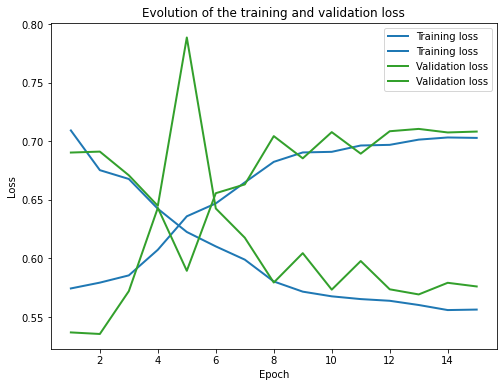

In [200]:
#Performance du model CNN ayant appris sur des données labellisées "homme"
plot_losses(history_tr, history_te)

In [110]:
model=Conv_bn_dro_init(num_classes, n_channels).to(device)
model.load_state_dict(torch.load('model_homme_14_data_aug.pth'))
model.eval()

# Performance en prédiction du model CNN ayant appris sur des données labellisées "homme" avec data augmentation
pred_bool, labels, genres = predict_dataset(model, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men)

Prediction complete
Accuracy_score général:  0.738638162612915
Accuracy_score femme_0:  0.7465444207191467
Accuracy_score homme_1:  0.7275091409683228


In [111]:
model=Conv_bn_dro_init(num_classes, n_channels).to(device)
model.load_state_dict(torch.load('model_femme_14_data_augx2.pth'))
model.eval()

# Performance en prédiction du model CNN ayant appris sur des données labellisées "femme" avec data augmentation
pred_bool, labels, genres = predict_dataset(model, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men)

Prediction complete
Accuracy_score général:  0.7335973978042603
Accuracy_score femme_0:  0.8110715746879578
Accuracy_score homme_1:  0.6245424747467041


On constate que le modèle ayant appris exclusivement sur les données homme généralise très bien en terme de performance. 
L'écart en prédiction sur les genres est de l'ordre de 2% dans ce cas.

Au contraire le modèle ayant appris exclusivement sur les données labellisées "femme" voit sa performance augmenter unilatéralement pour le genre femme et diminuer pour le genre homme (62%). L'écart passe à presque 20% dans ce cas.

Le modèle est le modèle que j'ai posté sur le datachallenge pour ses performances atypiques.

On comprend néanmoins que ce modèle réduit la performance sur une partie du cluster "femme" au lieu d'augmenter la performance du cluter "homme" pour atteindre celui du genre "femme".

 ### Approche 6 - Transfer learning depuis xception
 
Constatant qu'il semble possible d'améliorer les performances de prédiction pour le genre "homme" il m'a semblé interressant de trouver un moyen d'améliorer la couche d'extraction des caractéristiques des modèles.
 
Afin de bénéficier de modèle préentrainé j'ai décidé de regarder des approches de transfer learning avec Xception pré-entrainé sur image net. 

Le modèle choisi est importé avec ses poids pré-entrainés sur imagenet. J'ai choisi de limiter le calcul du gradient lors de la phase de backpropagation au block 12. Seuls les dernières couches sont dont adaptées à notre problématique de classification.

Un poids à noter et que à à mon sens il s'agit pour moi d'une classification "fake"-"no fake".

##### Modèle

In [22]:
import xception
import models

In [23]:
model = models.TransferModel('xception', num_out_classes=2,dropout=0.5)

Using dropout 0.5


In [24]:
model.set_trainable_up_to(True,layername="block11")

In [25]:
for i, param in model.named_parameters():
    print(i, param.requires_grad)

model.conv1.weight False
model.bn1.weight False
model.bn1.bias False
model.conv2.weight False
model.bn2.weight False
model.bn2.bias False
model.block1.skip.weight False
model.block1.skipbn.weight False
model.block1.skipbn.bias False
model.block1.rep.0.conv1.weight False
model.block1.rep.0.pointwise.weight False
model.block1.rep.1.weight False
model.block1.rep.1.bias False
model.block1.rep.3.conv1.weight False
model.block1.rep.3.pointwise.weight False
model.block1.rep.4.weight False
model.block1.rep.4.bias False
model.block2.skip.weight False
model.block2.skipbn.weight False
model.block2.skipbn.bias False
model.block2.rep.1.conv1.weight False
model.block2.rep.1.pointwise.weight False
model.block2.rep.2.weight False
model.block2.rep.2.bias False
model.block2.rep.4.conv1.weight False
model.block2.rep.4.pointwise.weight False
model.block2.rep.5.weight False
model.block2.rep.5.bias False
model.block3.skip.weight False
model.block3.skipbn.weight False
model.block3.skipbn.bias False
model.blo

#### Data augmentation

In [112]:
#Caractéristics of image transformation 
image_transform_ = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

#Caractéristics of data augmenation 
data_augmentation_tr_ = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.RandomErasing(p=0.1),
])

In [113]:
data_augmentation = False
#Dataset and DataLoader
batch_size=16
#Training dataset
train_original = CustomImageDataset(train_df, "train", transform = image_transform_)
train_augmentation = CustomImageDataset(train_df, "train", transform = data_augmentation_tr_)
if data_augmentation == False:
    train_dataset = train_original
else:
    #train_dataset = torch.utils.data.TensorDataset(train_augmentation, train_original)
    train_dataset = torch.utils.data.ConcatDataset([train_augmentation,train_original])

#Validation dataset
val_dataset = CustomImageDataset(val_df, "validation", transform = image_transform_)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

print('Number of training samples: {}'.format(len(train_dataset)))
print('Number of validation samples: {}'.format(len(val_dataset)))
print('sample size: {}'.format(train_dataset[0][0].shape))
print('image rows: {}'.format(train_dataset[0][0].shape[1]))
print('image cols: {}'.format(train_dataset[0][0].shape[2]))
print('example of item :',val_dataset.__getitem__(10))

if data_augmentation == False:    
    print('Classes: {}'.format(np.unique(train_loader.dataset.labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.genres)))
else:
    print('Classes: {}'.format(np.unique(train_loader.dataset.datasets[0].labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.datasets[0].genres)))

Number of training samples: 149983
Number of validation samples: 24996
sample size: torch.Size([3, 299, 299])
image rows: 299
image cols: 299
example of item : (tensor([[[ 0.6235,  0.6235,  0.5843,  ..., -0.5059, -0.5451, -0.5451],
         [ 0.6235,  0.6235,  0.5843,  ..., -0.5059, -0.5451, -0.5451],
         [ 0.5843,  0.5843,  0.5373,  ..., -0.5137, -0.5529, -0.5529],
         ...,
         [-0.7255, -0.7255, -0.7490,  ..., -0.4275, -0.5059, -0.5059],
         [-0.7255, -0.7255, -0.7569,  ..., -0.4118, -0.5059, -0.5059],
         [-0.7255, -0.7255, -0.7569,  ..., -0.4118, -0.5059, -0.5059]],

        [[ 0.7725,  0.7725,  0.7333,  ..., -0.2706, -0.3098, -0.3098],
         [ 0.7725,  0.7725,  0.7333,  ..., -0.2706, -0.3098, -0.3098],
         [ 0.7333,  0.7333,  0.6941,  ..., -0.2784, -0.3176, -0.3176],
         ...,
         [-0.5922, -0.5922, -0.6235,  ..., -0.3725, -0.4510, -0.4510],
         [-0.5922, -0.5922, -0.6314,  ..., -0.3647, -0.4510, -0.4510],
         [-0.5922, -0.5922, 

#### Apprentissage

In [47]:
#All the parameters
optimizer_type = "SGD"
scheduler_type='step'
learning_rate = 1e-4
weight_decay = 0
lr_decay_epochs = 10
lr_decay = 0.1
nb_epochs = 20
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
momentum = 0.9
n_channels = 3
num_classes = 2
save_model=True
save_epoch = 1
#Loss
criterion = nn.CrossEntropyLoss()
#Model
model= model.to(device)
#Optimizer
if optimizer_type =='adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(momentum,0.999), weight_decay=weight_decay)
if optimizer_type =='SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler
if scheduler_type=='step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs,gamma=lr_decay)
if scheduler_type=='plateau':   
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay, patience=5, threshold=0.05,verbose=True)


In [ ]:
history_tr=[]
history_te=[]
    
for epoch in range(nb_epochs):
    loss_train, acc_train = train( model, train_loader, optimizer, epoch, log_interval=100, criterion=criterion )
    history_tr.append((loss_train, acc_train))
    loss_val, acc_val = test( model, val_loader, epoch, criterion=criterion)
    history_te.append((loss_val, acc_val))
    if scheduler_type=='step':
        scheduler.step()
        print(scheduler._last_lr)
    if scheduler_type=='plateau':
        scheduler.step(acc_val)
        print(scheduler._last_lr)
    if save_model and epoch % save_epoch == 0:
        torch.save(model.state_dict(),'xceptionModel_bis_epoch_%s.pth' % (epoch))
    
print('Training Done')
plot_losses(history_tr, history_te)
print('Best accuracy model basique :{}'.format(history_te[-1][1]))
    
torch.save(model.state_dict(), 'xception_bis.pth')

Train Epoch: 0 [0/149983 (0%)]	Loss: 0.645355	Acc: 0.750000
Train Epoch: 0 [1600/149983 (1%)]	Loss: 0.630509	Acc: 0.750000
Train Epoch: 0 [3200/149983 (2%)]	Loss: 0.707208	Acc: 0.562500
Train Epoch: 0 [4800/149983 (3%)]	Loss: 0.610916	Acc: 0.750000
Train Epoch: 0 [6400/149983 (4%)]	Loss: 0.741306	Acc: 0.500000
Train Epoch: 0 [8000/149983 (5%)]	Loss: 0.707174	Acc: 0.437500
Train Epoch: 0 [9600/149983 (6%)]	Loss: 0.684428	Acc: 0.562500
Train Epoch: 0 [11200/149983 (7%)]	Loss: 0.767837	Acc: 0.500000
Train Epoch: 0 [12800/149983 (9%)]	Loss: 0.695211	Acc: 0.500000
Train Epoch: 0 [14400/149983 (10%)]	Loss: 0.641866	Acc: 0.625000
Train Epoch: 0 [16000/149983 (11%)]	Loss: 0.619489	Acc: 0.750000
Train Epoch: 0 [17600/149983 (12%)]	Loss: 0.652096	Acc: 0.625000
Train Epoch: 0 [19200/149983 (13%)]	Loss: 0.742177	Acc: 0.500000
Train Epoch: 0 [20800/149983 (14%)]	Loss: 0.671670	Acc: 0.562500
Train Epoch: 0 [22400/149983 (15%)]	Loss: 0.680082	Acc: 0.625000
Train Epoch: 0 [24000/149983 (16%)]	Loss: 0.

Train Epoch: 1 [49600/149983 (33%)]	Loss: 0.502103	Acc: 0.750000
Train Epoch: 1 [51200/149983 (34%)]	Loss: 0.579916	Acc: 0.562500
Train Epoch: 1 [52800/149983 (35%)]	Loss: 0.617639	Acc: 0.687500
Train Epoch: 1 [54400/149983 (36%)]	Loss: 0.509218	Acc: 0.750000
Train Epoch: 1 [56000/149983 (37%)]	Loss: 0.781667	Acc: 0.500000
Train Epoch: 1 [57600/149983 (38%)]	Loss: 0.699323	Acc: 0.625000
Train Epoch: 1 [59200/149983 (39%)]	Loss: 0.508569	Acc: 0.812500
Train Epoch: 1 [60800/149983 (41%)]	Loss: 0.461224	Acc: 0.875000
Train Epoch: 1 [62400/149983 (42%)]	Loss: 0.597793	Acc: 0.500000
Train Epoch: 1 [64000/149983 (43%)]	Loss: 0.540538	Acc: 0.625000
Train Epoch: 1 [65600/149983 (44%)]	Loss: 0.537855	Acc: 0.750000
Train Epoch: 1 [67200/149983 (45%)]	Loss: 0.650985	Acc: 0.562500
Train Epoch: 1 [68800/149983 (46%)]	Loss: 0.719010	Acc: 0.500000
Train Epoch: 1 [70400/149983 (47%)]	Loss: 0.539593	Acc: 0.750000
Train Epoch: 1 [72000/149983 (48%)]	Loss: 0.748939	Acc: 0.562500
Train Epoch: 1 [73600/149

Train Epoch: 2 [99200/149983 (66%)]	Loss: 0.576215	Acc: 0.750000
Train Epoch: 2 [100800/149983 (67%)]	Loss: 0.660825	Acc: 0.625000
Train Epoch: 2 [102400/149983 (68%)]	Loss: 0.524763	Acc: 0.875000
Train Epoch: 2 [104000/149983 (69%)]	Loss: 0.617857	Acc: 0.625000
Train Epoch: 2 [105600/149983 (70%)]	Loss: 0.487381	Acc: 0.812500
Train Epoch: 2 [107200/149983 (71%)]	Loss: 0.661519	Acc: 0.625000
Train Epoch: 2 [108800/149983 (73%)]	Loss: 0.599529	Acc: 0.812500
Train Epoch: 2 [110400/149983 (74%)]	Loss: 0.554444	Acc: 0.687500
Train Epoch: 2 [112000/149983 (75%)]	Loss: 0.436887	Acc: 0.750000
Train Epoch: 2 [113600/149983 (76%)]	Loss: 0.610687	Acc: 0.562500
Train Epoch: 2 [115200/149983 (77%)]	Loss: 0.480659	Acc: 0.812500
Train Epoch: 2 [116800/149983 (78%)]	Loss: 0.613047	Acc: 0.625000
Train Epoch: 2 [118400/149983 (79%)]	Loss: 0.528422	Acc: 0.625000
Train Epoch: 2 [120000/149983 (80%)]	Loss: 0.710357	Acc: 0.500000
Train Epoch: 2 [121600/149983 (81%)]	Loss: 0.645049	Acc: 0.562500
Train Epoch

#### Résultats et conclusion

In [114]:

model=models.TransferModel('xception', num_out_classes=2,dropout=0.5).to(device)
model.load_state_dict(torch.load('xceptionModel_epoch_8.pth'))
model.eval()

# Performance en prédiction du modèle xception pretrained
pred_bool, labels, genres = predict_dataset(model, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men)

Using dropout 0.5
Prediction complete
Accuracy_score général:  0.7828452587127686
Accuracy_score femme_0:  0.8233200907707214
Accuracy_score homme_1:  0.7258716821670532


Les résultats obtenus sont bons mais pas meilleurs qu'auparavant. Les poids pré-entraines de xception n'ont pas apporté d'information pertinente pour améliorer la classification. Une approche est nécessaire

### Approche 7 - Approche hybride et fine tuning depuis facenet

De plus en plus convaincu qu'il s'agit de classiffier des images "fake"/"no fake" d'images de face j'ai recherché des modèles pré-entrainés sur des visgaes et / ou sur des images modifiées.

Ayant tenté une approche de "fine tuning" du modèle facenet préentrainé et n'ayant pas obtenu d'amélioration des performances j'ai décidé de l'utiliser comme extracteur de caractéristiques. 

Dans cette approche j'utilise le modèle facenet préentrainé sur des visages pour extraire un embedding 512 points.
Ce vecteur de 512 points est concaténé aux sorties d'un CNN maison qui génére aussi un embedding de 512 points.
Des couches de classification permettent ensuite de discriminer les labels.

J'ai choisi de limiter le calcul du gradient lors de la phase de backpropagation à la partie CNN maison, il est aussi possible de "fine-tuner" les poids du modèle facenet.
    

#### Modèle

In [115]:
#!pip install facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training

In [116]:
class Facenet(nn.Module):
    def __init__(self,num_classes, fine_tuning= False):
        super(Facenet,self).__init__()
        self.resnet=InceptionResnetV1(pretrained='vggface2')
        for i, param in self.resnet.named_parameters():
                param.requires_grad = fine_tuning
        self.last_layer=nn.Sequential(nn.Dropout(p=0.5),
                                  nn.Linear(512,num_classes))
                
    def forward(self,x):
        x=self.resnet(x)
        out=self.last_layer(x)
        return out

In [117]:
class Hybrid(nn.Module):
    def __init__(self,num_classes, n_channels =3, dropout_prob=0.5, fine_tuning=True):
        super(Hybrid,self).__init__()
        self.dropout_prob=dropout_prob
        self.layer1=nn.Sequential(nn.Conv2d(n_channels, 32, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2=nn.Sequential(nn.Conv2d(32, 64, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3=nn.Sequential(nn.Conv2d(64, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4=nn.Sequential(nn.Conv2d(128, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.last_layer_cnn=nn.Linear(512,128)
        self.linear=nn.Linear(512+512,256)
        self.bn_linear = nn.BatchNorm1d(256)
        self.last_layer=nn.Linear(256,num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.zeros_(m.bias.data)

        self.resnet=InceptionResnetV1(pretrained='vggface2')
        '''ct = []
            found = False
            for name, child in self.resnet.named_children():
                if 'last_linear' in ct:
                    found = True
                    for params in child.parameters():
                        params.requires_grad = True
                ct.append(name)'''
        if fine_tuning:
          for i, param in self.resnet.named_parameters():
                  param.requires_grad = True
        else:
          for i, param in self.resnet.named_parameters():
                  param.requires_grad = False
                
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.avgpool(out)
        out=F.dropout(out,p=self.dropout_prob) 
        out=out.reshape(out.size(0),-1)
        emb=self.resnet(x)
        out = torch.cat((out,emb),1)
        out=F.relu(self.bn_linear(self.linear(out)))
        out=F.dropout(out,p=self.dropout_prob)
        out=self.last_layer(out)
        return out

#### Data Processing

In [118]:
#Caractéristics of image transformation 
image_transform_facenet = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            #fixed_image_standardization,
            transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

#Caractéristics of data augmenation 
data_augmentation_tr_facenet = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            #fixed_image_standardization,
            transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)]),p=0.1),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
            transforms.RandomApply(torch.nn.ModuleList([
                torchvision.transforms.GaussianBlur(5)]),p=0.2),
            #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.RandomErasing(p=0.1),
])

In [119]:
data_augmentation = False
#Dataset and DataLoader
batch_size=32
#Training dataset
train_original = CustomImageDataset(train_df, "train", transform = image_transform_facenet)
train_augmentation = CustomImageDataset(train_df, "train", transform = data_augmentation_tr_facenet)
if data_augmentation == False:
    train_dataset = train_original
else:
    #train_dataset = torch.utils.data.TensorDataset(train_augmentation, train_original)
    train_dataset = torch.utils.data.ConcatDataset([train_augmentation,train_original])

#Validation dataset
val_dataset = CustomImageDataset(val_df, "validation", transform = image_transform_facenet)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

print('Number of training samples: {}'.format(len(train_dataset)))
print('Number of validation samples: {}'.format(len(val_dataset)))
print('sample size: {}'.format(train_dataset[0][0].shape))
print('image rows: {}'.format(train_dataset[0][0].shape[1]))
print('image cols: {}'.format(train_dataset[0][0].shape[2]))
print('example of item :',val_dataset.__getitem__(10))

if data_augmentation == False:    
    print('Classes: {}'.format(np.unique(train_loader.dataset.labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.genres)))
else:
    print('Classes: {}'.format(np.unique(train_loader.dataset.datasets[0].labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.datasets[0].genres)))

Number of training samples: 149983
Number of validation samples: 24996
sample size: torch.Size([3, 160, 160])
image rows: 160
image cols: 160
example of item : (tensor([[[ 0.6235,  0.5608,  0.4431,  ..., -0.3569, -0.4824, -0.5451],
         [ 0.5608,  0.4902,  0.3569,  ..., -0.3725, -0.4980, -0.5608],
         [ 0.4353,  0.3569,  0.1922,  ..., -0.4039, -0.5216, -0.5843],
         ...,
         [-0.7098, -0.7412, -0.7961,  ..., -0.3255, -0.4510, -0.5137],
         [-0.7176, -0.7647, -0.8431,  ..., -0.1765, -0.3961, -0.5059],
         [-0.7255, -0.7725, -0.8667,  ..., -0.0980, -0.3725, -0.5059]],

        [[ 0.7725,  0.7176,  0.6078,  ..., -0.1294, -0.2471, -0.3098],
         [ 0.7176,  0.6549,  0.5294,  ..., -0.1373, -0.2549, -0.3176],
         [ 0.6078,  0.5294,  0.3647,  ..., -0.1608, -0.2784, -0.3412],
         ...,
         [-0.5765, -0.6078, -0.6784,  ..., -0.2706, -0.3882, -0.4510],
         [-0.5843, -0.6314, -0.7255,  ..., -0.1294, -0.3412, -0.4510],
         [-0.5922, -0.6471, 

#### Apprentissage

In [ ]:
#All the parameters
batch_size = 128
optimizer_type = "adam"
scheduler_type='plateau'
learning_rate = 1e-3
weight_decay = 1e-5
lr_decay_epochs = 3
lr_decay = 0.5
nb_epochs = 20
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
momentum = 0.9
n_channels = 3
num_classes = 2
save_model=True
save_epoch = 1
#Loss
criterion = nn.CrossEntropyLoss()
#Model
model= Hybrid(num_classes,fine_tuning=True).to(device)
#Optimizer
if optimizer_type =='adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(momentum,0.999), weight_decay=weight_decay)
if optimizer_type =='SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler
if scheduler_type=='step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs,gamma=lr_decay)
if scheduler_type=='plateau':   
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay, patience=5, threshold=0.05,verbose=True)

In [ ]:
history_tr=[]
history_te=[]
    
for epoch in range(nb_epochs):
    loss_train, acc_train = train( model, train_loader, optimizer, epoch, log_interval=100, criterion=criterion )
    history_tr.append((loss_train, acc_train))
    loss_val, acc_val = test( model, val_loader, epoch, criterion=criterion)
    history_te.append((loss_val, acc_val))
    if scheduler_type=='step':
        scheduler.step()
        print(scheduler._last_lr)
    if scheduler_type=='plateau':
        scheduler.step(acc_val)
        print(scheduler._last_lr)
    if save_model and epoch % save_epoch == 0:
        torch.save(model.state_dict(),'facenet_pretrained_finetuning_epoch_%s.pth' % (epoch))
    
print('Training Done')
plot_losses(history_tr, history_te)
print('Best accuracy model basique :{}'.format(history_te[-1][1]))
    
torch.save(model.state_dict(), 'facenet_pretrained_finetuning.pth')

#### Résultats et conclusion

In [120]:
model=Hybrid(num_classes,fine_tuning=True).to(device)
model.load_state_dict(torch.load('facenet_pretrained_finetuning_epoch_7.pth'))
model.eval()

# Performance en prédiction du modèle hybrid avec facenet
pred_bool, labels, genres = predict_dataset(model, val_dataset)
acc, acc_men, acc_women = accuracy_dataset(pred_bool, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men) 

Prediction complete
Accuracy_score général:  0.7892462611198425
Accuracy_score femme_0:  0.8272204995155334
Accuracy_score homme_1:  0.7357926964759827


Encore une fois les résultats de cette approche sont bons, la performance globale est de l'ordre de 79%, mais l'écart entre genre reste très important et ne permet pas d'améliorer la performance de classification inter-classes.

In [92]:
acc, acc_men, acc_women = accuracy_dataset(results, labels, genres)
print('Accuracy_score général: ' , acc)
print('Accuracy_score femme_0: ' , acc_women)
print('Accuracy_score homme_1: ' , acc_men)

Accuracy_score général:  0.7861257791519165
Accuracy_score femme_0:  0.8207882642745972
Accuracy_score homme_1:  0.7373338341712952


In [ ]:
def predict_dataset_bimodel(GF, CL, dataset):
    GF.eval()
    CL.eval()
    loader=torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=False)
    results= torch.zeros((len(loader),1), dtype=torch.int32)
    labels= torch.zeros((len(loader),1), dtype=torch.int32)
    genres= torch.zeros((len(loader),1), dtype=torch.int32)
    with torch.no_grad():
        for idx, (image,label,genre) in enumerate(loader):
            image = image.to(device)
            results[idx] = torch.argmax(CL(GF(image)),axis=1)
            labels[idx] = label
            genres[idx] = genre
    
    print('Prediction complete')

    return results, labels, genres 
def predict_dataset_threshold(model, dataset,threshold = 0.5):
    model.eval()
    loader=torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=False)
    results= torch.zeros((len(loader),1), dtype=torch.int32)
    labels= torch.zeros((len(loader),1), dtype=torch.int32)
    genres= torch.zeros((len(loader),1), dtype=torch.int32)
    with torch.no_grad():
        for idx, (image,label,genre) in enumerate(loader):
            image = image.to(device)
            results[idx] = nn.functional.softmax(model(image))[:,1]>threshold
            labels[idx] = label
            genres[idx] = genre
    
    print('Prediction complete')

    return results, labels, genres 

### Approche 8 - Annexe - Triplet approach

Enfin pour terminer j'ai initié une approche par loss "Triplet". J'ai indiqué ci dessous le code que j'ai initié.
Je n'ai pas eu le temps d'évaluer la performance de cette approche

In [36]:
class Triplet(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset, train = True):
        self.dataset = dataset
        self.train = train
        self.labels = self.dataset.labels
        self.genres = self.dataset.genres
        self.transform = self.dataset.transform

        if self.train:
            self.train_labels = self.dataset.img_labels
            self.labels_set = set(self.labels)
            self.label_to_indices = {label: np.where(self.train_labels == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.dataset.img_labels
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.dataset))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1, genre1 = self.dataset.__getitem__(index)
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1.item()])
            negative_label = np.random.choice(list(self.labels_set - set([label1.item()])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.dataset.__getitem__(positive_index)[0]
            img3 = self.dataset.__getitem__(negative_index)[0]
        else:
            img1 = self.dataset.__getitem__(self.test_triplets[index][0])
            img2 = self.dataset.__getitem__(self.test_triplets[index][1])
            img3 = self.dataset.__getitem__(self.test_triplets[index][2])
            
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.dataset)

In [38]:
data_augmentation = False
#Dataset and DataLoader
batch_size=128
#Training dataset
train_original = CustomImageDataset(train_df, "train", transform = image_transform)
train_augmentation = CustomImageDataset(train_df, "train", transform = data_augmentation_tr)
if data_augmentation == False:
    train_dataset = train_original
else:
    #train_dataset = torch.utils.data.TensorDataset(train_augmentation, train_original)
    train_dataset = torch.utils.data.ConcatDataset([train_augmentation,train_original])

#Validation dataset
val_dataset = CustomImageDataset(val_df, "validation", transform = image_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

print('Number of training samples: {}'.format(len(train_dataset)))
print('Number of validation samples: {}'.format(len(val_dataset)))
print('sample size: {}'.format(train_dataset[0][0].shape))
print('image rows: {}'.format(train_dataset[0][0].shape[1]))
print('image cols: {}'.format(train_dataset[0][0].shape[2]))
print('example of item :',val_dataset.__getitem__(10))

if data_augmentation == False:    
    print('Classes: {}'.format(np.unique(train_loader.dataset.labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.genres)))
else:
    print('Classes: {}'.format(np.unique(train_loader.dataset.datasets[0].labels)))
    print('Genres: {}'.format(np.unique(train_loader.dataset.datasets[0].genres)))

Number of training samples: 149983
Number of validation samples: 24996
sample size: torch.Size([3, 80, 80])
image rows: 80
image cols: 80
example of item : (tensor([[[ 1.4269,  0.8961, -0.2171,  ..., -0.8507, -0.5767, -1.1247],
         [ 0.8789,  0.1083, -1.0048,  ..., -0.9534, -0.7308, -1.2445],
         [ 0.3138, -1.0904, -0.9705,  ..., -0.3198, -0.6965, -0.9877],
         ...,
         [-1.8782, -1.5357, -2.1179,  ..., -0.6281, -0.9877, -1.1247],
         [-1.4843, -1.6727, -1.5528,  ..., -0.5253, -0.7308, -1.0733],
         [-1.5185, -1.9295, -1.3815,  ...,  0.6563,  0.1426, -1.0390]],

        [[ 1.9209,  1.4307,  0.2927,  ..., -0.1450,  0.0476, -0.4951],
         [ 1.4307,  0.6429, -0.4601,  ..., -0.2675, -0.0749, -0.5826],
         [ 0.9405, -0.4601, -0.3550,  ...,  0.3803,  0.0476, -0.2500],
         ...,
         [-1.5455, -1.1954, -1.8782,  ..., -0.4426, -0.7227, -0.8277],
         [-1.0903, -1.3354, -1.3004,  ..., -0.3375, -0.4951, -0.8102],
         [-1.1253, -1.5980, -1.1

In [39]:
triplet_train_dataset = Triplet(train_dataset) # Returns triplets of images
triplet_val_dataset = Triplet(val_dataset)
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)
triplet_val_loader = torch.utils.data.DataLoader(triplet_val_dataset, batch_size=batch_size, shuffle=False)

In [40]:
class EmbeddingNet(nn.Module):
    def __init__(self,num_emb, n_channels):
        super(EmbeddingNet,self).__init__()
        self.layer1=nn.Sequential(nn.Conv2d(n_channels, 32, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2=nn.Sequential(nn.Conv2d(32, 64, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3=nn.Sequential(nn.Conv2d(64, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4=nn.Sequential(nn.Conv2d(128, 128, kernel_size= 5,stride=1, padding=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer5=nn.Sequential(nn.Conv2d(128, 128, kernel_size= 5,stride=1, padding=4, dilation=2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU())
        self.fc=nn.Sequential(nn.Linear(5*5*128,512),
                              nn.PReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(512,512),
                              nn.PReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(512,num_emb))
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.zeros_(m.bias.data)
                
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.layer5(out)
        out=out.reshape(out.size(0),-1)
        out=self.fc(out)
        return out
    
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)
    
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, num_emb, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(num_emb, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [53]:
def train_triplet(model, train_loader, optimizer, epoch, log_interval = 10, criterion = nn.TripletMarginLoss()):

    model.train()
    losses = []
    loss_epoch = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        labels = labels if len(labels) > 0 else None
        if not type(images) in (tuple, list):
            images = (images,) 
        images = tuple(d.to(device) for d in images)

        optimizer.zero_grad()
        outputs = model(*images)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)
                  
        loss_outputs = criterion(*outputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        loss.backward()
        optimizer.step()
                  
                  
        losses.append(loss.item())
        loss_epoch += loss.item()
        

        if batch_idx % log_interval == 0:
            message = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                batch_idx * len(images[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            print(message)
            losses = []
    
    train_loss = loss_epoch/ len(train_loader)
    print('Train Epoch: {} \LOSS: {:.6f}'.
          format(epoch, train_loss))
                  
    return train_loss


def test_triplet(model, val_loader, epoch, criterion = nn.TripletMarginLoss()):
    with torch.no_grad():
        model.eval()
        loss_epoch = 0
        for batch_idx, (images, labels) in enumerate(val_loader):
            labels = labels if len(labels) > 0 else None
            if not type(images) in (tuple, list):
                images = (images,)
            images = tuple(d.to(device) for d in images)

            outputs = model(*images)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
                
            loss_outputs = criterion(*outputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            loss_epoch += loss.item()
    val_loss = loss_epoch/ len(val_loader)
    print('Test Epoch: {} \LOSS: {:.6f}'.
          format(epoch, val_loss))

    return val_loss

In [54]:
#All the parameters
optimizer_type = "adam"
scheduler_type='step'
learning_rate = 1e-3
weight_decay = 1e-5
lr_decay_epochs = 8
lr_decay = 0.1
nb_epochs = 25
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
momentum = 0.9
n_channels = 3
num_classes = 2
save_epoch = True
save_model = True
save_epoch = 1
num_emb = 2
log_interval = 100

In [55]:
#Model
margin =1.
embedding_net = EmbeddingNet(num_emb,n_channels)
model = TripletNet(embedding_net).to(device)
#Criterion
criterion = nn.TripletMarginLoss()
#Optimizer
if optimizer_type =='adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
if optimizer_type =='SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler
if scheduler_type=='step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs,gamma=lr_decay)
if scheduler_type=='plateau':   
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=lr_decay, patience=5, threshold=0.05,verbose=True)

In [ ]:
history_tr=[]
history_te=[]
    
for epoch in range(nb_epochs):
    loss_train = train_triplet( model, triplet_train_loader, optimizer, epoch, log_interval=log_interval, criterion=criterion )
    history_tr.append((loss_train))
    loss_val = test_triplet( model, triplet_val_loader, epoch, criterion=criterion)
    history_te.append((loss_val))
    if scheduler_type=='step':
        scheduler.step()
        print(scheduler._last_lr)
    if scheduler_type=='plateau':
        scheduler.step(acc_val)
        print(scheduler._last_lr)
    if save_model and epoch % save_epoch == 0:
        torch.save(model.state_dict(),'TripletModel_epoch_%s.pth' % (epoch))
    
print('Training Done')
plot_losses(history_tr, history_te)


Train Epoch: 0 [0/149983 (0%)]	Loss: 1.089061
Train Epoch: 0 [12800/149983 (9%)]	Loss: 1.409759
Train Epoch: 0 [25600/149983 (17%)]	Loss: 1.033137
Train Epoch: 0 [38400/149983 (26%)]	Loss: 1.019306
Train Epoch: 0 [51200/149983 (34%)]	Loss: 1.010008
Train Epoch: 0 [64000/149983 (43%)]	Loss: 1.003748
Train Epoch: 0 [76800/149983 (51%)]	Loss: 1.008728
Train Epoch: 0 [89600/149983 (60%)]	Loss: 1.003164
Train Epoch: 0 [102400/149983 (68%)]	Loss: 1.000894
Train Epoch: 0 [115200/149983 (77%)]	Loss: 0.998190
Train Epoch: 0 [128000/149983 (85%)]	Loss: 1.000539
Train Epoch: 0 [140800/149983 (94%)]	Loss: 1.000965
Train Epoch: 0 \LOSS: 1.041140
Test Epoch: 0 \LOSS: 0.999920
[0.001]
Train Epoch: 1 [0/149983 (0%)]	Loss: 1.038803
Train Epoch: 1 [12800/149983 (9%)]	Loss: 1.005361
Train Epoch: 1 [25600/149983 (17%)]	Loss: 1.011195
Train Epoch: 1 [38400/149983 (26%)]	Loss: 1.008893
Train Epoch: 1 [51200/149983 (34%)]	Loss: 1.004102
Train Epoch: 1 [64000/149983 (43%)]	Loss: 1.005295
Train Epoch: 1 [76800

Train Epoch: 12 [12800/149983 (9%)]	Loss: 0.993151
Train Epoch: 12 [25600/149983 (17%)]	Loss: 1.002682
Train Epoch: 12 [38400/149983 (26%)]	Loss: 0.997027
Train Epoch: 12 [51200/149983 (34%)]	Loss: 1.004734
Train Epoch: 12 [64000/149983 (43%)]	Loss: 0.999756
Train Epoch: 12 [76800/149983 (51%)]	Loss: 1.001698
Train Epoch: 12 [89600/149983 (60%)]	Loss: 0.996409
Train Epoch: 12 [102400/149983 (68%)]	Loss: 1.000340
Train Epoch: 12 [115200/149983 (77%)]	Loss: 0.998961
Train Epoch: 12 [128000/149983 (85%)]	Loss: 0.999446
Train Epoch: 12 [140800/149983 (94%)]	Loss: 1.004098
Train Epoch: 12 \LOSS: 1.000024
Test Epoch: 12 \LOSS: 1.000220
[0.0001]
Train Epoch: 13 [0/149983 (0%)]	Loss: 1.009235
Train Epoch: 13 [12800/149983 (9%)]	Loss: 0.996081
Train Epoch: 13 [25600/149983 (17%)]	Loss: 0.999890
Train Epoch: 13 [38400/149983 (26%)]	Loss: 0.999827
Train Epoch: 13 [51200/149983 (34%)]	Loss: 1.006446
Train Epoch: 13 [64000/149983 (43%)]	Loss: 1.000653
Train Epoch: 13 [76800/149983 (51%)]	Loss: 1.00

## Conclusion 

Malgré plusieurs approches différentes et des tentatives un peu variées je n'ai pas réussi a beaucoup à améliorer les performances de classification pour le genre "homme". Malgré tout le DC m'a permis de mettre en application plusieurs modèles et de développer quelques compétences en deep learning.